# Cross-Country Epidemic Viz 

In [1]:
library(LalRUtils)
libreq(data.table, tidyverse, sf, janitor, anytime, lubridate, plotly, zoo, patchwork, ggrepel)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 20, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "tidyverse"  TRUE  
 [3,] "sf"         TRUE  
 [4,] "janitor"    TRUE  
 [5,] "anytime"    TRUE  
 [6,] "lubridate"  TRUE  
 [7,] "plotly"     TRUE  
 [8,] "zoo"        TRUE  
 [9,] "patchwork"  TRUE  
[10,] "ggrepel"    TRUE  


# JHU

In [2]:
jhu_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
cases = fread(jhu_cases_url)

jhu_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths = fread(jhu_deaths_url)

In [3]:
name_clean = function(df) setnames(df, str_replace(colnames(df), "/", "_"))

In [4]:
cases_long = melt(cases, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "cases") 
name_clean(cases_long)

deaths_long = melt(deaths, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "deaths") 
name_clean(deaths_long)
deaths_long[, c('Lat', 'Long') := NULL]

In [5]:
df = merge(cases_long, deaths_long,
      by = c("Province_State", "Country_Region", "date"), all.x = T)
df[, date := mdy(date)]
df[, day := weekdays(date)]
df[is.na(df)] = 0
df %>% glimpse

Rows: 71,556
Columns: 8
$ Province_State <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ Country_Region <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanis…
$ date           <date> 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-…
$ Lat            <dbl> 33.94, 33.94, 33.94, 33.94, 33.94, 33.94, 33.94, 33.94…
$ Long           <dbl> 67.71, 67.71, 67.71, 67.71, 67.71, 67.71, 67.71, 67.71…
$ cases          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ day            <chr> "Wednesday", "Thursday", "Friday", "Saturday", "Sunday…


In [6]:
fwrite(df, "data/jhu_panel.csv")

## Country Level

In [7]:
country_ts = df[, lapply(.SD, sum) , by = .(Country_Region, date), .SDcols = c("cases", "deaths")]

In [8]:
(t10countries = country_ts[date == max(country_ts$date)][order(-cases)][1:10])

Country_Region date       cases   deaths
1  US             2020-10-15 7979709 217692
2  India          2020-10-15 7370468 112161
3  Brazil         2020-10-15 5169386 152460
4  Russia         2020-10-15 1346380  23350
5  Argentina      2020-10-15  949063  25342
6  Colombia       2020-10-15  936982  28457
7  Spain          2020-10-15  921374  33553
8  Peru           2020-10-15  859740  33577
9  France         2020-10-15  850997  33146
10 Mexico         2020-10-15  834910  85285

In [9]:
t10_subset = country_ts[Country_Region %in% t10countries$Country_Region]
setorder(t10_subset, Country_Region, date)
# normalise time from first day with >= 10 cases
t10_subset[cases >= 10,  c_time := seq_len(.N), by = .(Country_Region)]
t10_subset[deaths >= 1, d_time := seq_len(.N), by = .(Country_Region)]

In [10]:
setorder(t10_subset, Country_Region, date)
t10_subset[, new_cases  := cases - shift(cases), by = .(Country_Region)]
t10_subset[, new_deaths := deaths - shift(deaths), by = .(Country_Region)]
t10_subset[, cfr := deaths/cases]
smoothvars = c('cases', 'new_cases', 'deaths', 'new_deaths', 'cfr')
t10_subset[, paste0("rm7_", smoothvars) := lapply(.SD, rollmean, k = 7, fill = NA, na.pad = T), 
   by = .(Country_Region), .SDcols = smoothvars]

In [11]:
t10_subset[, label := ifelse(date == max(date), Country_Region, NA)]

## Cumulative and New Cases / Deaths 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 389 rows containing missing values (geom_point).”
Warning message:
“Removed 422 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 520 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 397 rows 

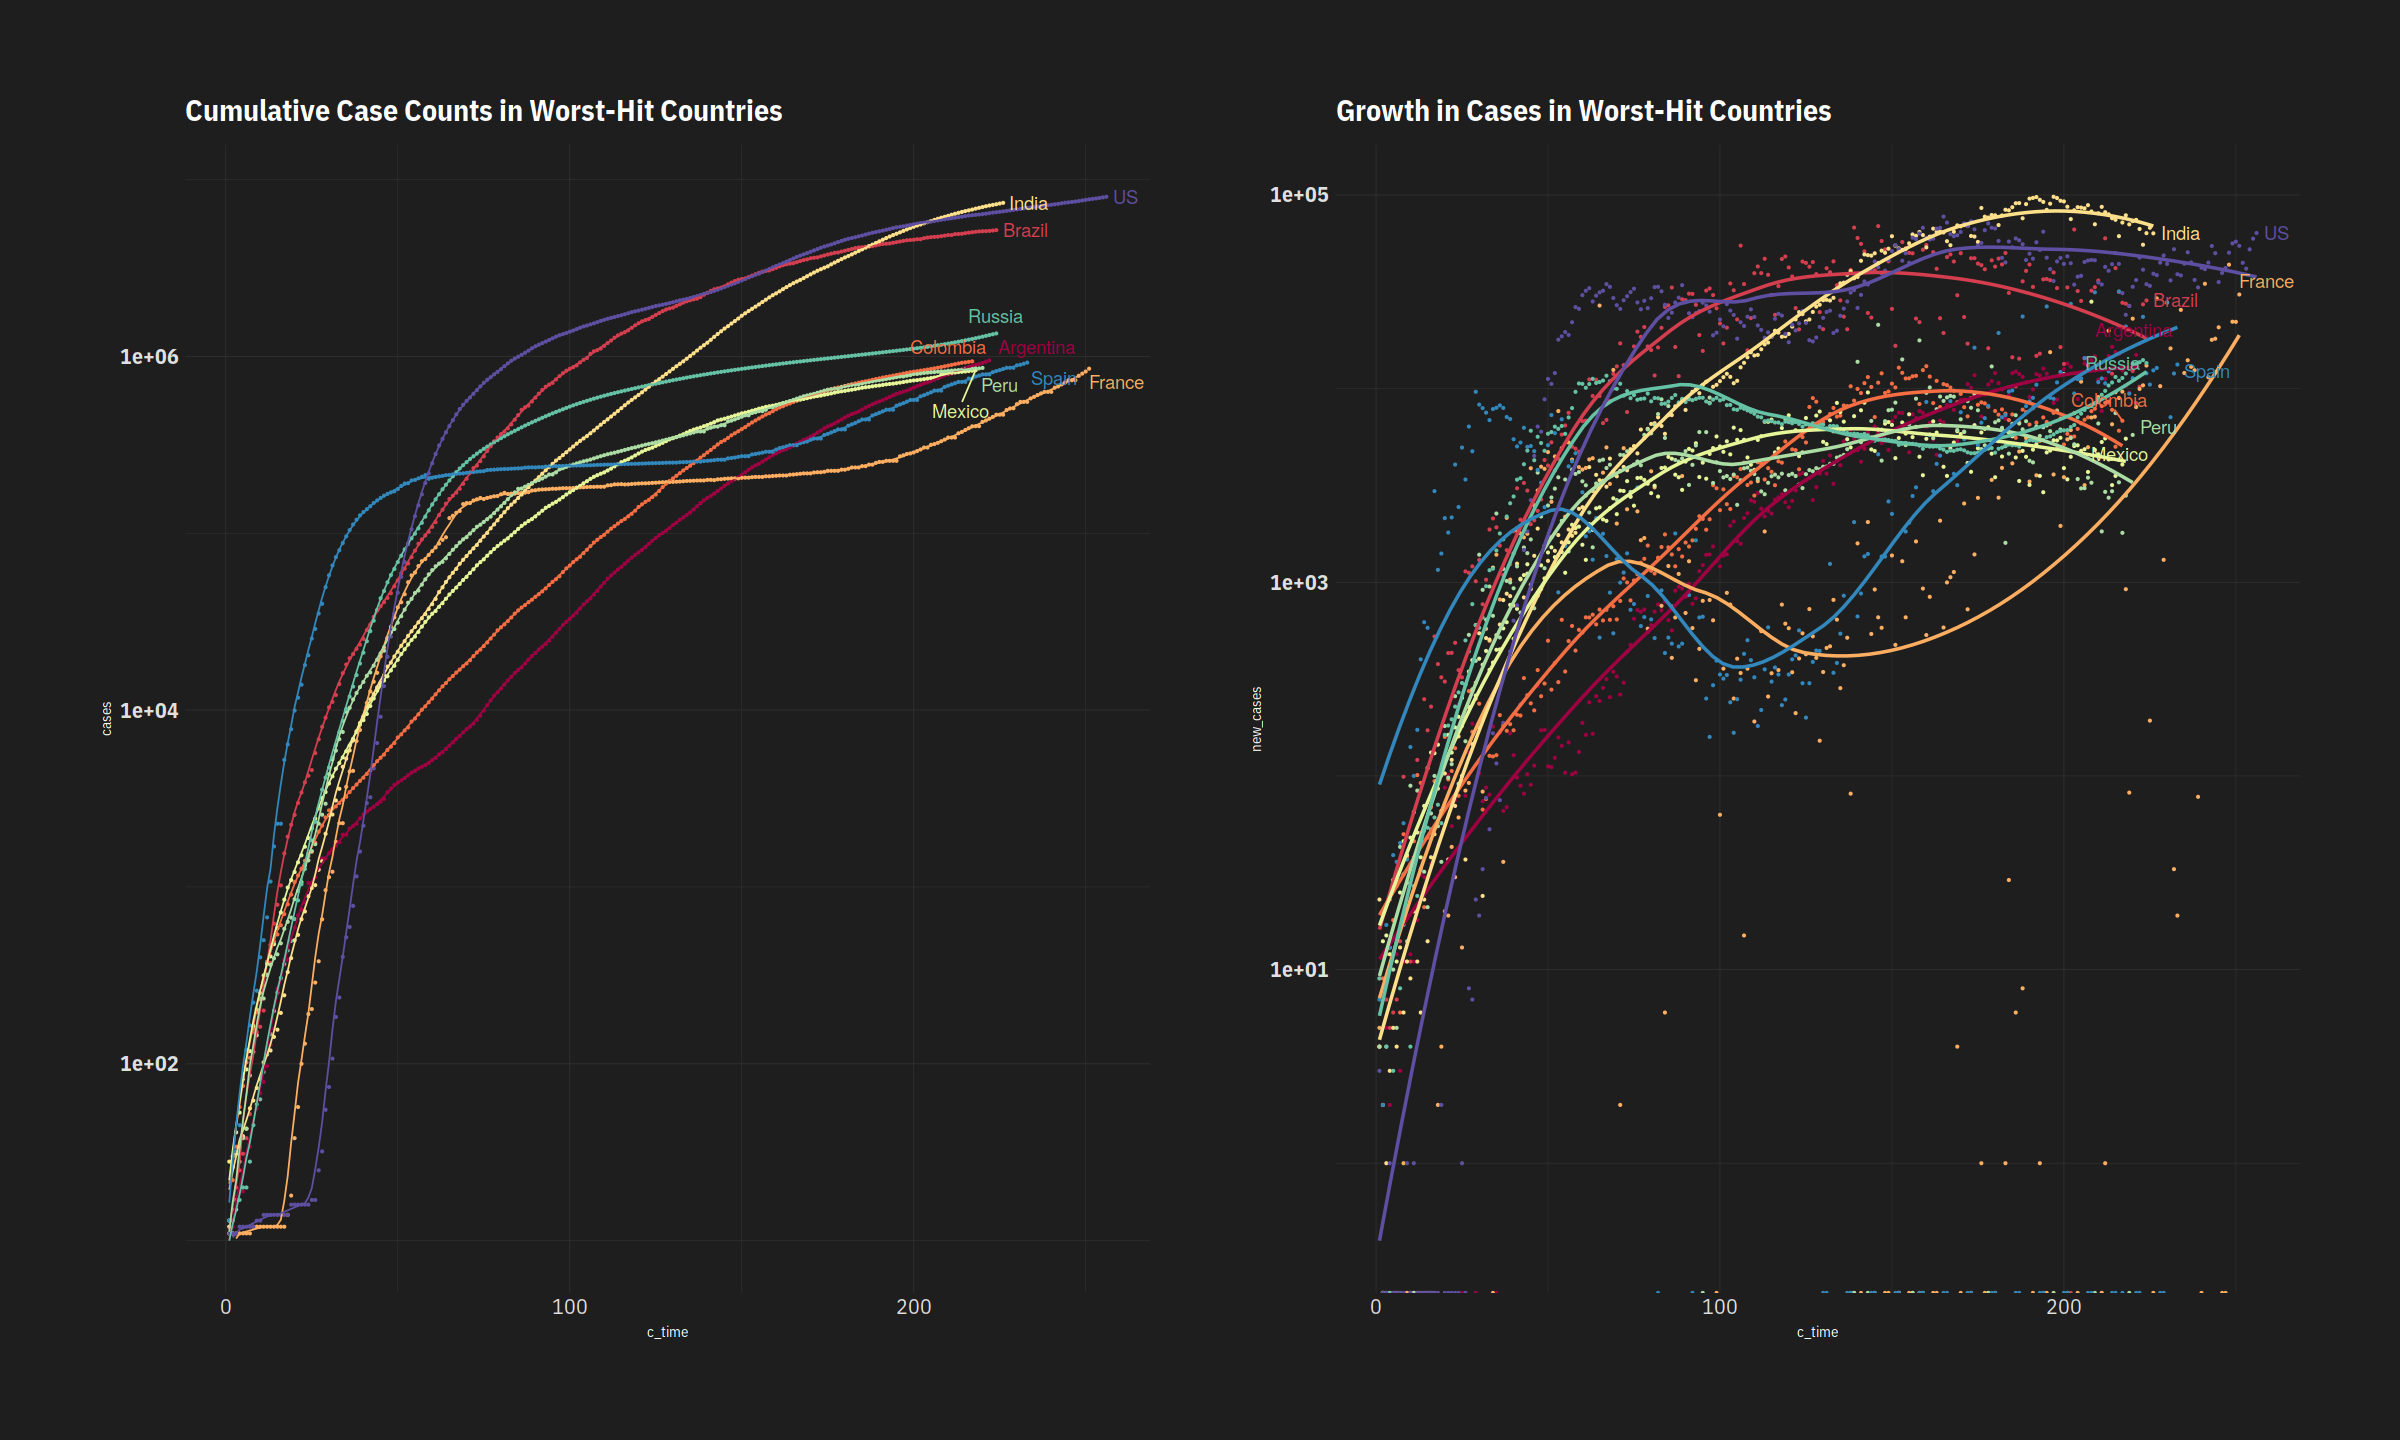

In [12]:
p1 = ggplot(t10_subset,
           aes(x = c_time, y = cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = cases), size = 0.5) + geom_line(aes(y = rm7_cases)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Case Counts in Worst-Hit Countries') 

p2 = 
    t10_subset %>% 
    ggplot(aes(x = c_time,y = new_cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_cases), size = 0.5) + 
#     geom_line(aes(y = rm7_new_cases)) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Cases in Worst-Hit Countries')

(p1 | p2 )

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 582 rows containing missing values (geom_point).”
Warning message:
“Removed 609 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 650 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 490 rows 

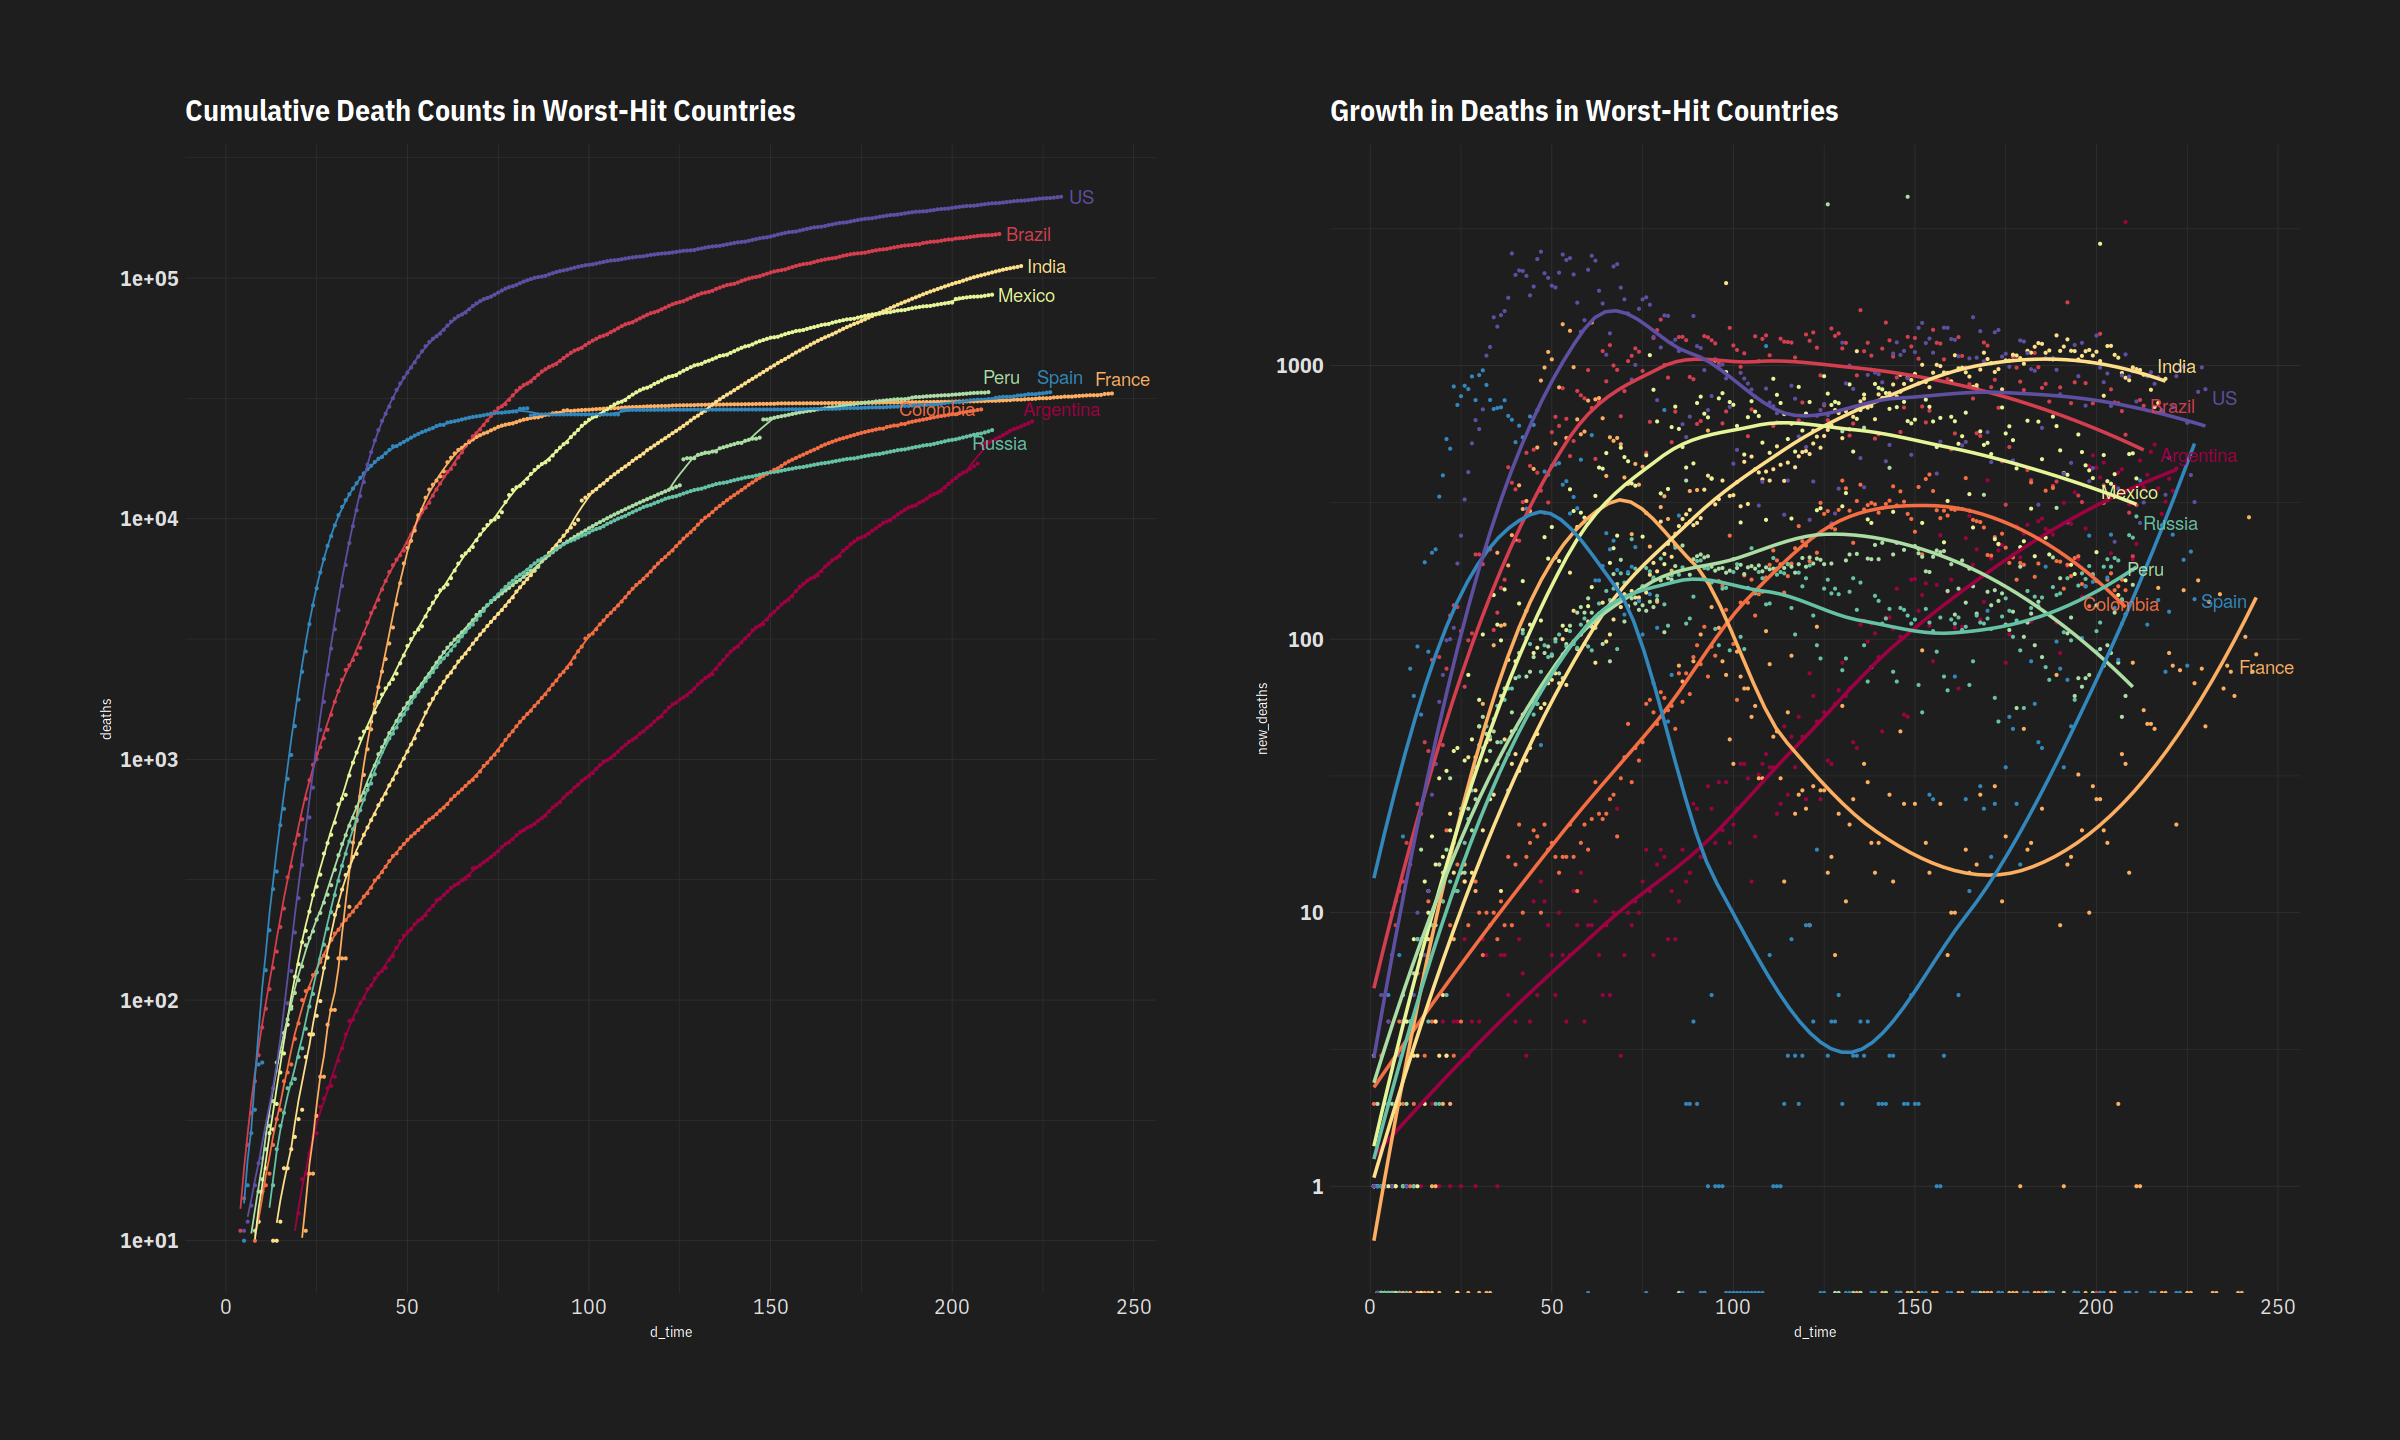

In [13]:
p1 = ggplot(t10_subset,
           aes(x = d_time, y = deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = deaths), size = 0.5) + geom_line(aes(y = rm7_deaths)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Death Counts in Worst-Hit Countries') 

p2 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = new_deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_deaths), size = 0.5) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Deaths in Worst-Hit Countries')

(p1 | p2 )

## Case Fatality Rate

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 485 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 485 rows containing missing values (geom_point).”


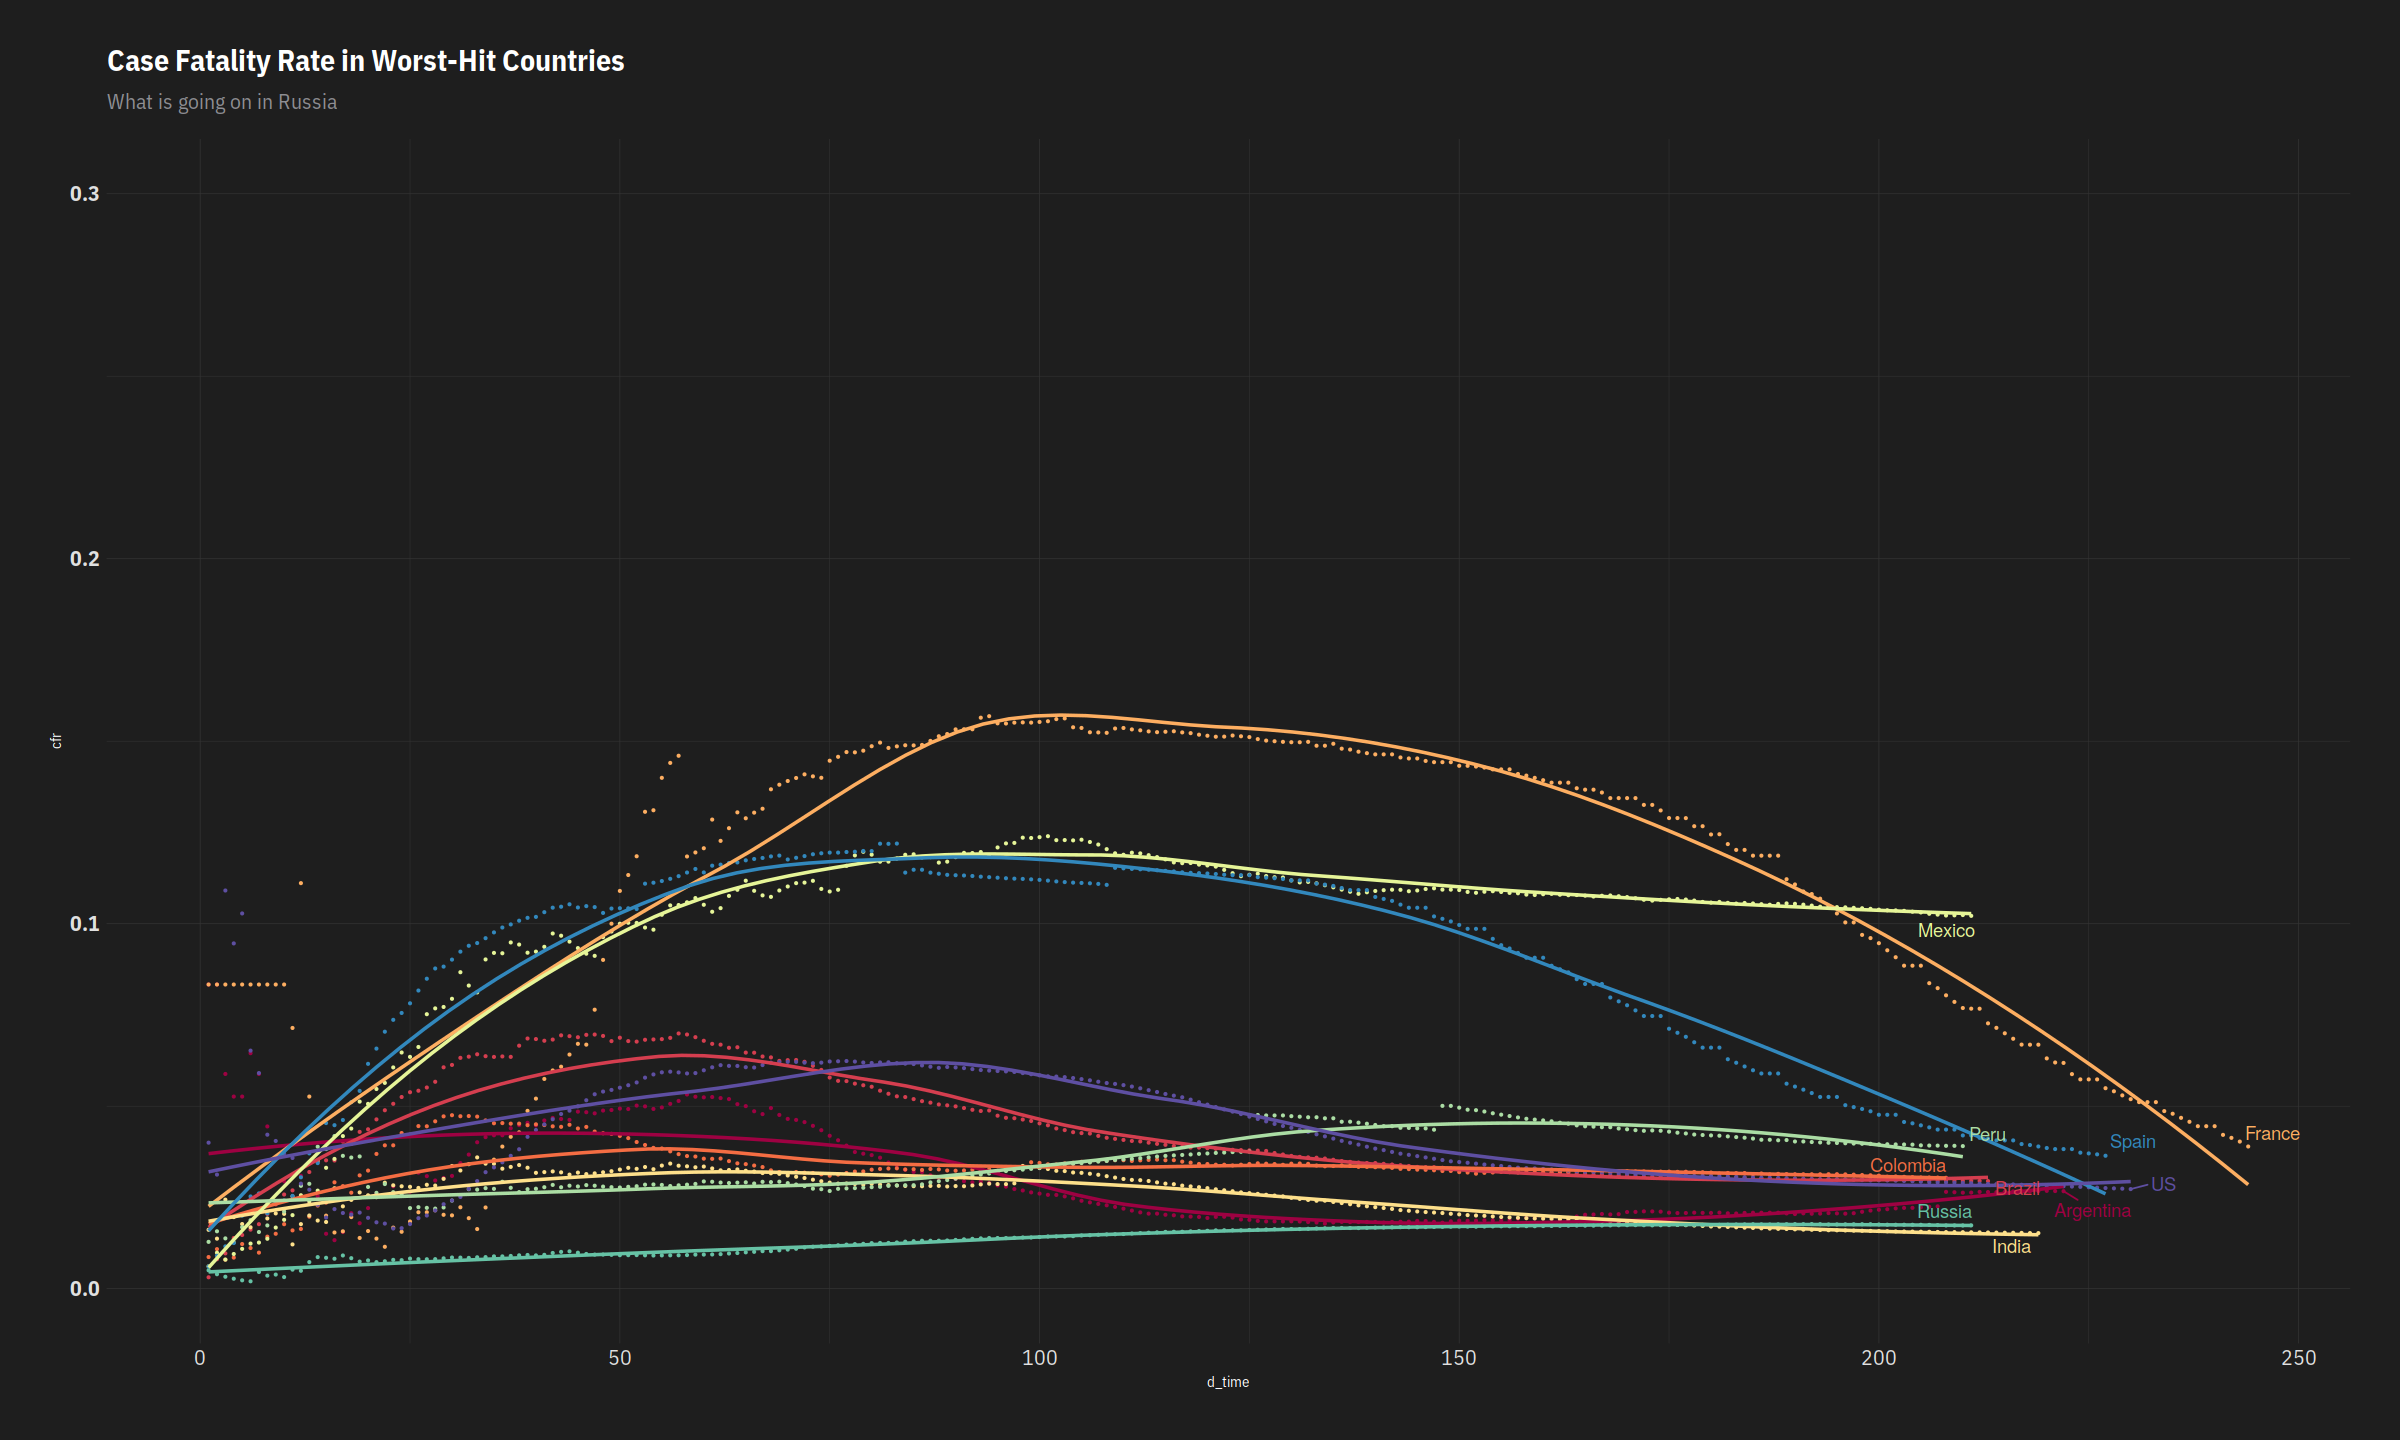

In [14]:
p3 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = cfr, group = Country_Region, colour = Country_Region)) + 
    geom_point(size = 0.5) + 
#     geom_line(aes(y = rm7_cfr)) + 
    geom_smooth(se = F) +
    ylim(c(0, 0.3)) +
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      na.rm = TRUE) +
    labs(title = 'Case Fatality Rate in Worst-Hit Countries', subtitle = "What is going on in Russia")
p3

## Shares

In [15]:
t10_subset[, denom_cases := sum(rm7_new_cases), by = date][, 
            denom_deaths := sum(rm7_new_deaths), by = date]
t10_subset[, newcase_share := rm7_new_cases / denom_cases][, 
            newdeath_share := rm7_new_deaths /denom_deaths]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 77 rows containing missing values (position_stack).”


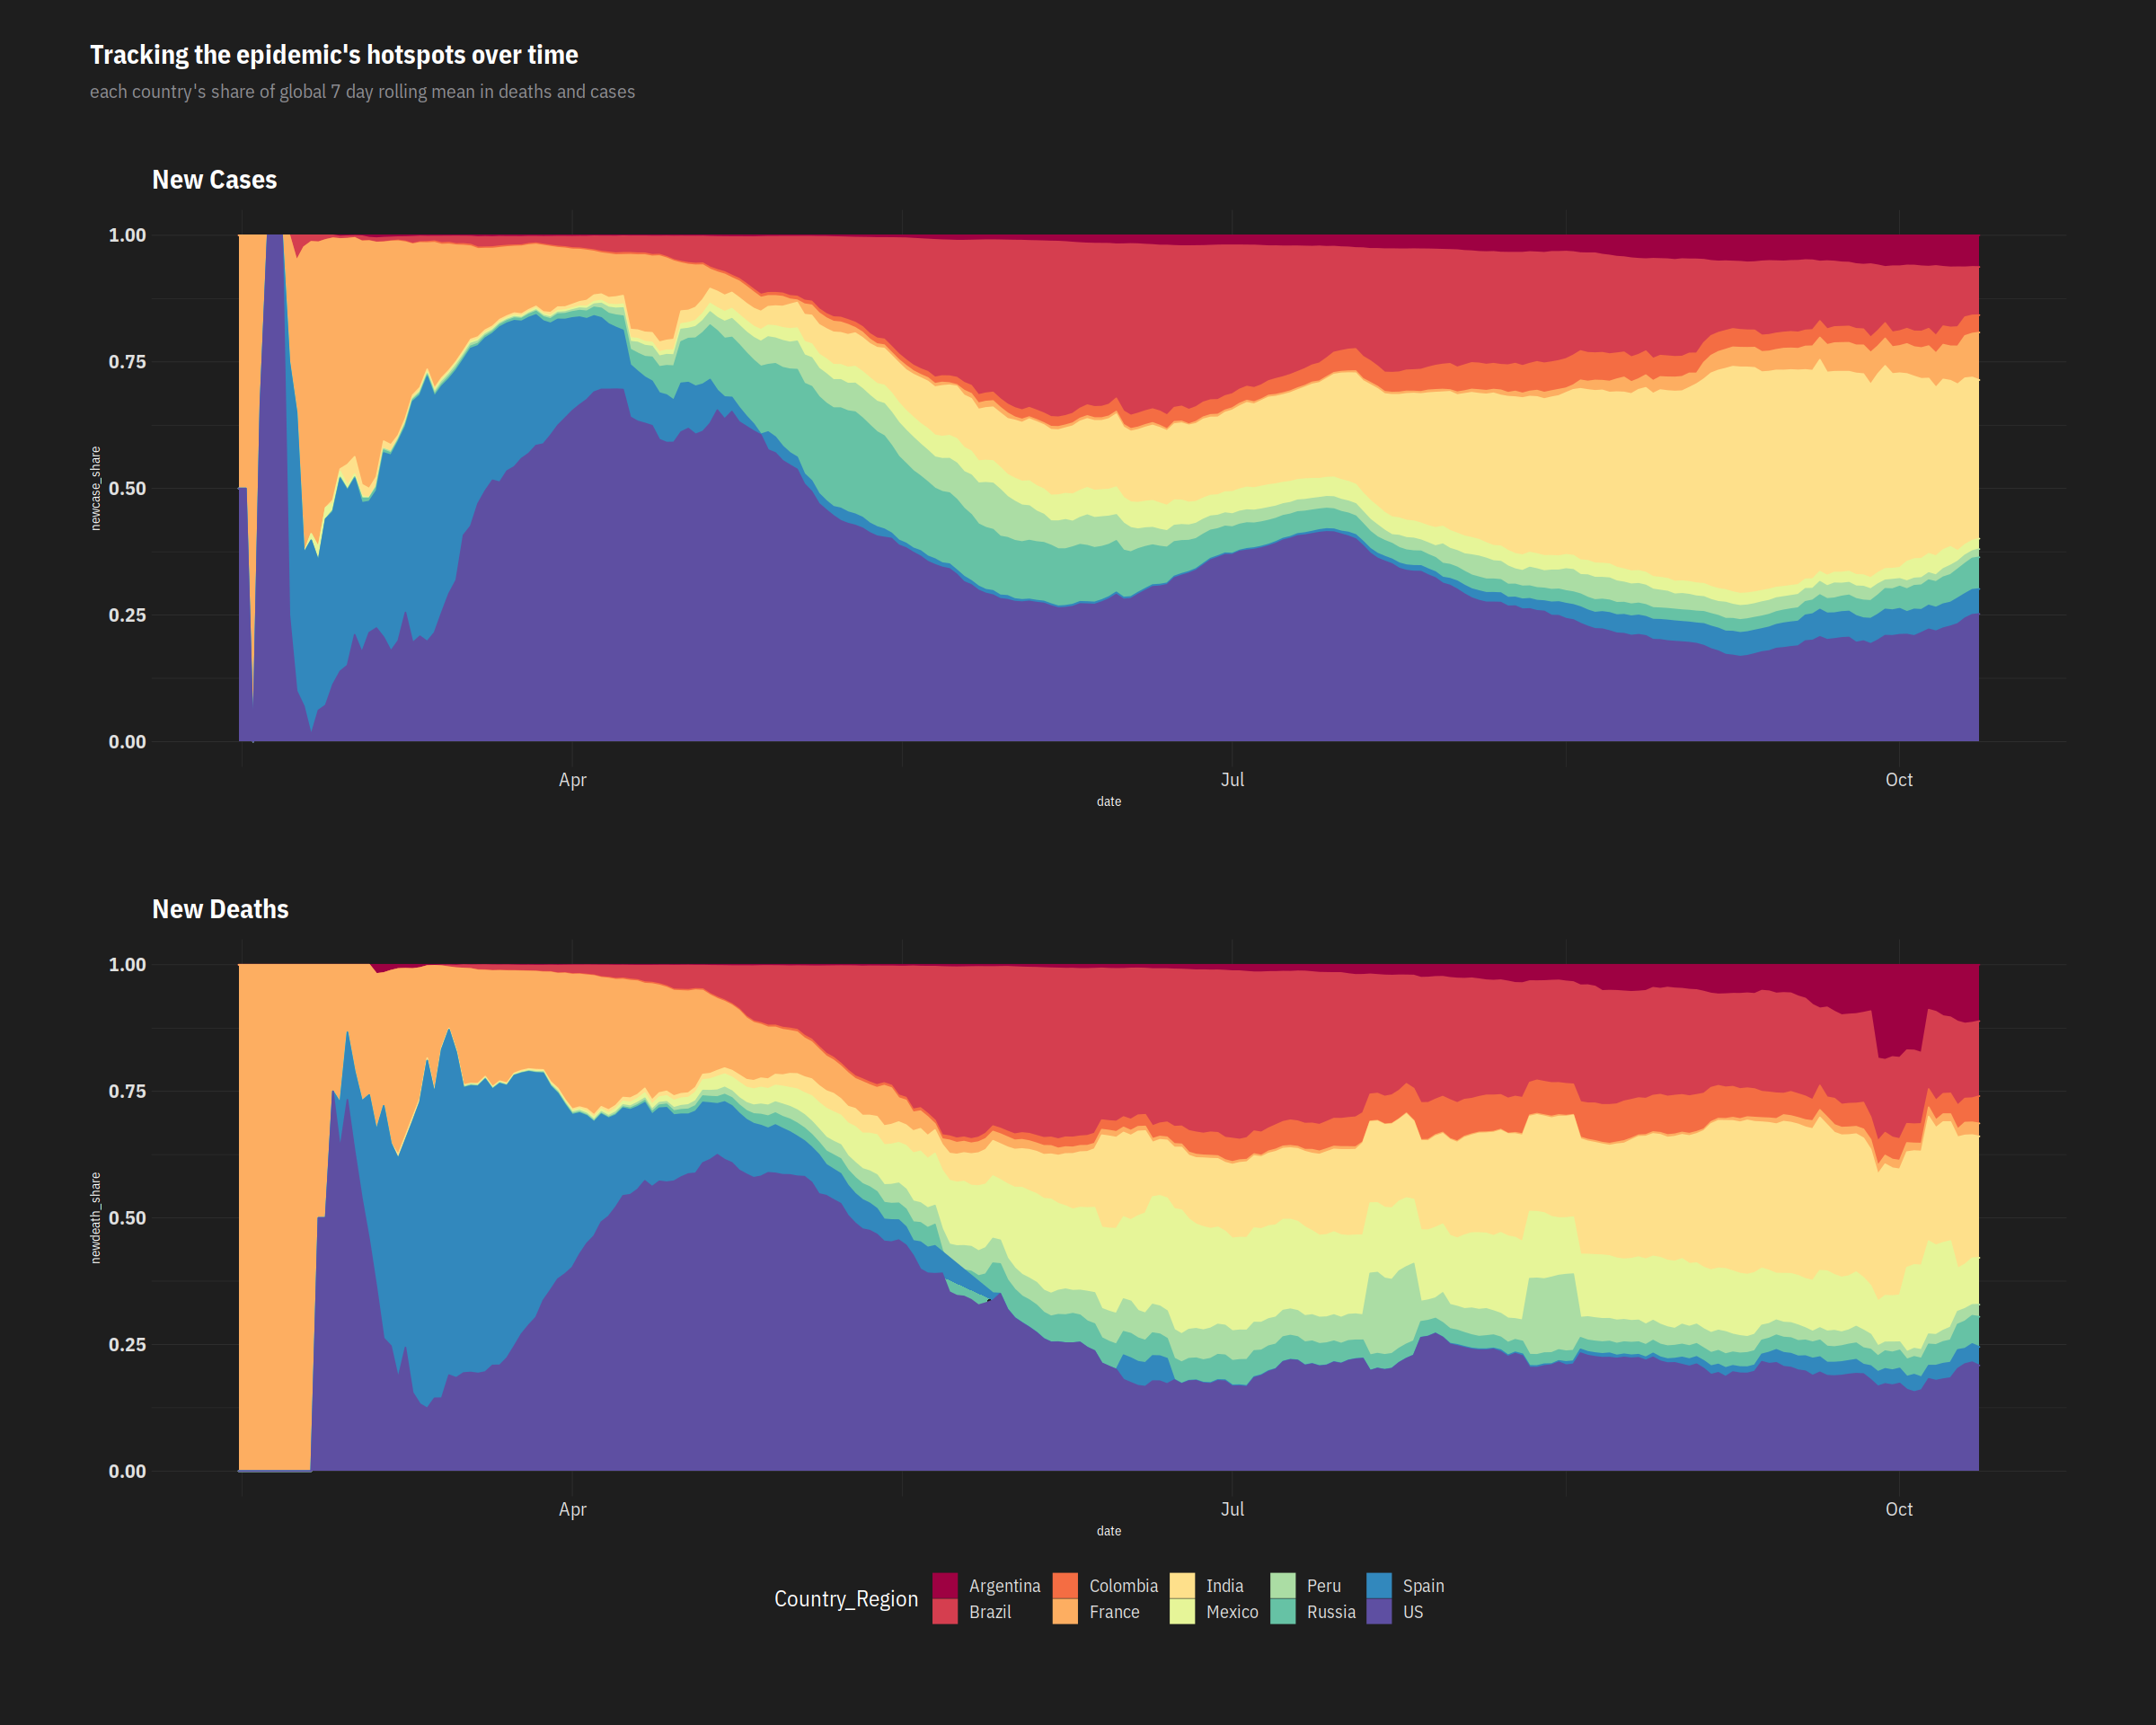

In [16]:
p1 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newcase_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases") + theme(legend.position = "None")
p2 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newdeath_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")

options(repr.plot.width = 20, repr.plot.height = 16)
(p = (p1 / p2 ) + plot_annotation(title = "Tracking the epidemic's hotspots over time", 
                                  subtitle = "each country's share of global 7 day rolling mean in deaths and cases"))

In [18]:
ggsave("carpet_plot_xc.png", p, width = 20, height = 16)

Warning message:
“Removed 40 rows containing missing values (position_stack).”
Warning message:
“Removed 147 rows containing missing values (position_stack).”


# OWID 

In [17]:
owid = fread("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid[, d := ymd(date)]
owid %>% glimpse

Rows: 50,513
Columns: 42
$ iso_code                        <chr> "ABW", "ABW", "ABW", "ABW", "ABW", "A…
$ continent                       <chr> "North America", "North America", "No…
$ location                        <chr> "Aruba", "Aruba", "Aruba", "Aruba", "…
$ date                            <date> 2020-03-13, 2020-03-19, 2020-03-20, …
$ total_cases                     <dbl> 2, NA, 4, NA, NA, NA, 12, 17, 19, 28,…
$ new_cases                       <dbl> 2, NA, 2, NA, NA, NA, 8, 5, 2, 9, 0, …
$ new_cases_smoothed              <dbl> NA, 0.286, 0.286, 0.286, 0.286, 0.286…
$ total_deaths                    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ new_deaths                      <dbl> 0, NA, 0, NA, NA, NA, 0, 0, 0, 0, 0, …
$ new_deaths_smoothed             <dbl> NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ total_cases_per_million         <dbl> 18.73, NA, 37.47, NA, NA, NA, 112.39,…
$ new_cases_per_million           <dbl> 18.73, NA, 18.73, NA, NA, NA, 74.93, …
$ new_cases_smoothed_per_mi

In [18]:
fwrite(owid, "data/owid_covid.csv")

In [19]:
all_countries_xs = owid[location!="World"][
    order(-d)][
    , .SD[1], by = .(iso_code)]
(t10 = all_countries_xs[order(-total_cases)][1:10])
#  [order(-total_cases)][1:10])

iso_code continent     location      date       total_cases new_cases
1  USA      North America United States 2020-10-16 7979885     63785    
2  IND      Asia          India         2020-10-16 7370468     63371    
3  BRA      South America Brazil        2020-10-16 5169386     28523    
4  RUS      Europe        Russia        2020-10-16 1354163     13754    
5  ARG      South America Argentina     2020-10-16  949050     17096    
6  COL      South America Colombia      2020-10-16  936982      6823    
7  ESP      Europe        Spain         2020-10-15  921374     13318    
8  PER      South America Peru          2020-10-16  859740      2789    
9  MEX      North America Mexico        2020-10-16  834910      5514    
10 FRA      Europe        France        2020-10-16  809684     30621    
   new_cases_smoothed total_deaths new_deaths new_deaths_smoothed ⋯
1  53327              217700       828        703.86              ⋯
2  66331              112161       895        810.14              ⋯
3  20135              152460       713        500.43              ⋯
4  13436               23491       286        205.00              ⋯
5  13242               25342       421        376.00              ⋯
6   7258               28457       151        160.86              ⋯
7  10436               33553       140        123.57              ⋯
8   3018               33577        65         68.43              ⋯
9   4346               85285       387        312.71              ⋯
10 19721               33125        88         86.29              ⋯
   extreme_poverty cardiovasc_death_rate diabetes_prevalence female_smokers
1   1.2            151.09                10.79               19.1          
2  21.2            282.28                10.39                1.9          
3   3.4            177.96                 8.11               10.1          
4   0.1            431.30                 6.18               23.4          
5   0.6            191.03                 5.50               16.2          
6   4.5            124.24                 7.44                4.7          
7   1.0             99.40                 7.17               27.4          
8   3.5             85.75                 5.95                4.8          
9   2.5            152.78                13.06                6.9          
10   NA             86.06                 4.77               30.1          
   male_smokers handwashing_facilities hospital_beds_per_thousand
1  24.6            NA                  2.77                      
2  20.6         59.55                  0.53                      
3  17.9            NA                  2.20                      
4  58.3            NA                  8.05                      
5  27.7            NA                  5.00                      
6  13.5         65.39                  1.71                      
7  31.4            NA                  2.97                      
8    NA            NA                  1.60                      
9  21.4         87.85                  1.38                      
10 35.6            NA                  5.98                      
   life_expectancy human_development_index d         
1  78.86           0.924                   2020-10-16
2  69.66           0.640                   2020-10-16
3  75.88           0.759                   2020-10-16
4  72.58           0.816                   2020-10-16
5  76.67           0.825                   2020-10-16
6  77.29           0.747                   2020-10-16
7  83.56           0.891                   2020-10-15
8  76.74           0.750                   2020-10-16
9  75.05           0.774                   2020-10-16
10 82.66           0.901                   2020-10-16

In [20]:
owid_t10_subset = owid[location %in% t10$location]

vars = c('new_cases', 'new_deaths', 'new_tests')
owid_t10_subset[, paste0('denom_', vars):= lapply(.SD, sum), by = date, .SDcols = vars]

owid_t10_subset[, `:=`(
            newcase_share  = new_cases / denom_new_cases,
            newdeath_share = new_deaths / denom_new_deaths,
            newtest_share  = new_tests / denom_new_tests
    )][ newcase_share < 0, newcase_share := 0]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 248 rows containing missing values (position_stack).”
Warning message:
“Removed 256 rows containing missing values (position_stack).”


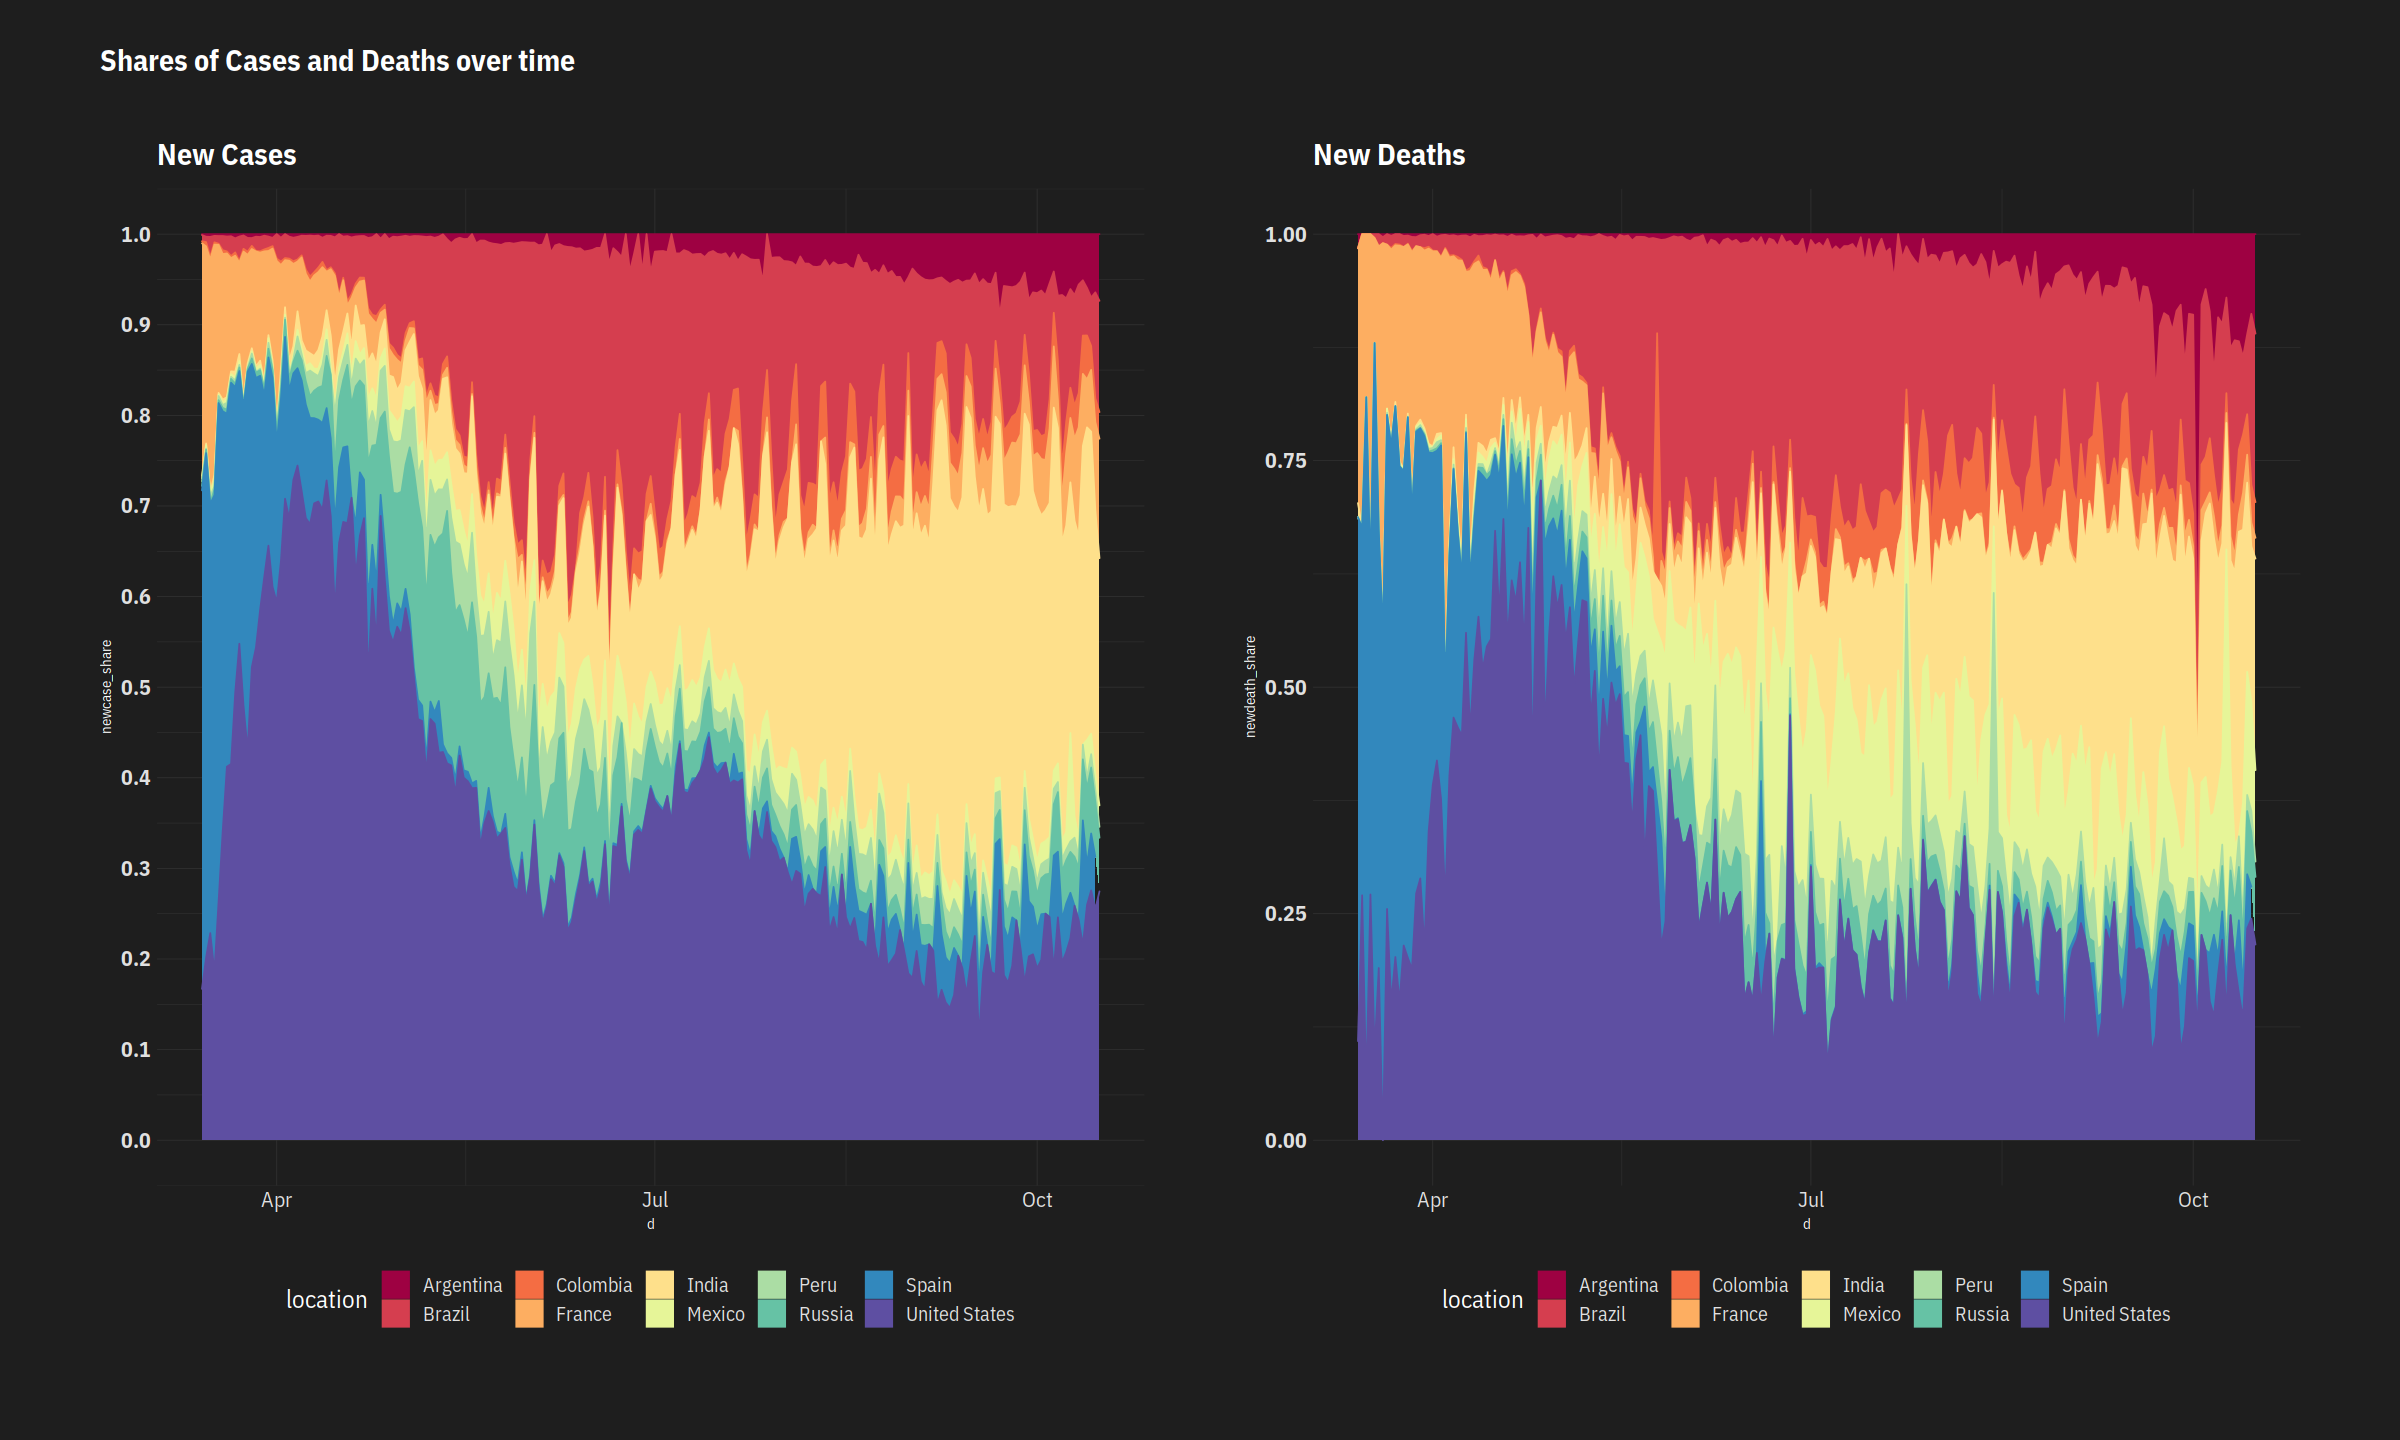

In [21]:
p1 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newcase_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newdeath_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") + ylim(c(0, 1)) +
    ggtitle("New Deaths")
options(repr.plot.width = 20, repr.plot.height = 12)
(p1 | p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")

## Country Profiles 

In [22]:
country_plot = function(country){
    npl = owid[location == country][order(-date)]
    p1 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_cases)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ylim(c(0, NA)) + 
        ggtitle('Total Cases') 
    
    p2 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_cases)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
         ylim(c(0, NA)) + 
        ggtitle('New Cases')
    
    p3 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_deaths)) +
        ylim(c(0, NA)) + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Deaths')
    
    p4 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
         ylim(c(0, NA)) + 
        ggtitle('New Deaths')

    p5 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_tests)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
         ylim(c(0, NA)) + 
        ggtitle('Total Tests')

    p6 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_tests)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ylim(c(0, NA)) + 
        ggtitle('New Tests')
    suppressMessages(suppressWarnings(print(
        (p5 | p6) / (p1 | p2) / (p3 | p4) + plot_annotation(title = paste0("Covid Profile : ", country))
    )))
}

## South Asia

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



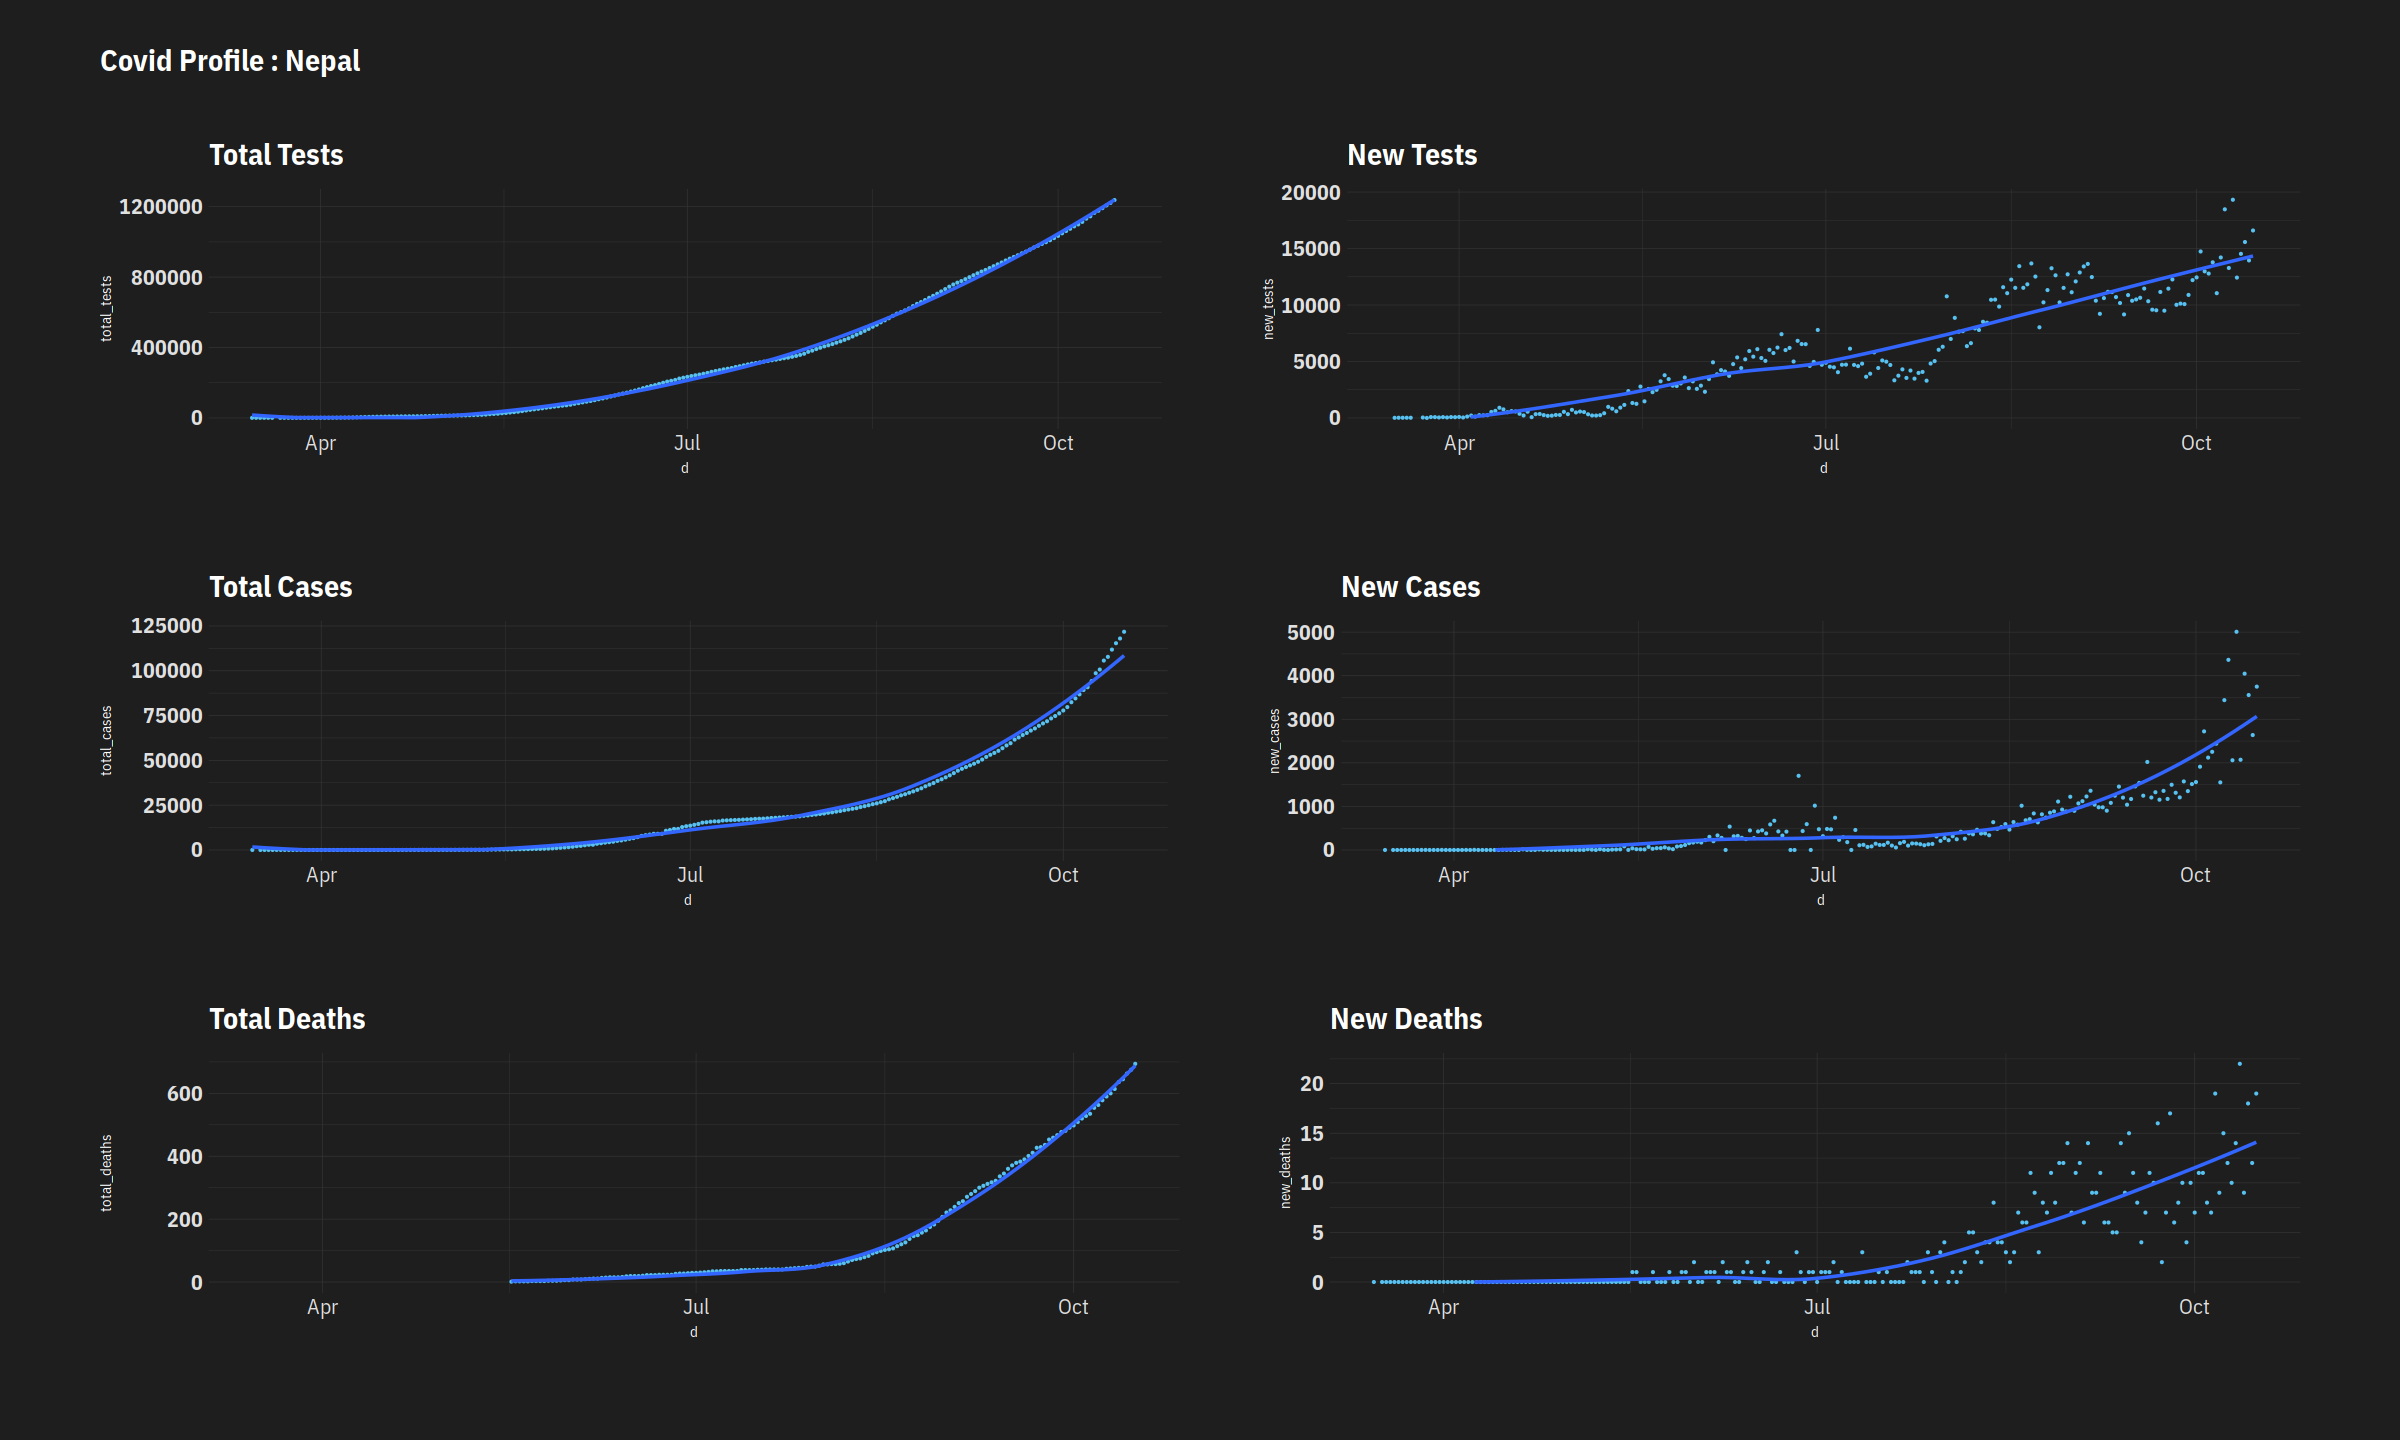

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



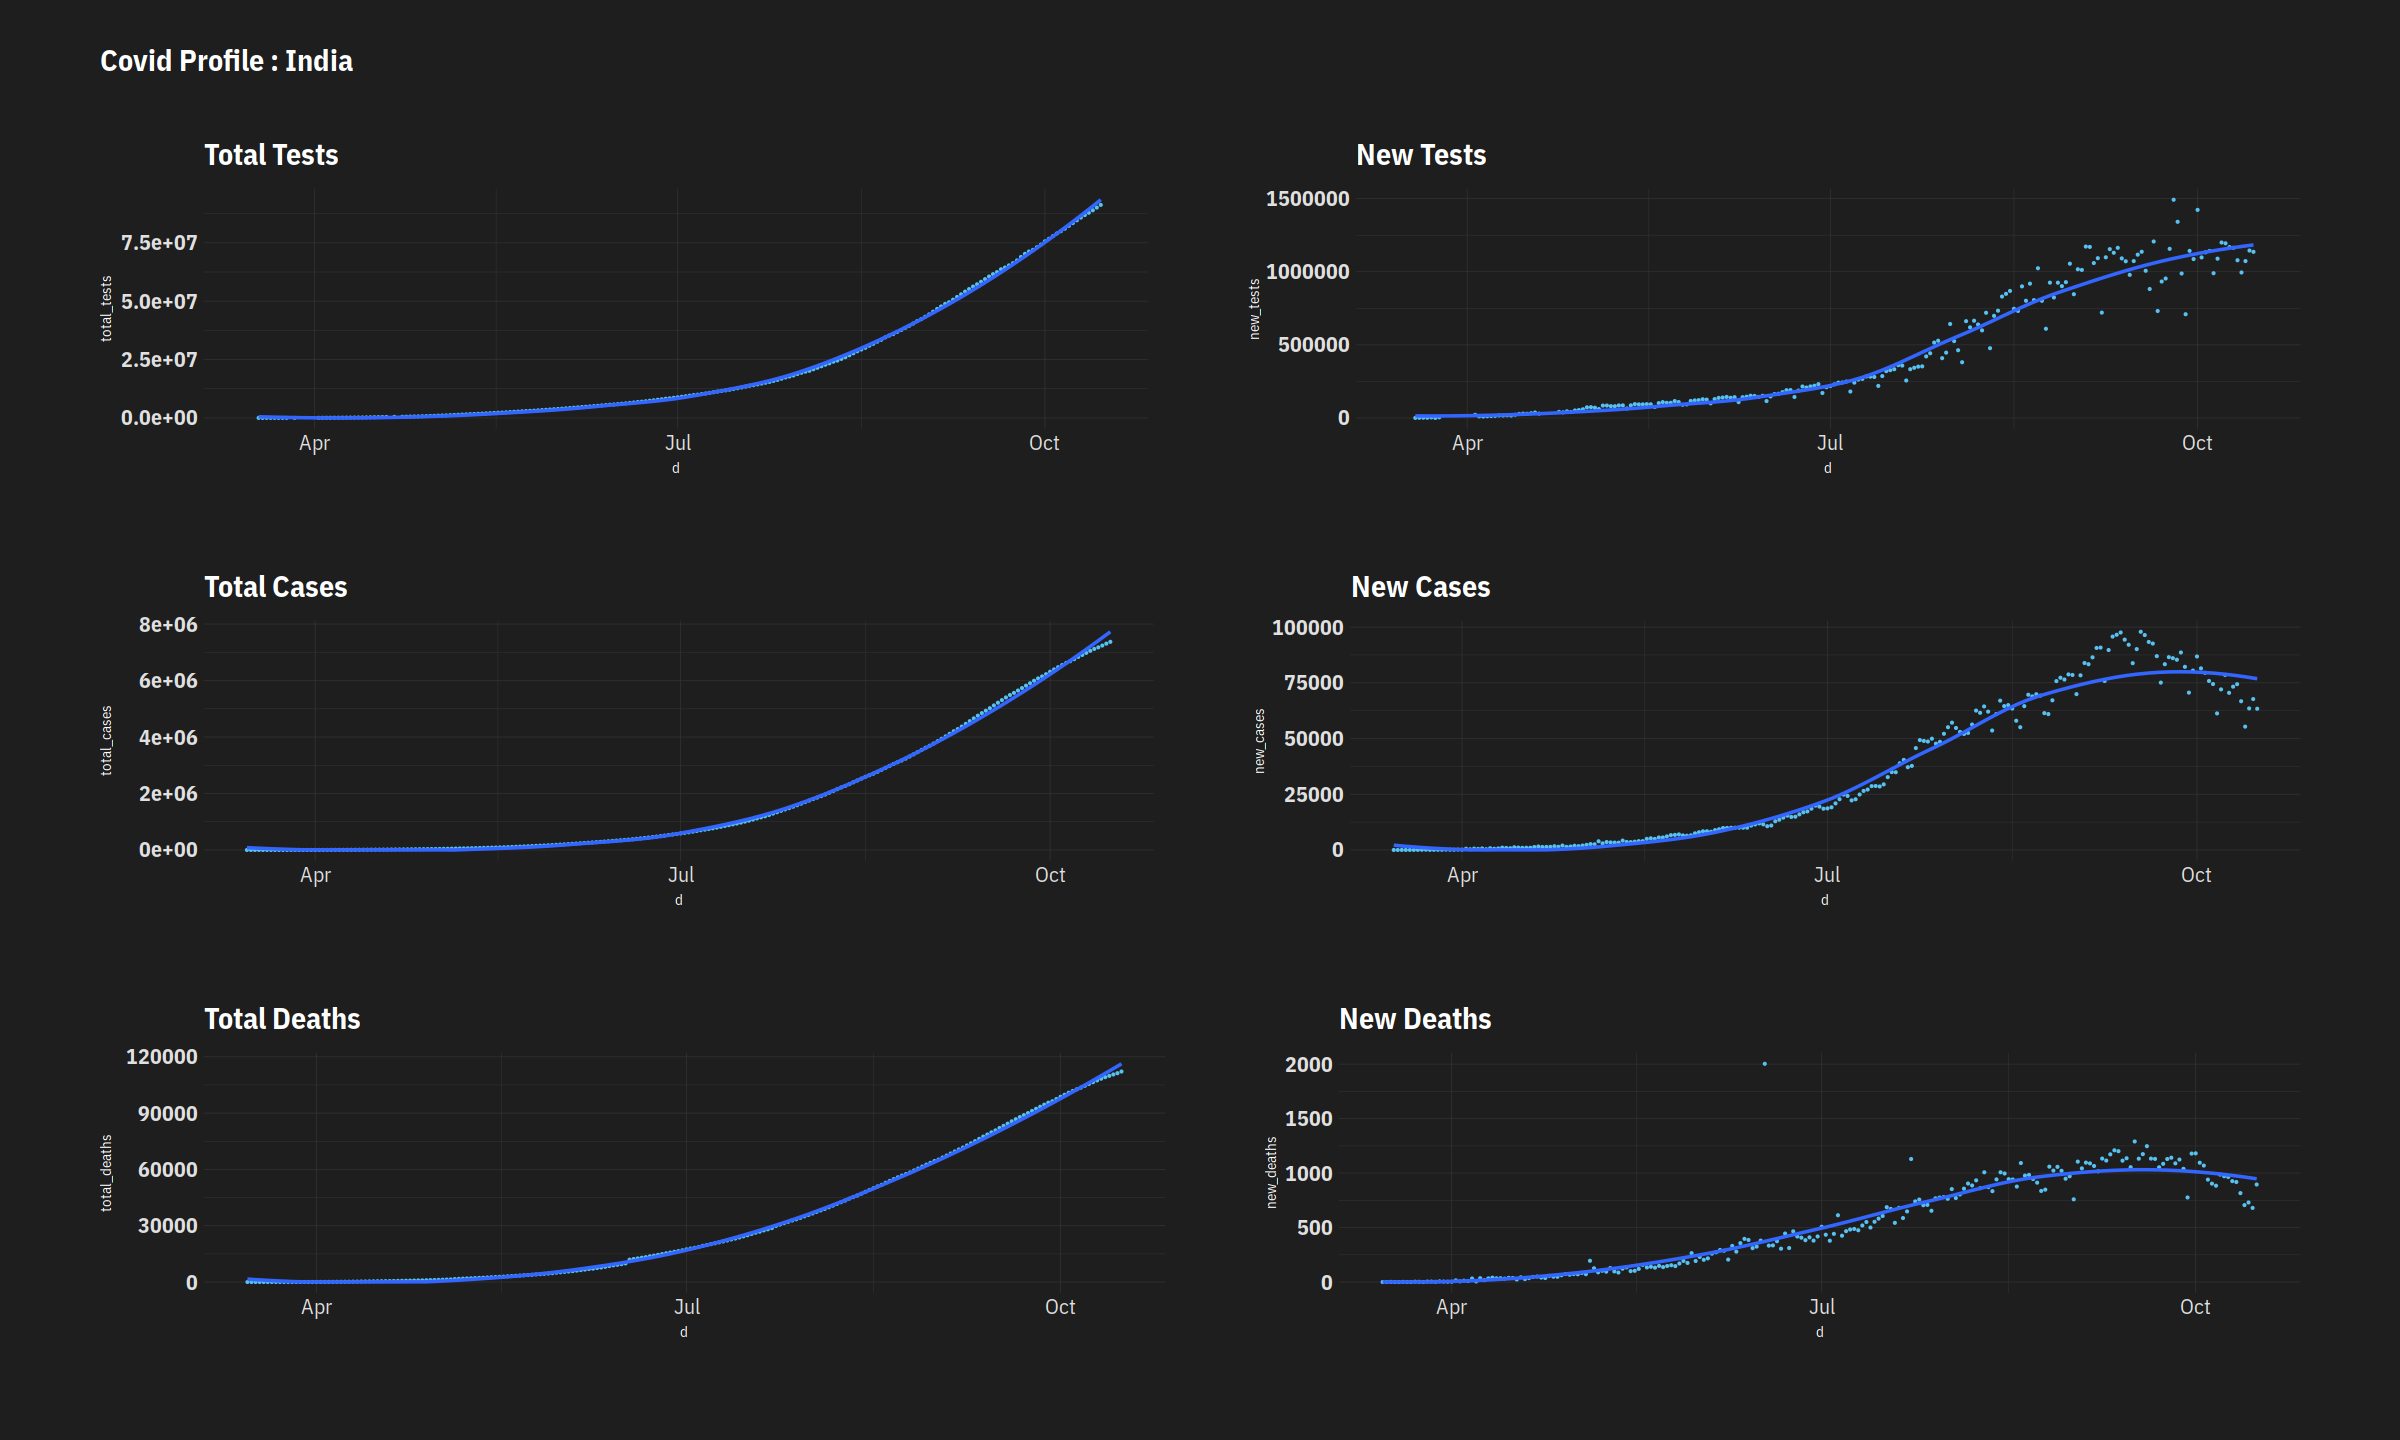

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



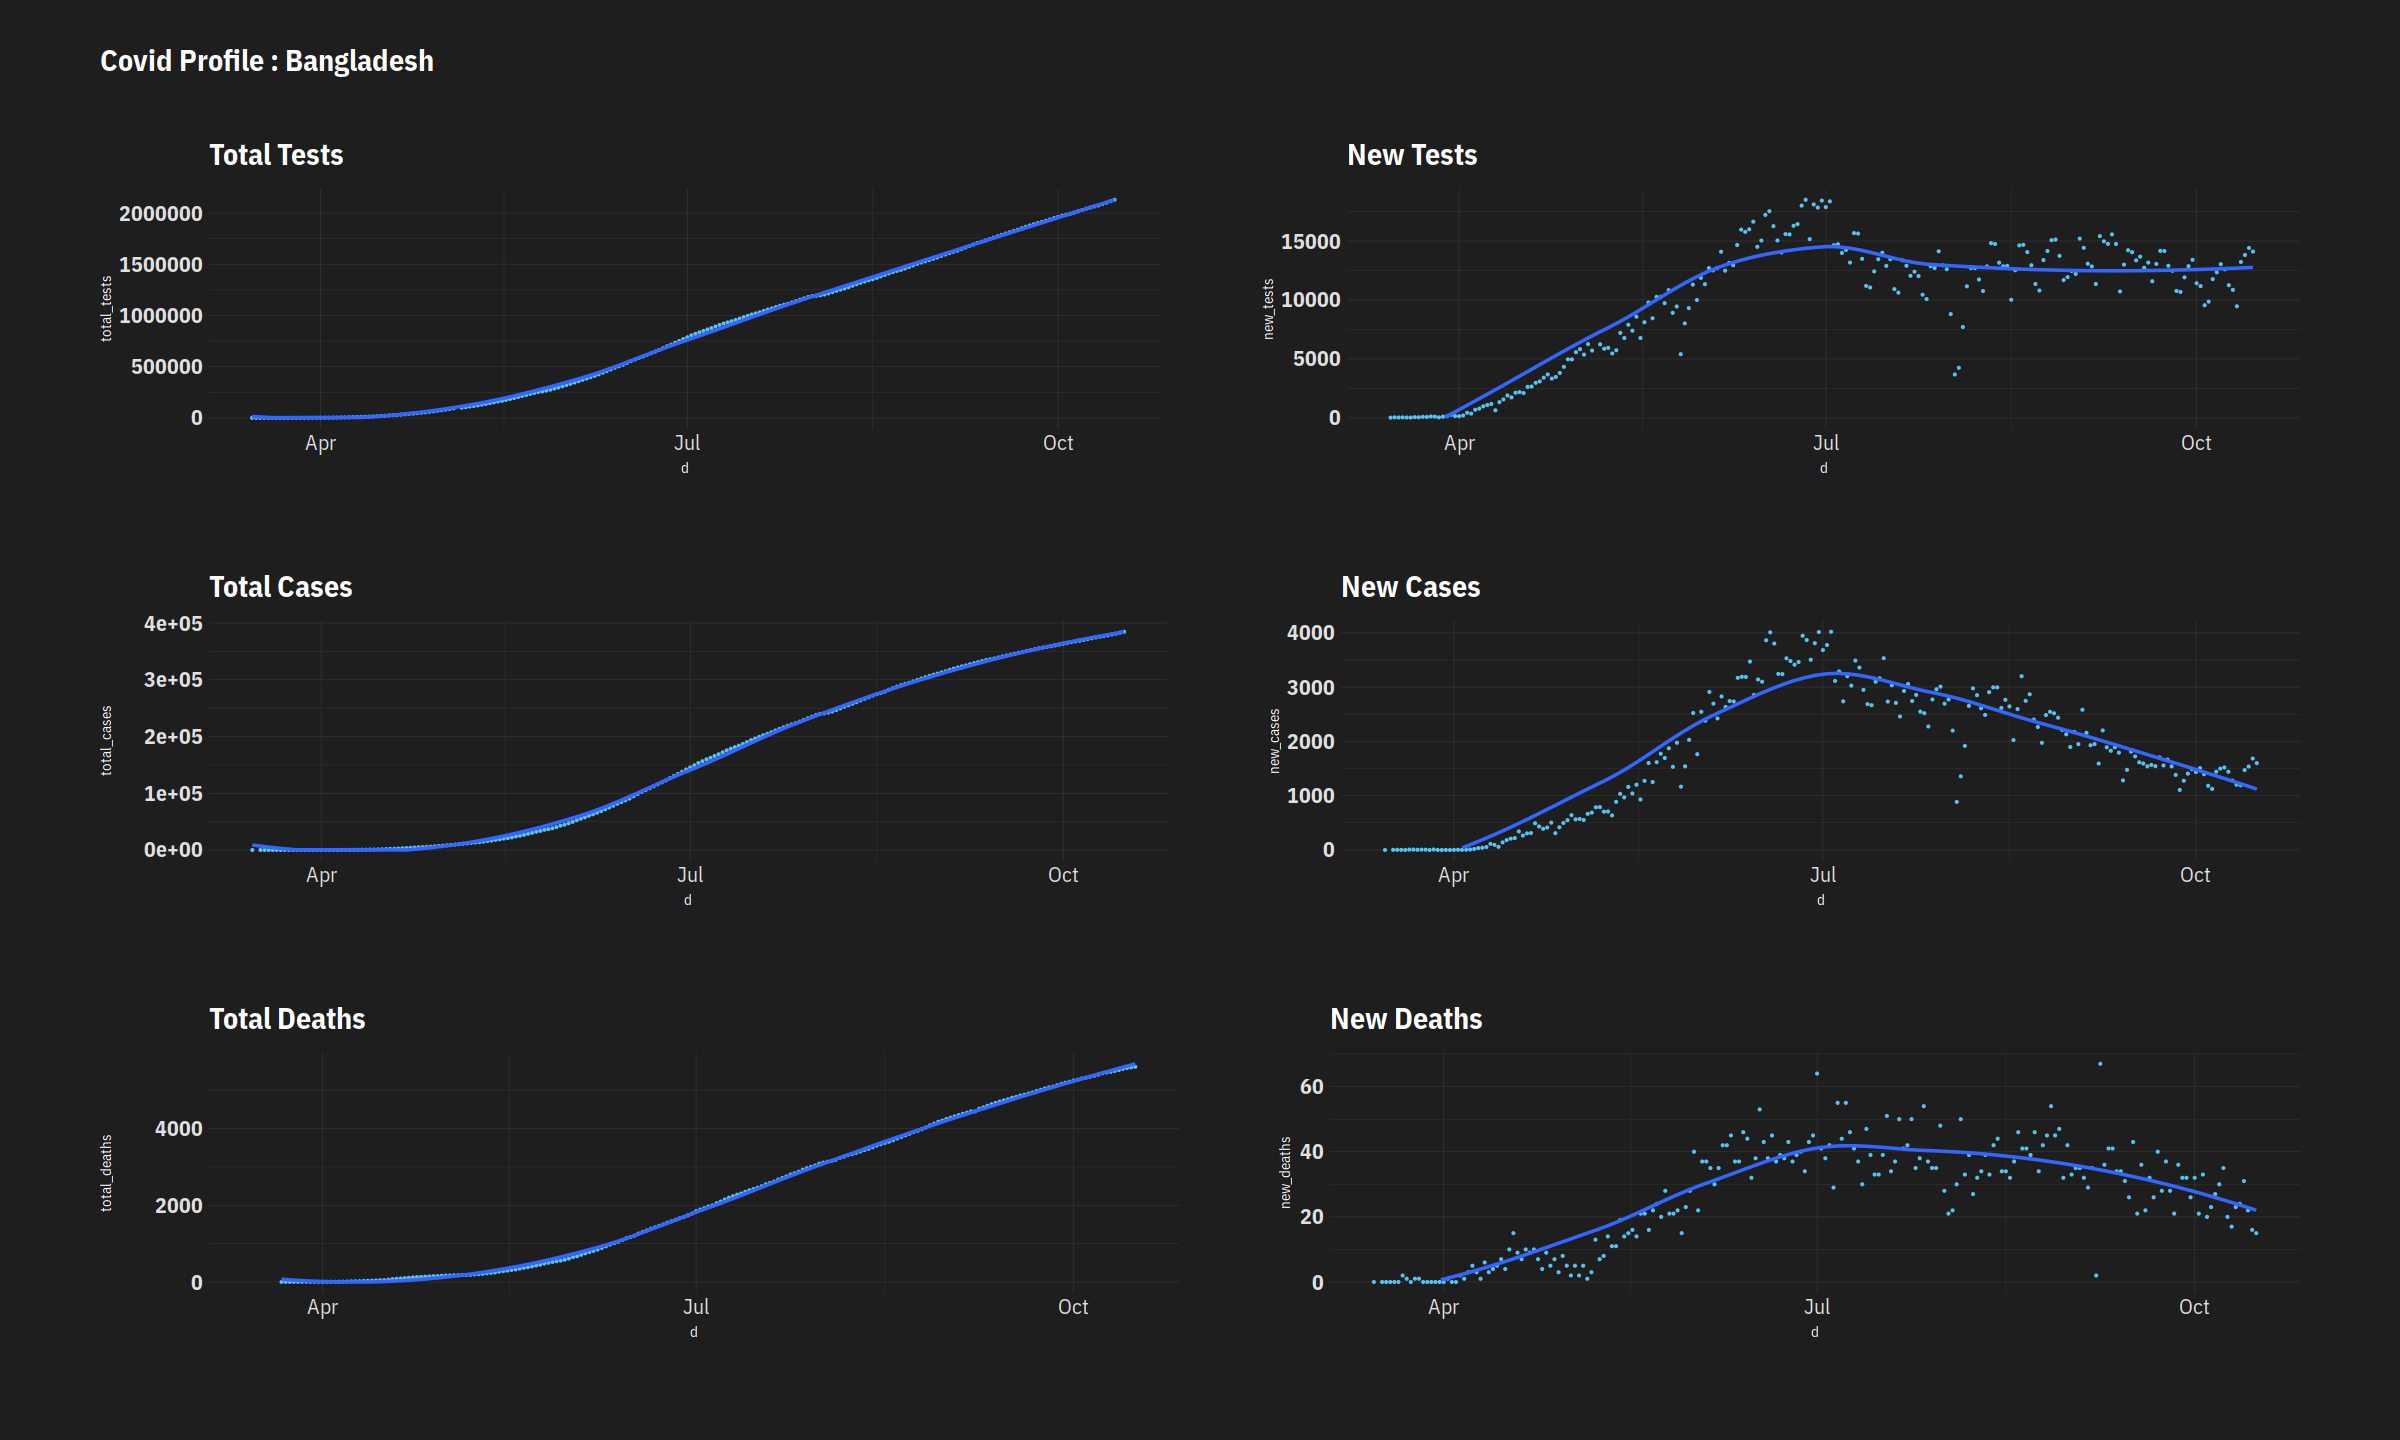

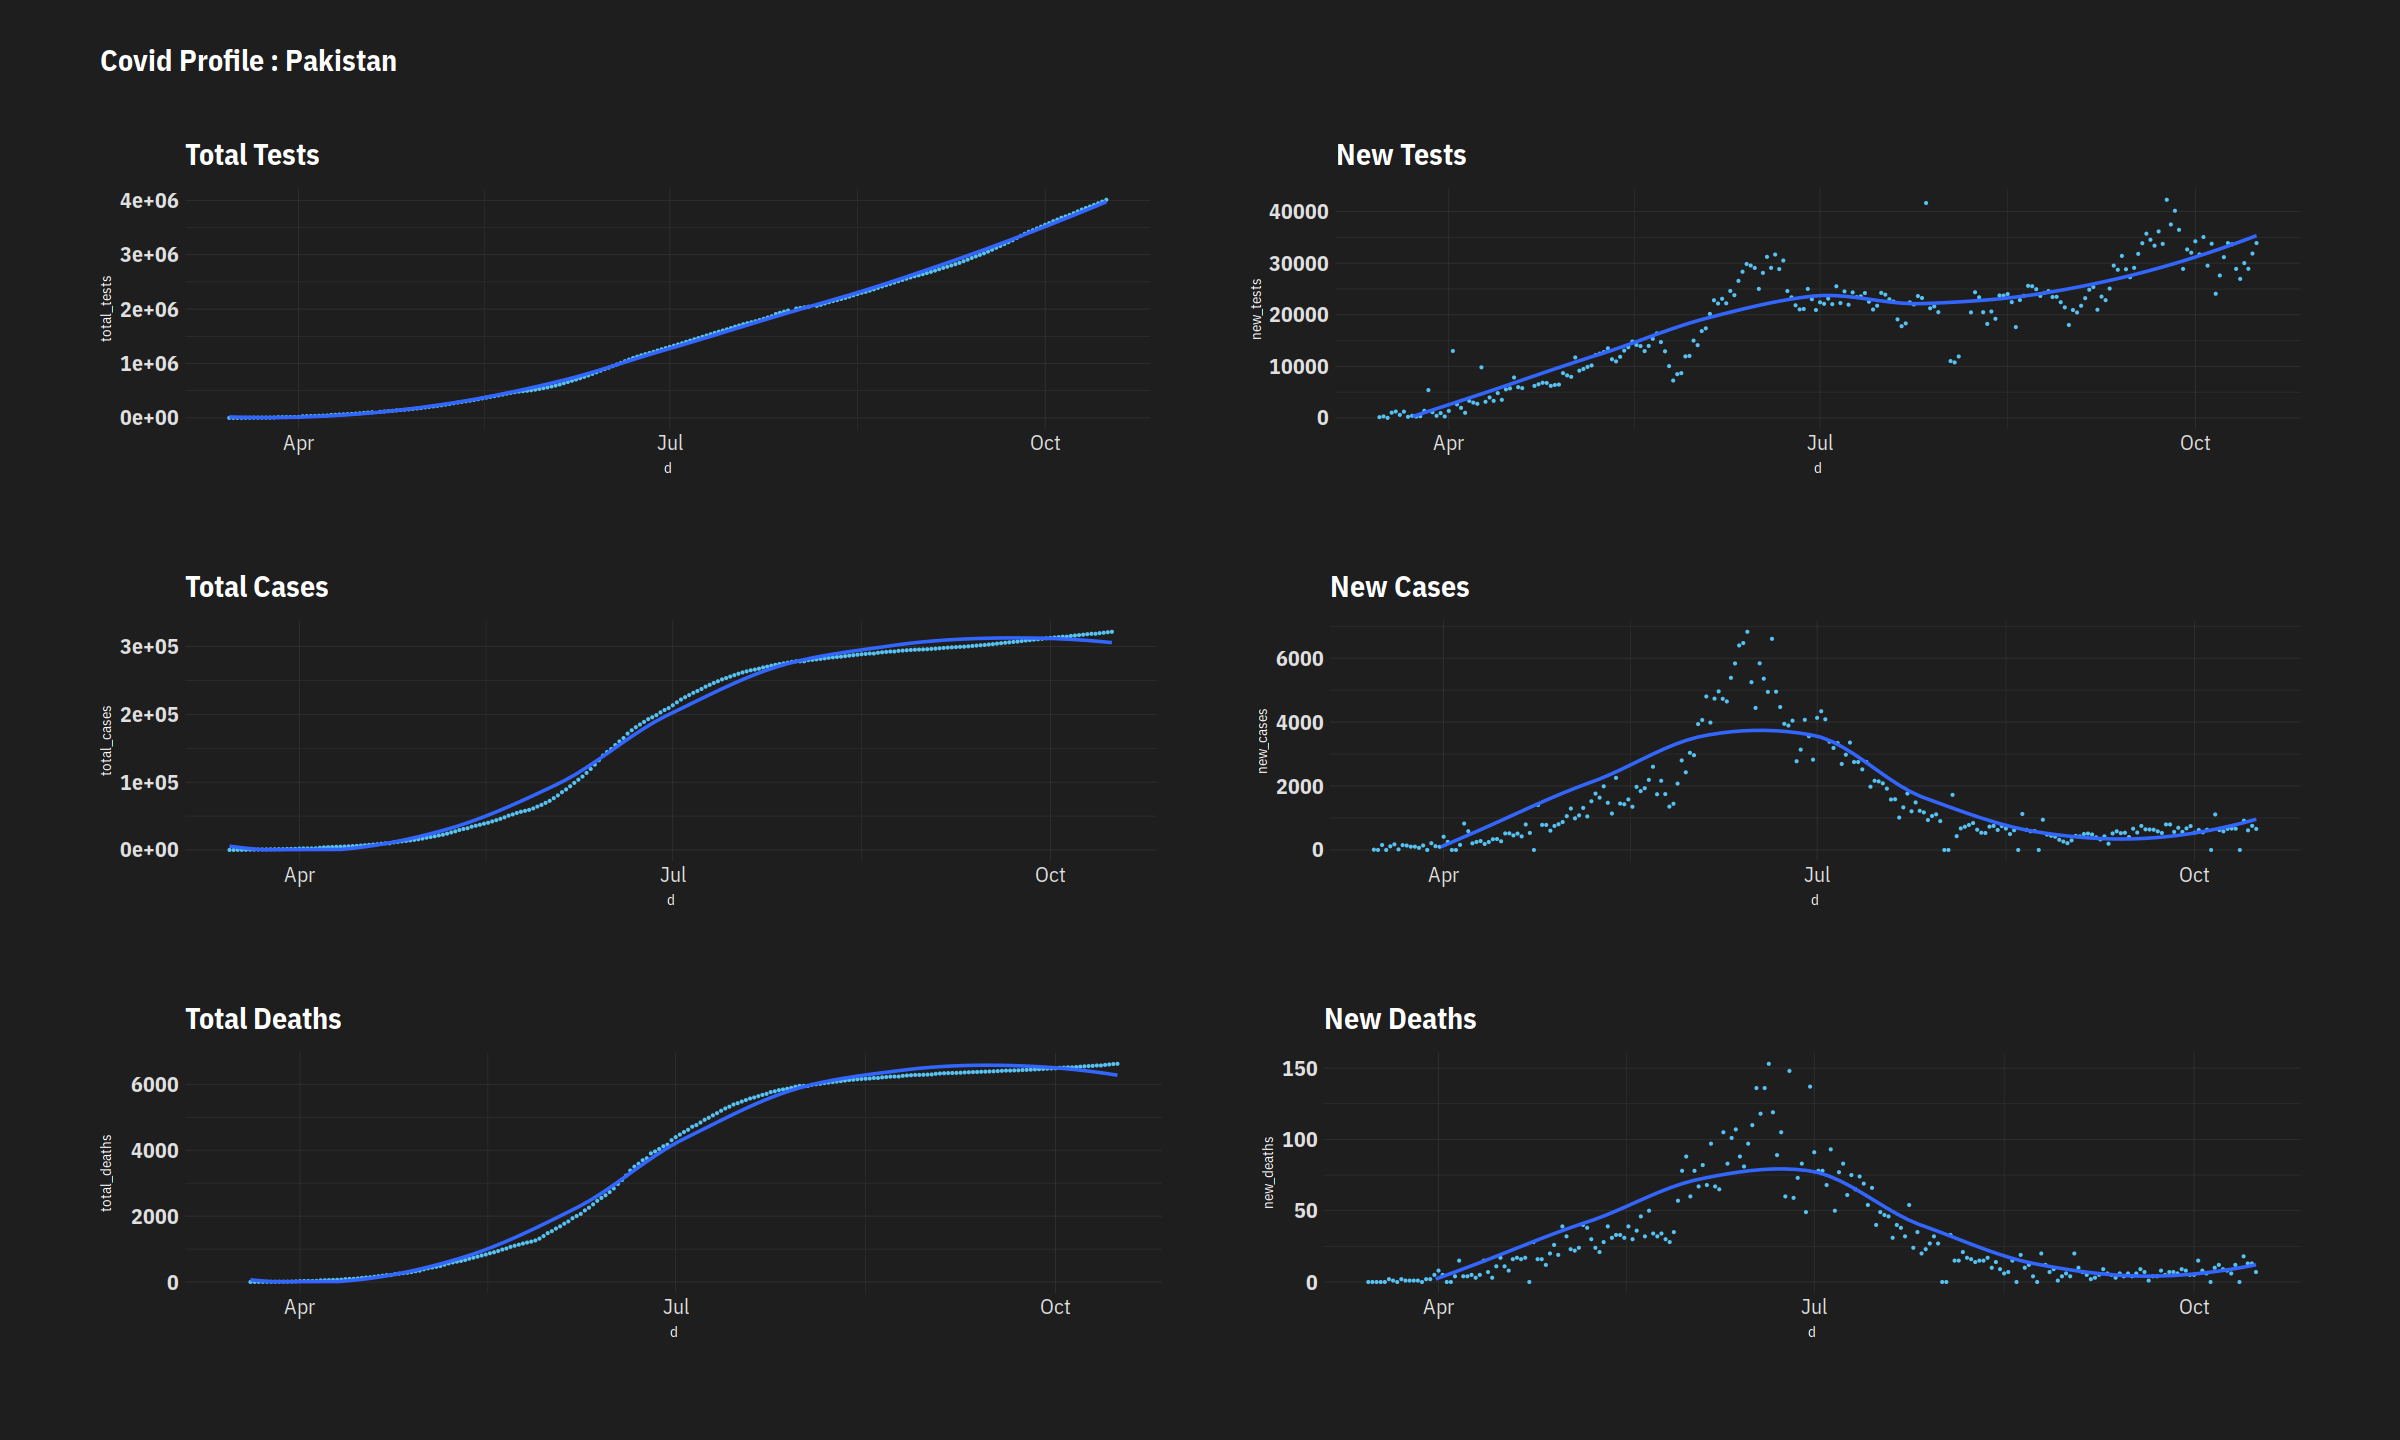

In [23]:
country_plot("Nepal") 
country_plot("India")
country_plot("Bangladesh")
country_plot("Pakistan")

## Sub-Saharan Africa

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



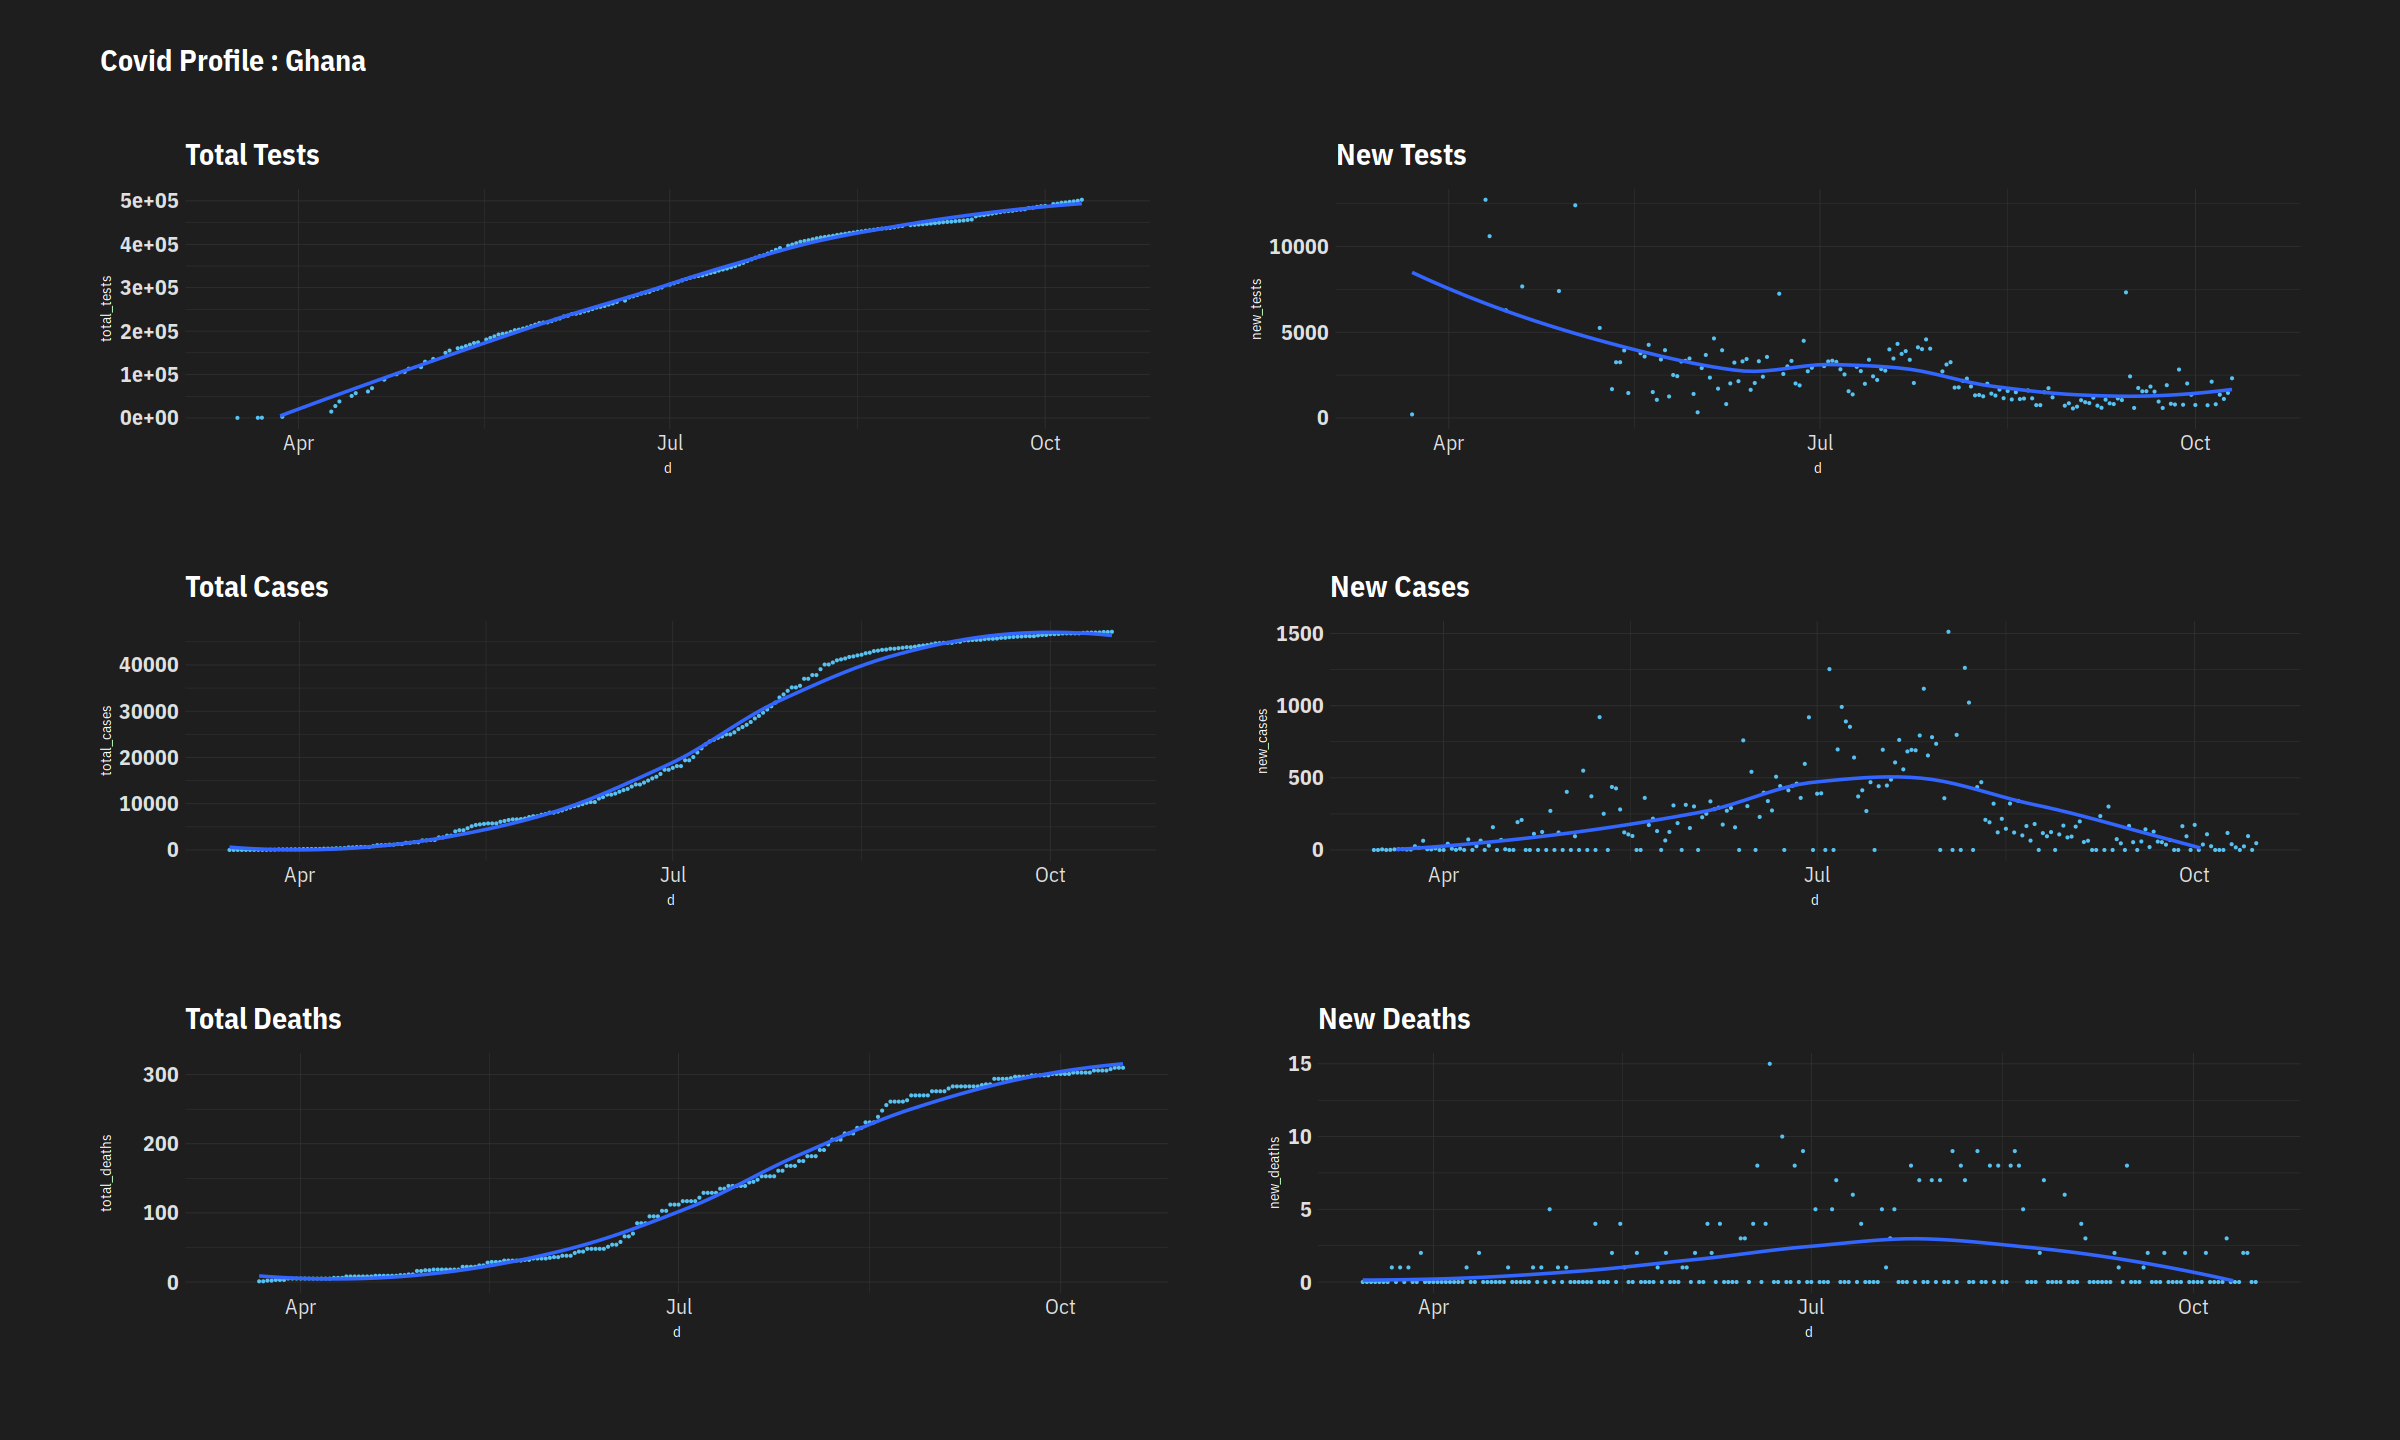

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



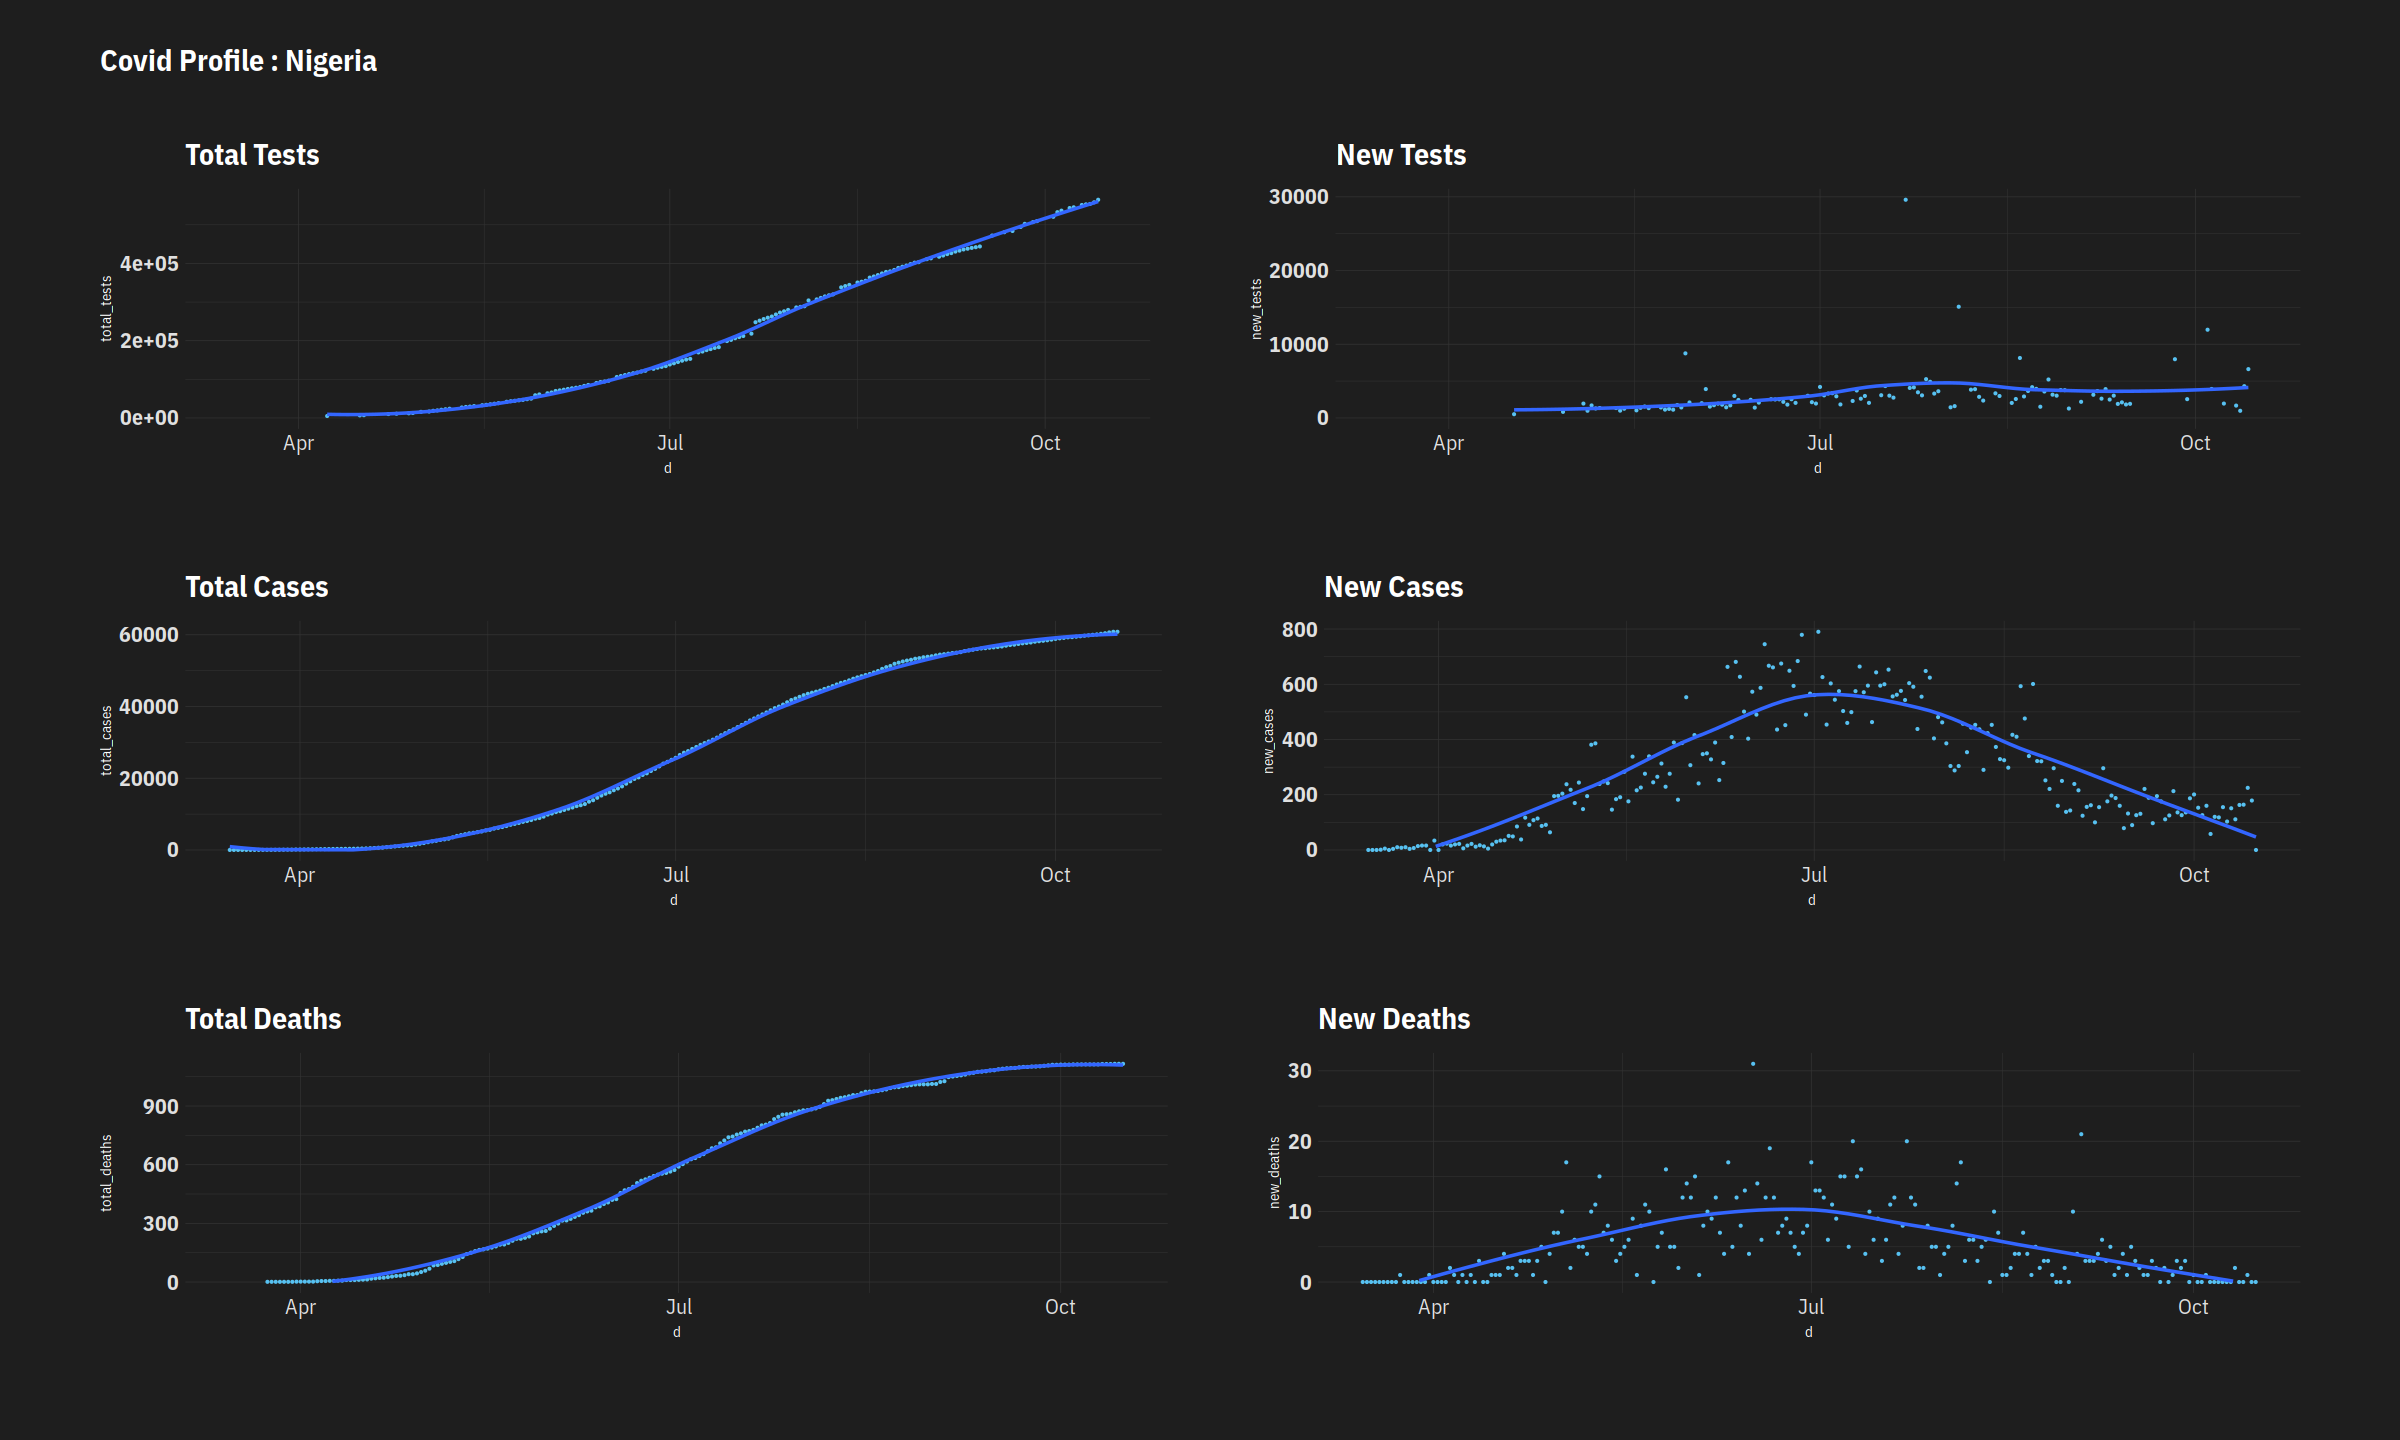

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



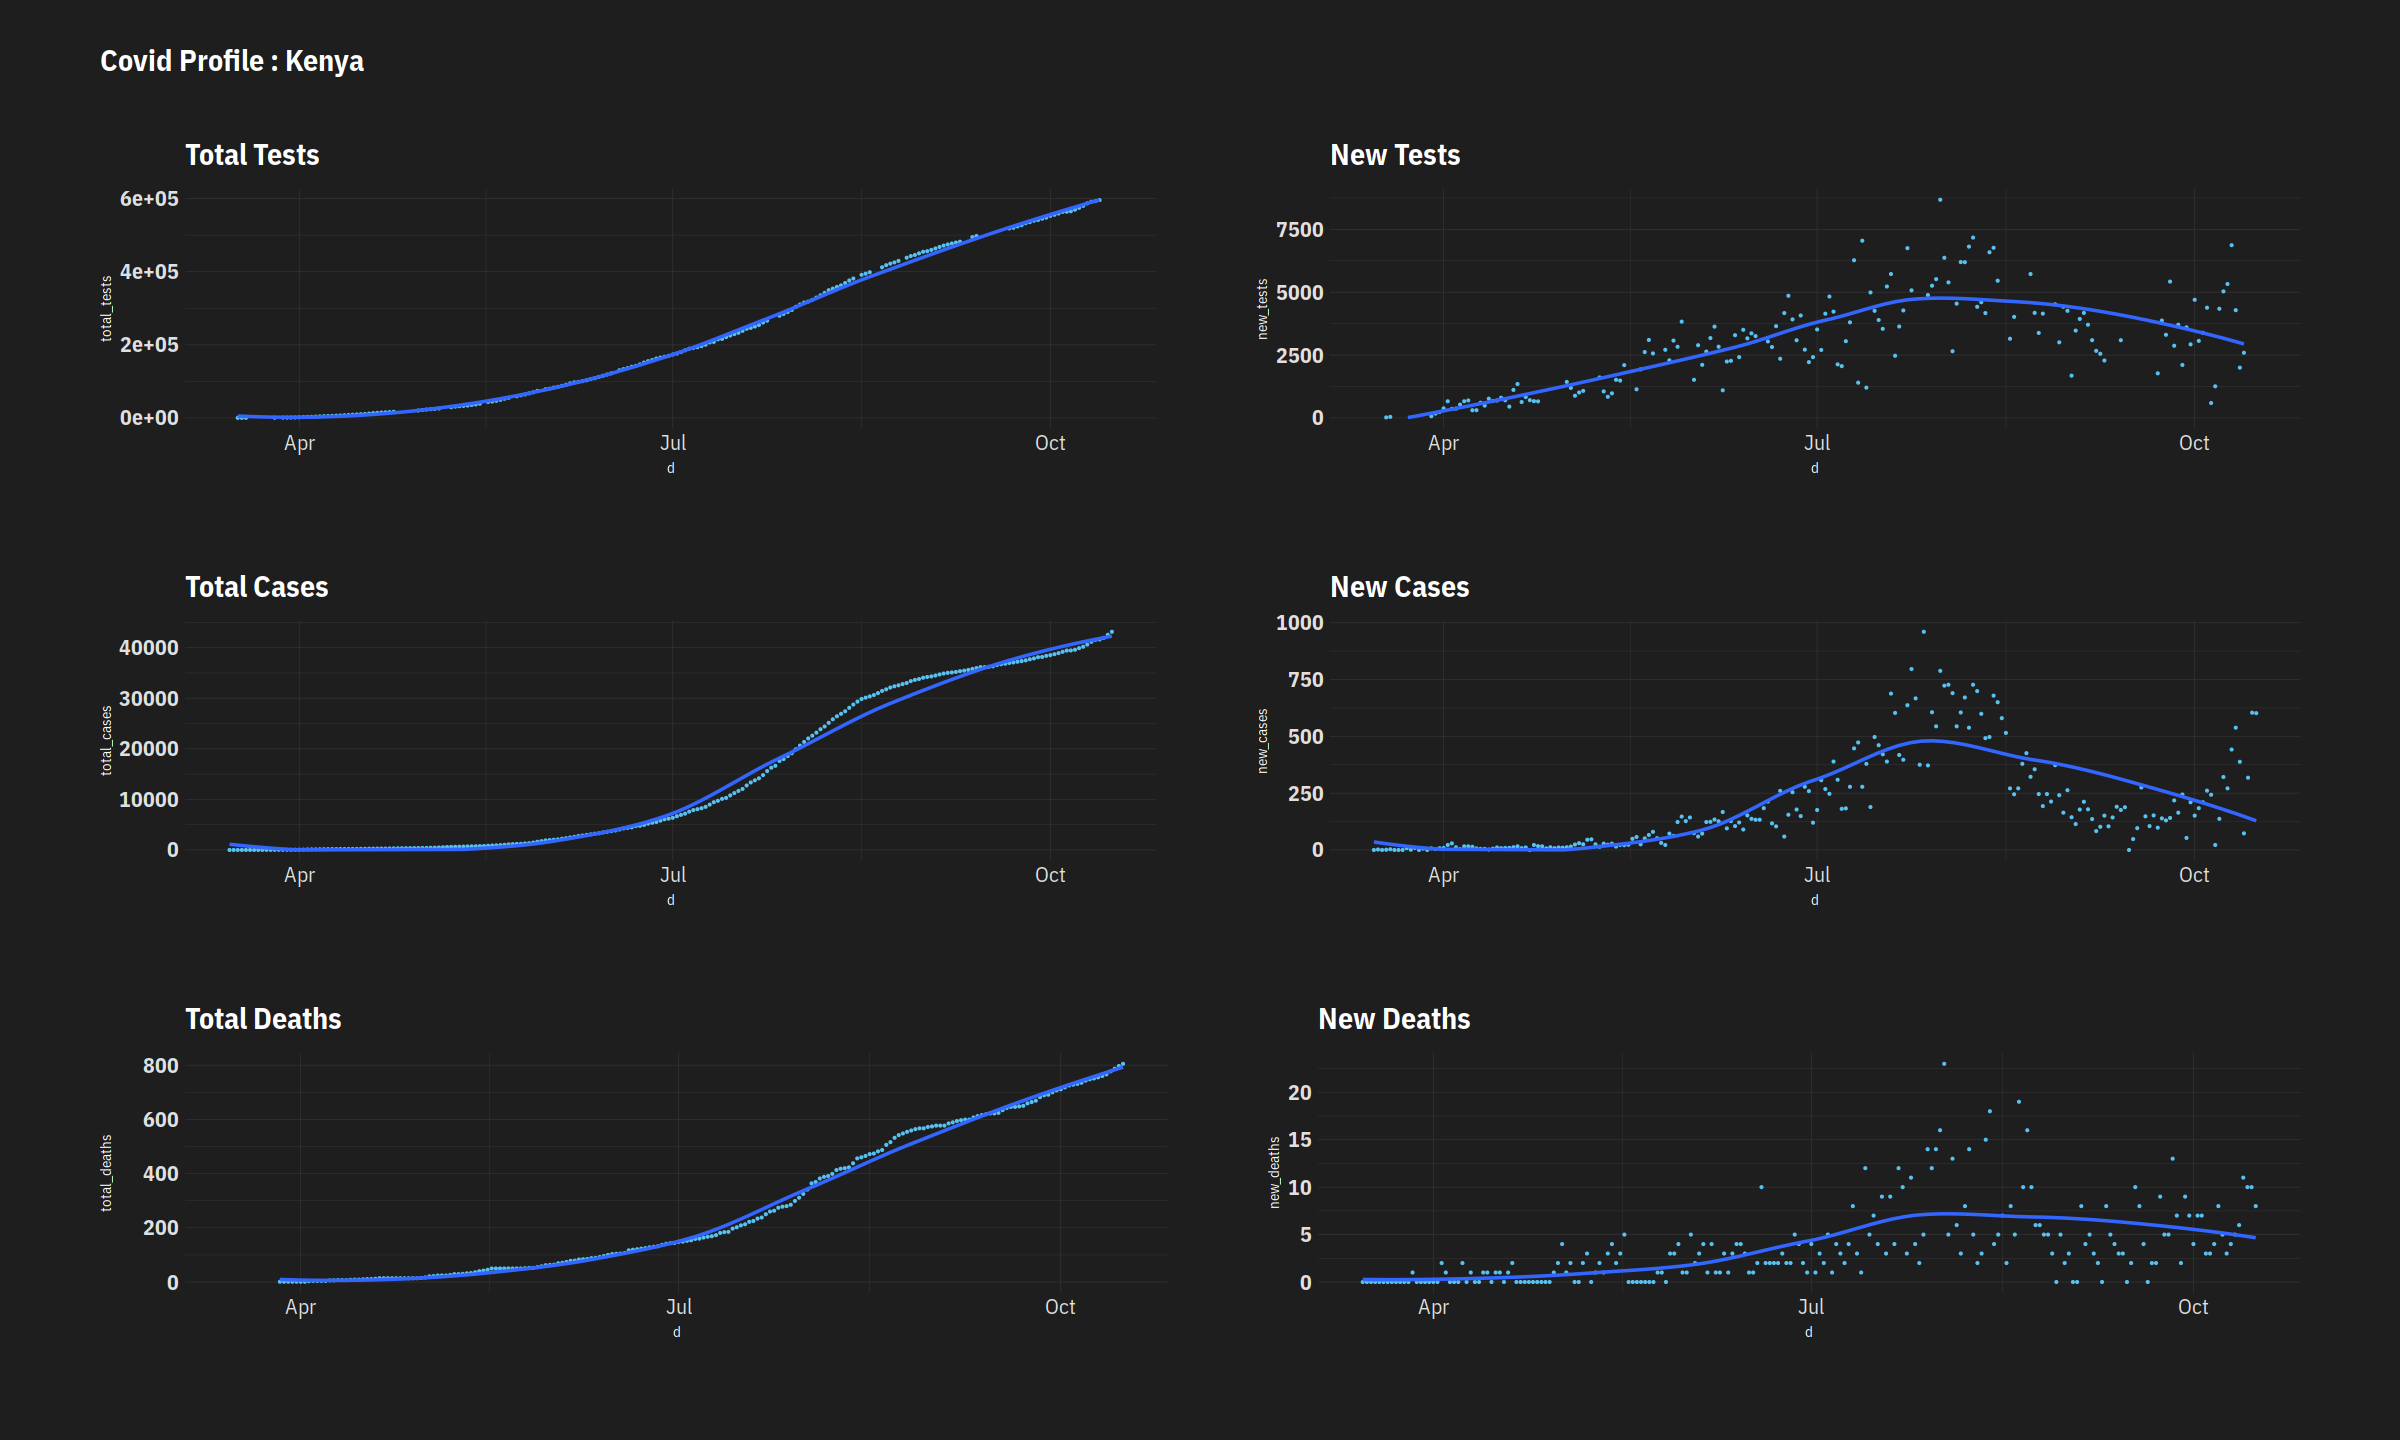

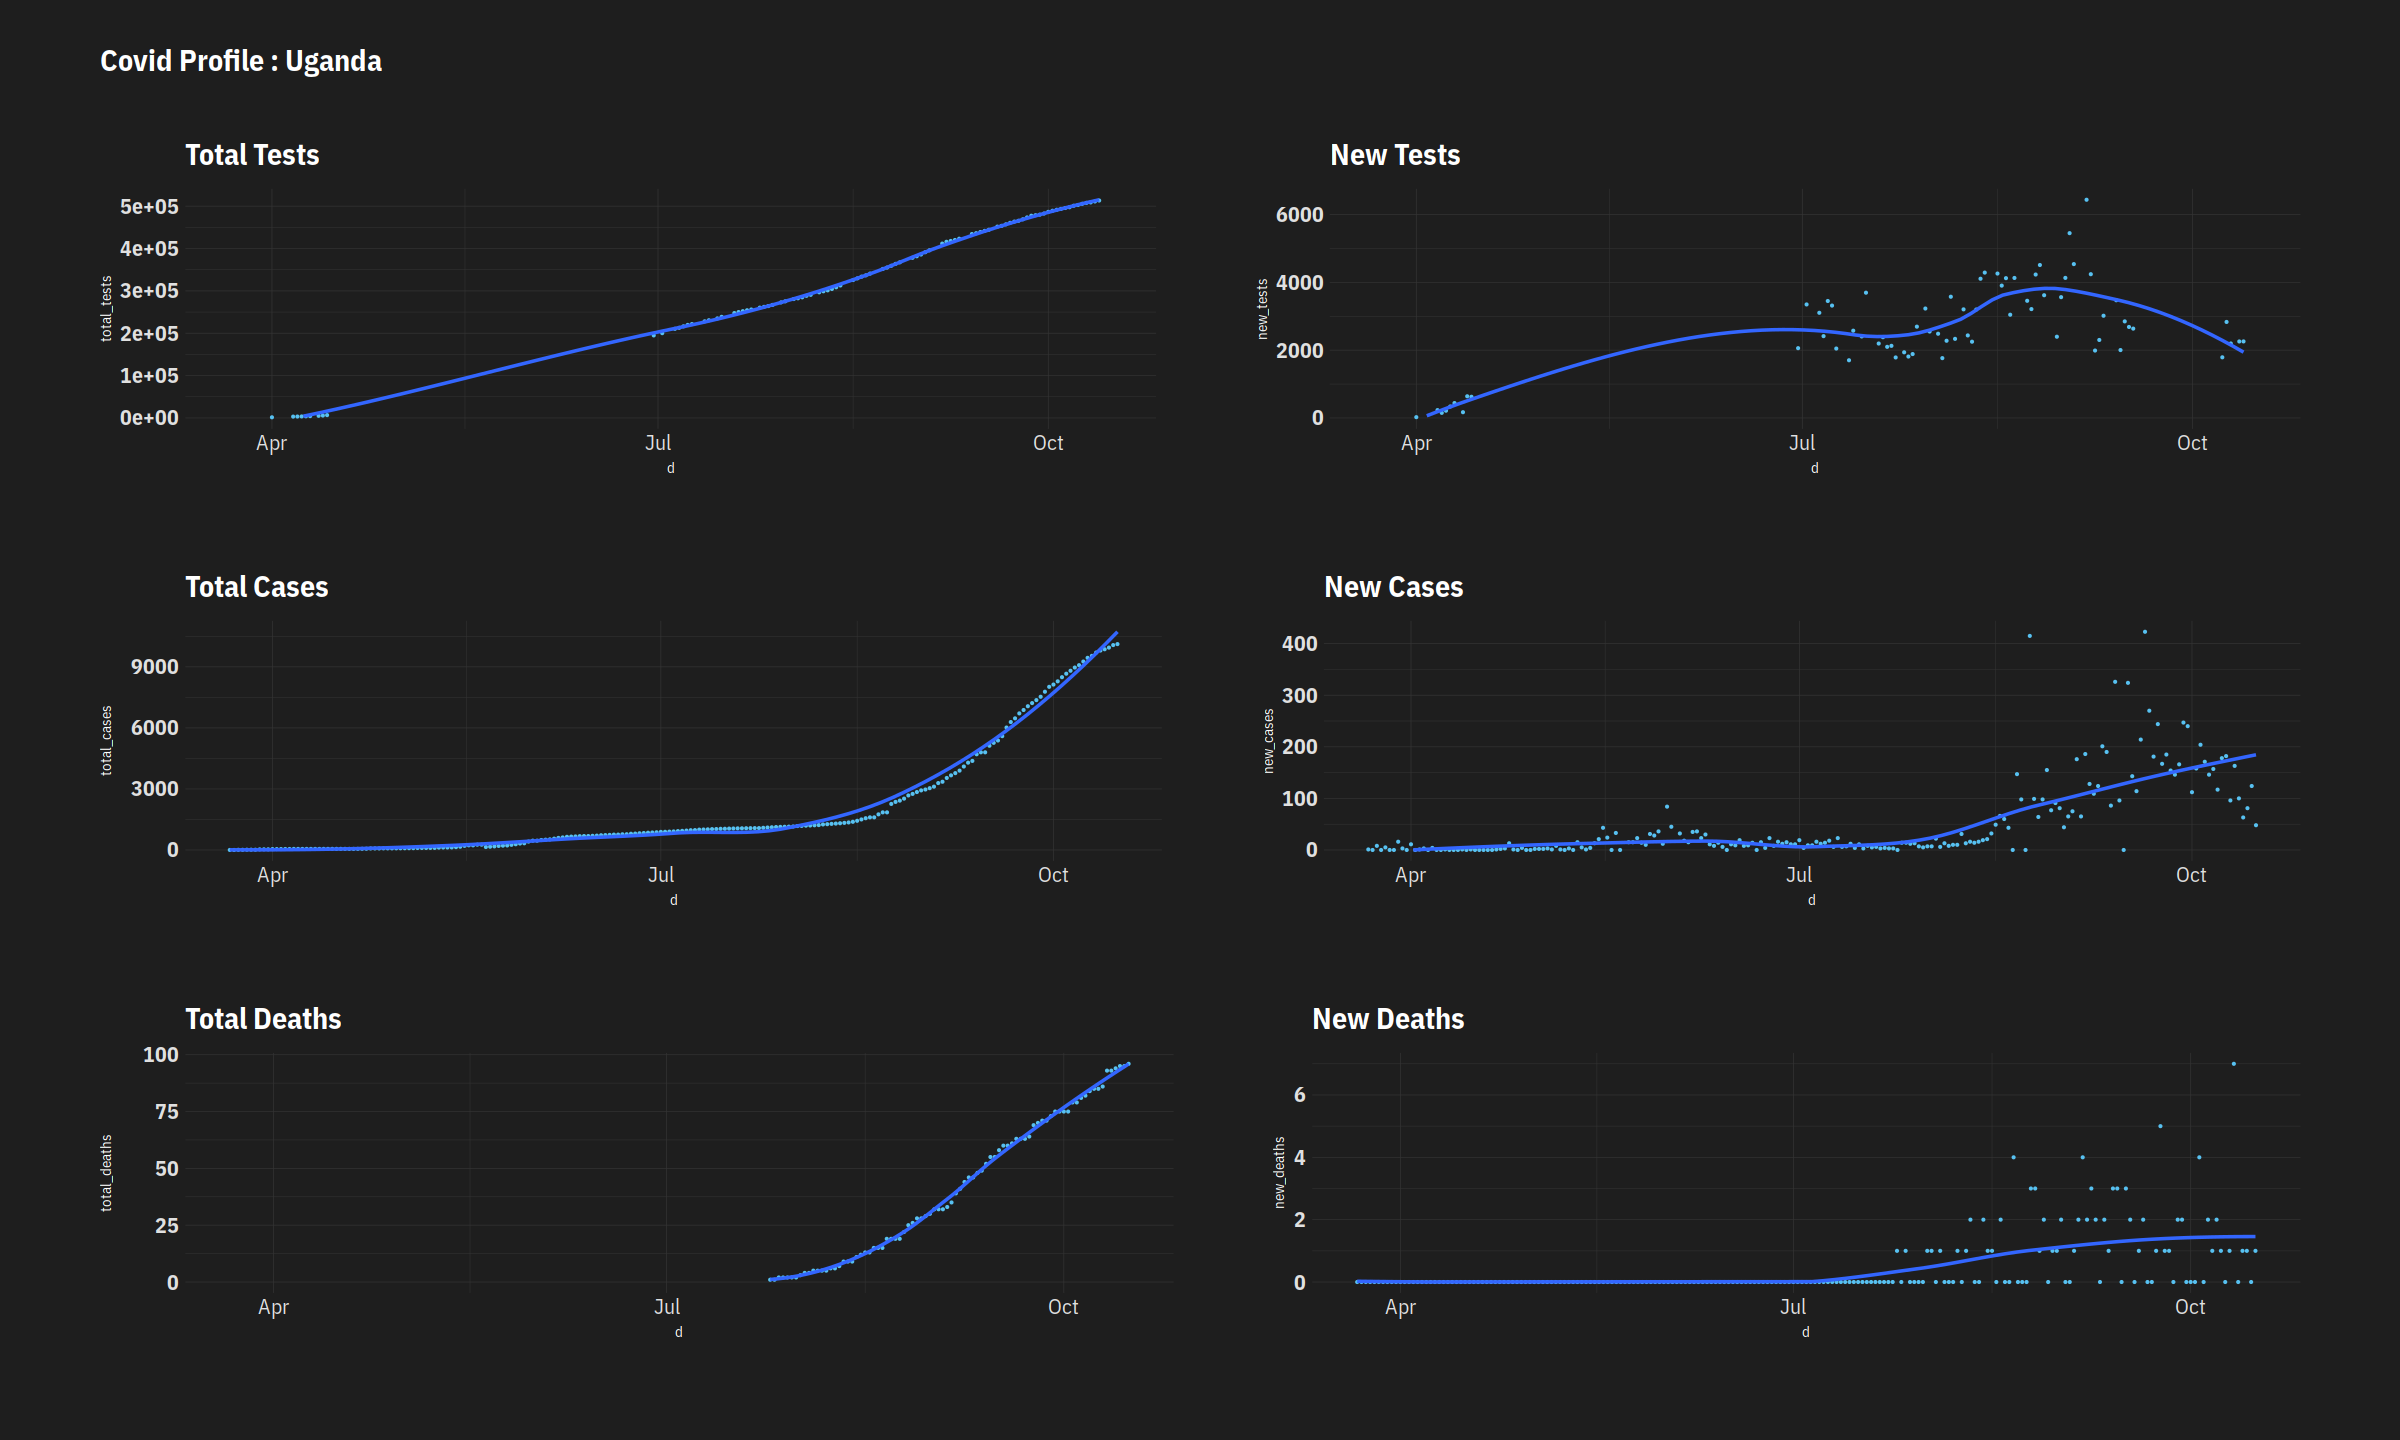

In [24]:
country_plot("Ghana")
country_plot("Nigeria")
country_plot("Kenya")
country_plot("Uganda")

## Eastern Europe

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



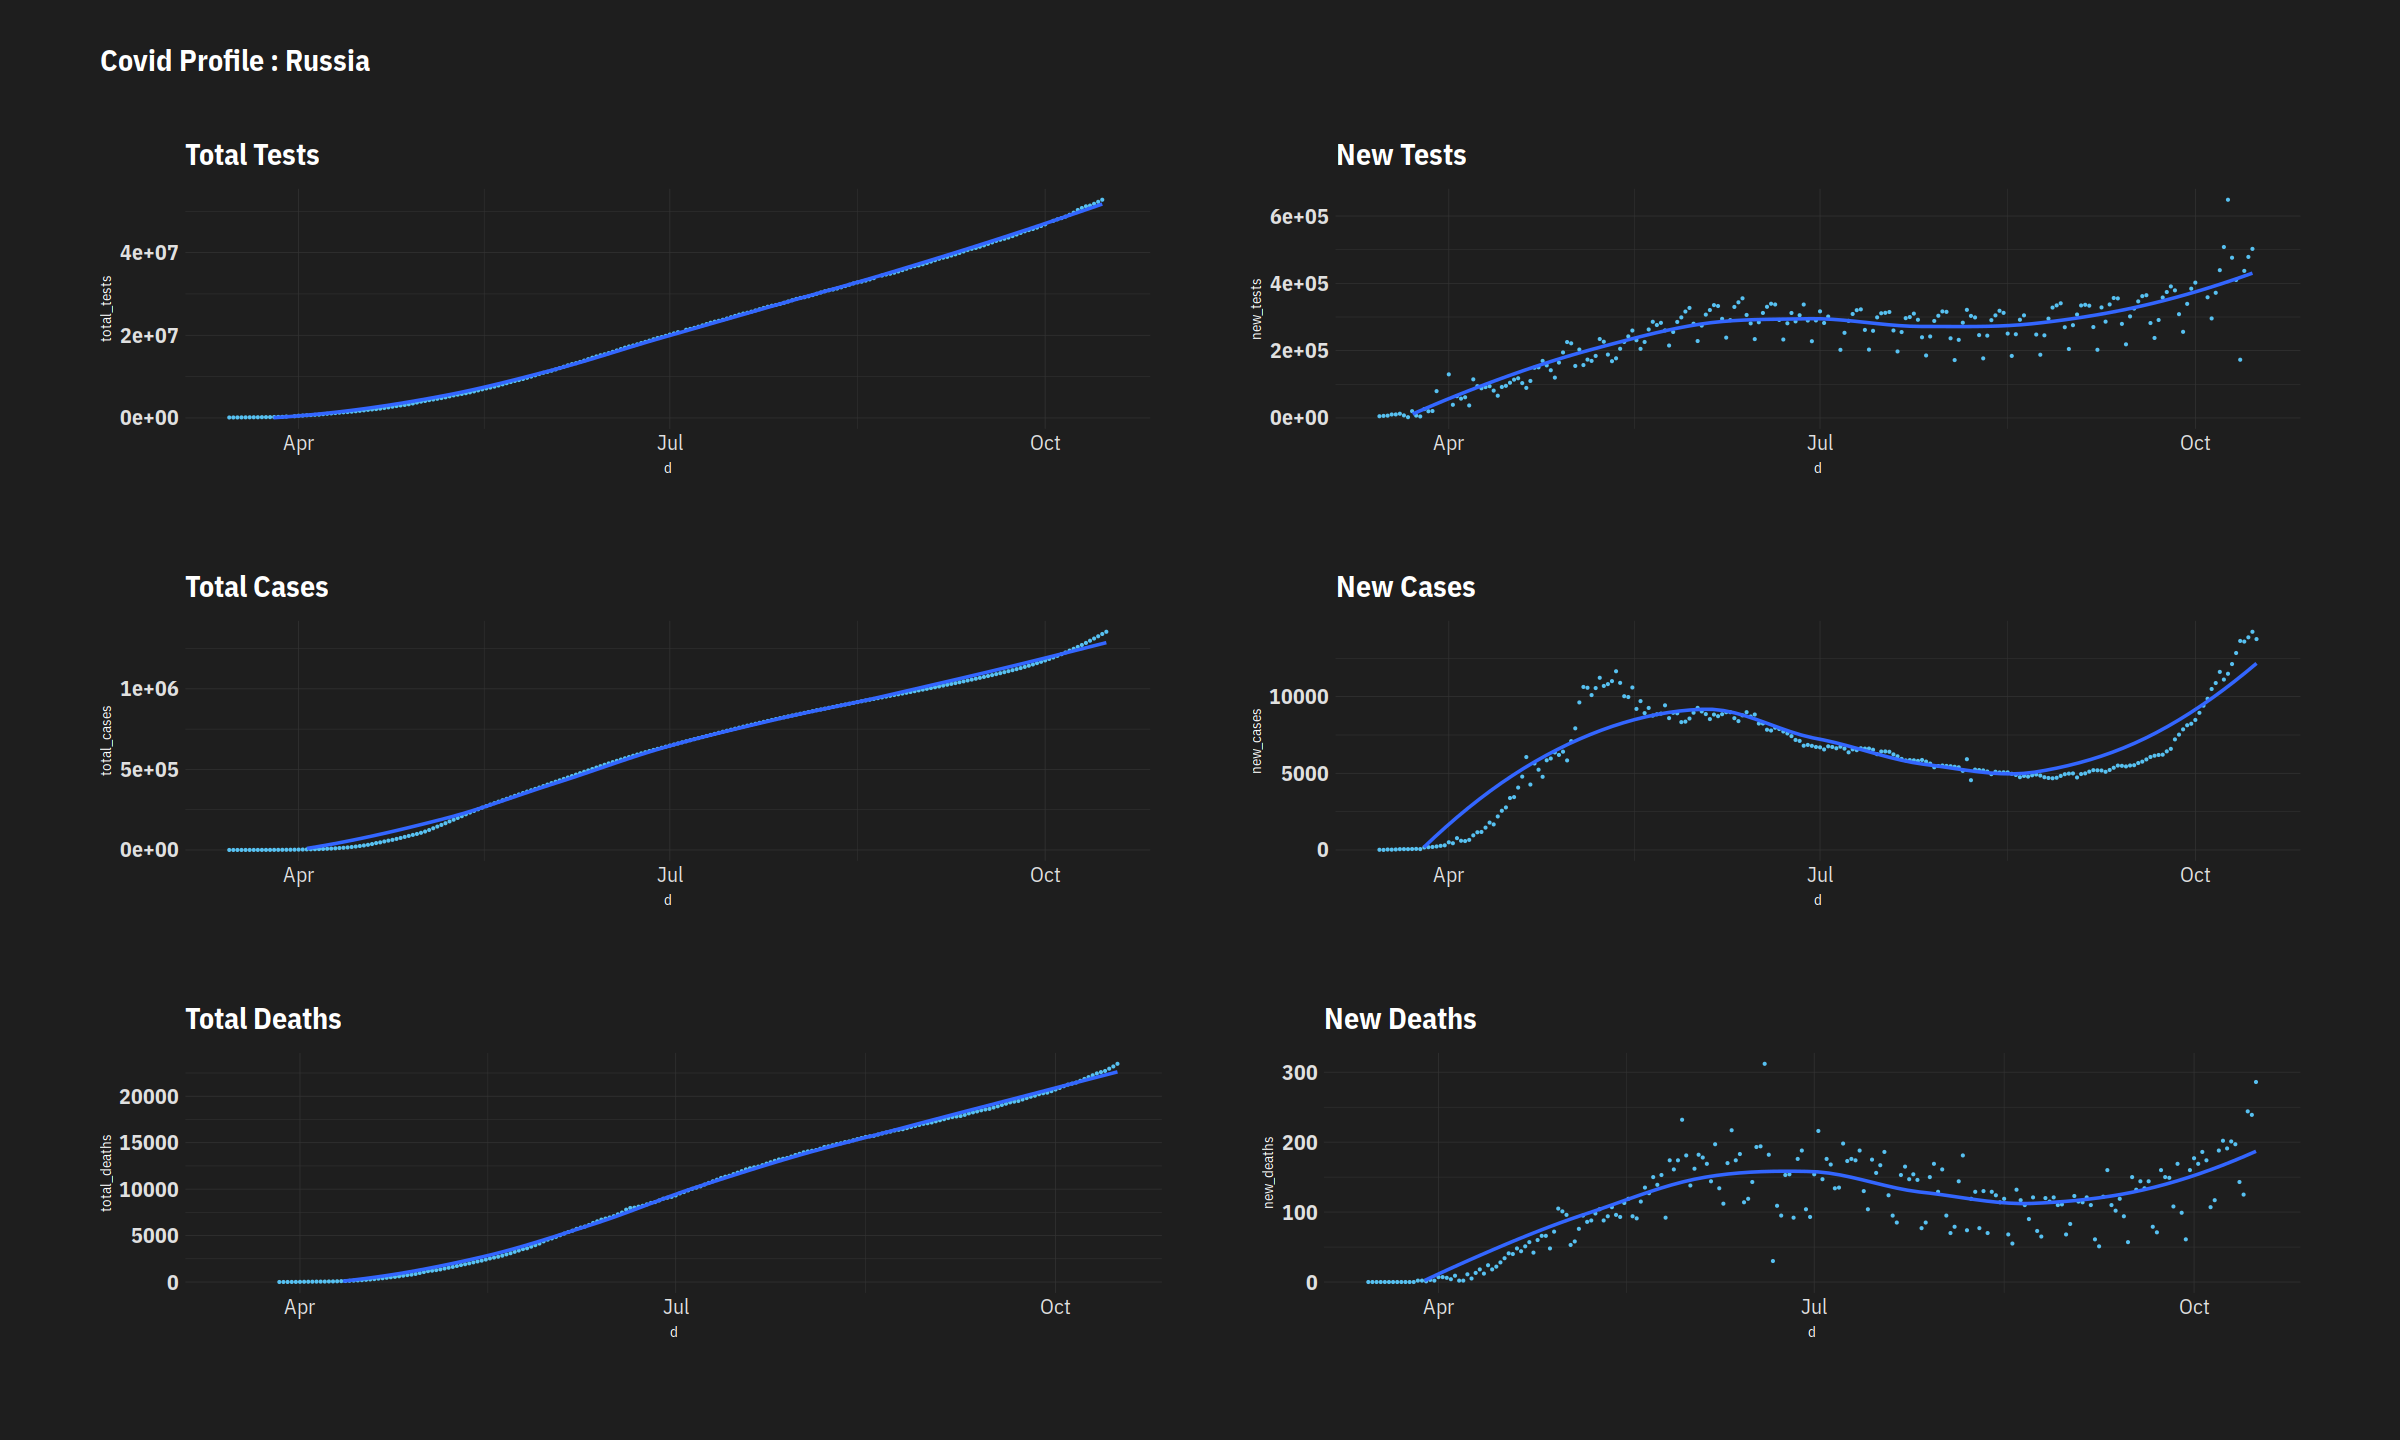

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



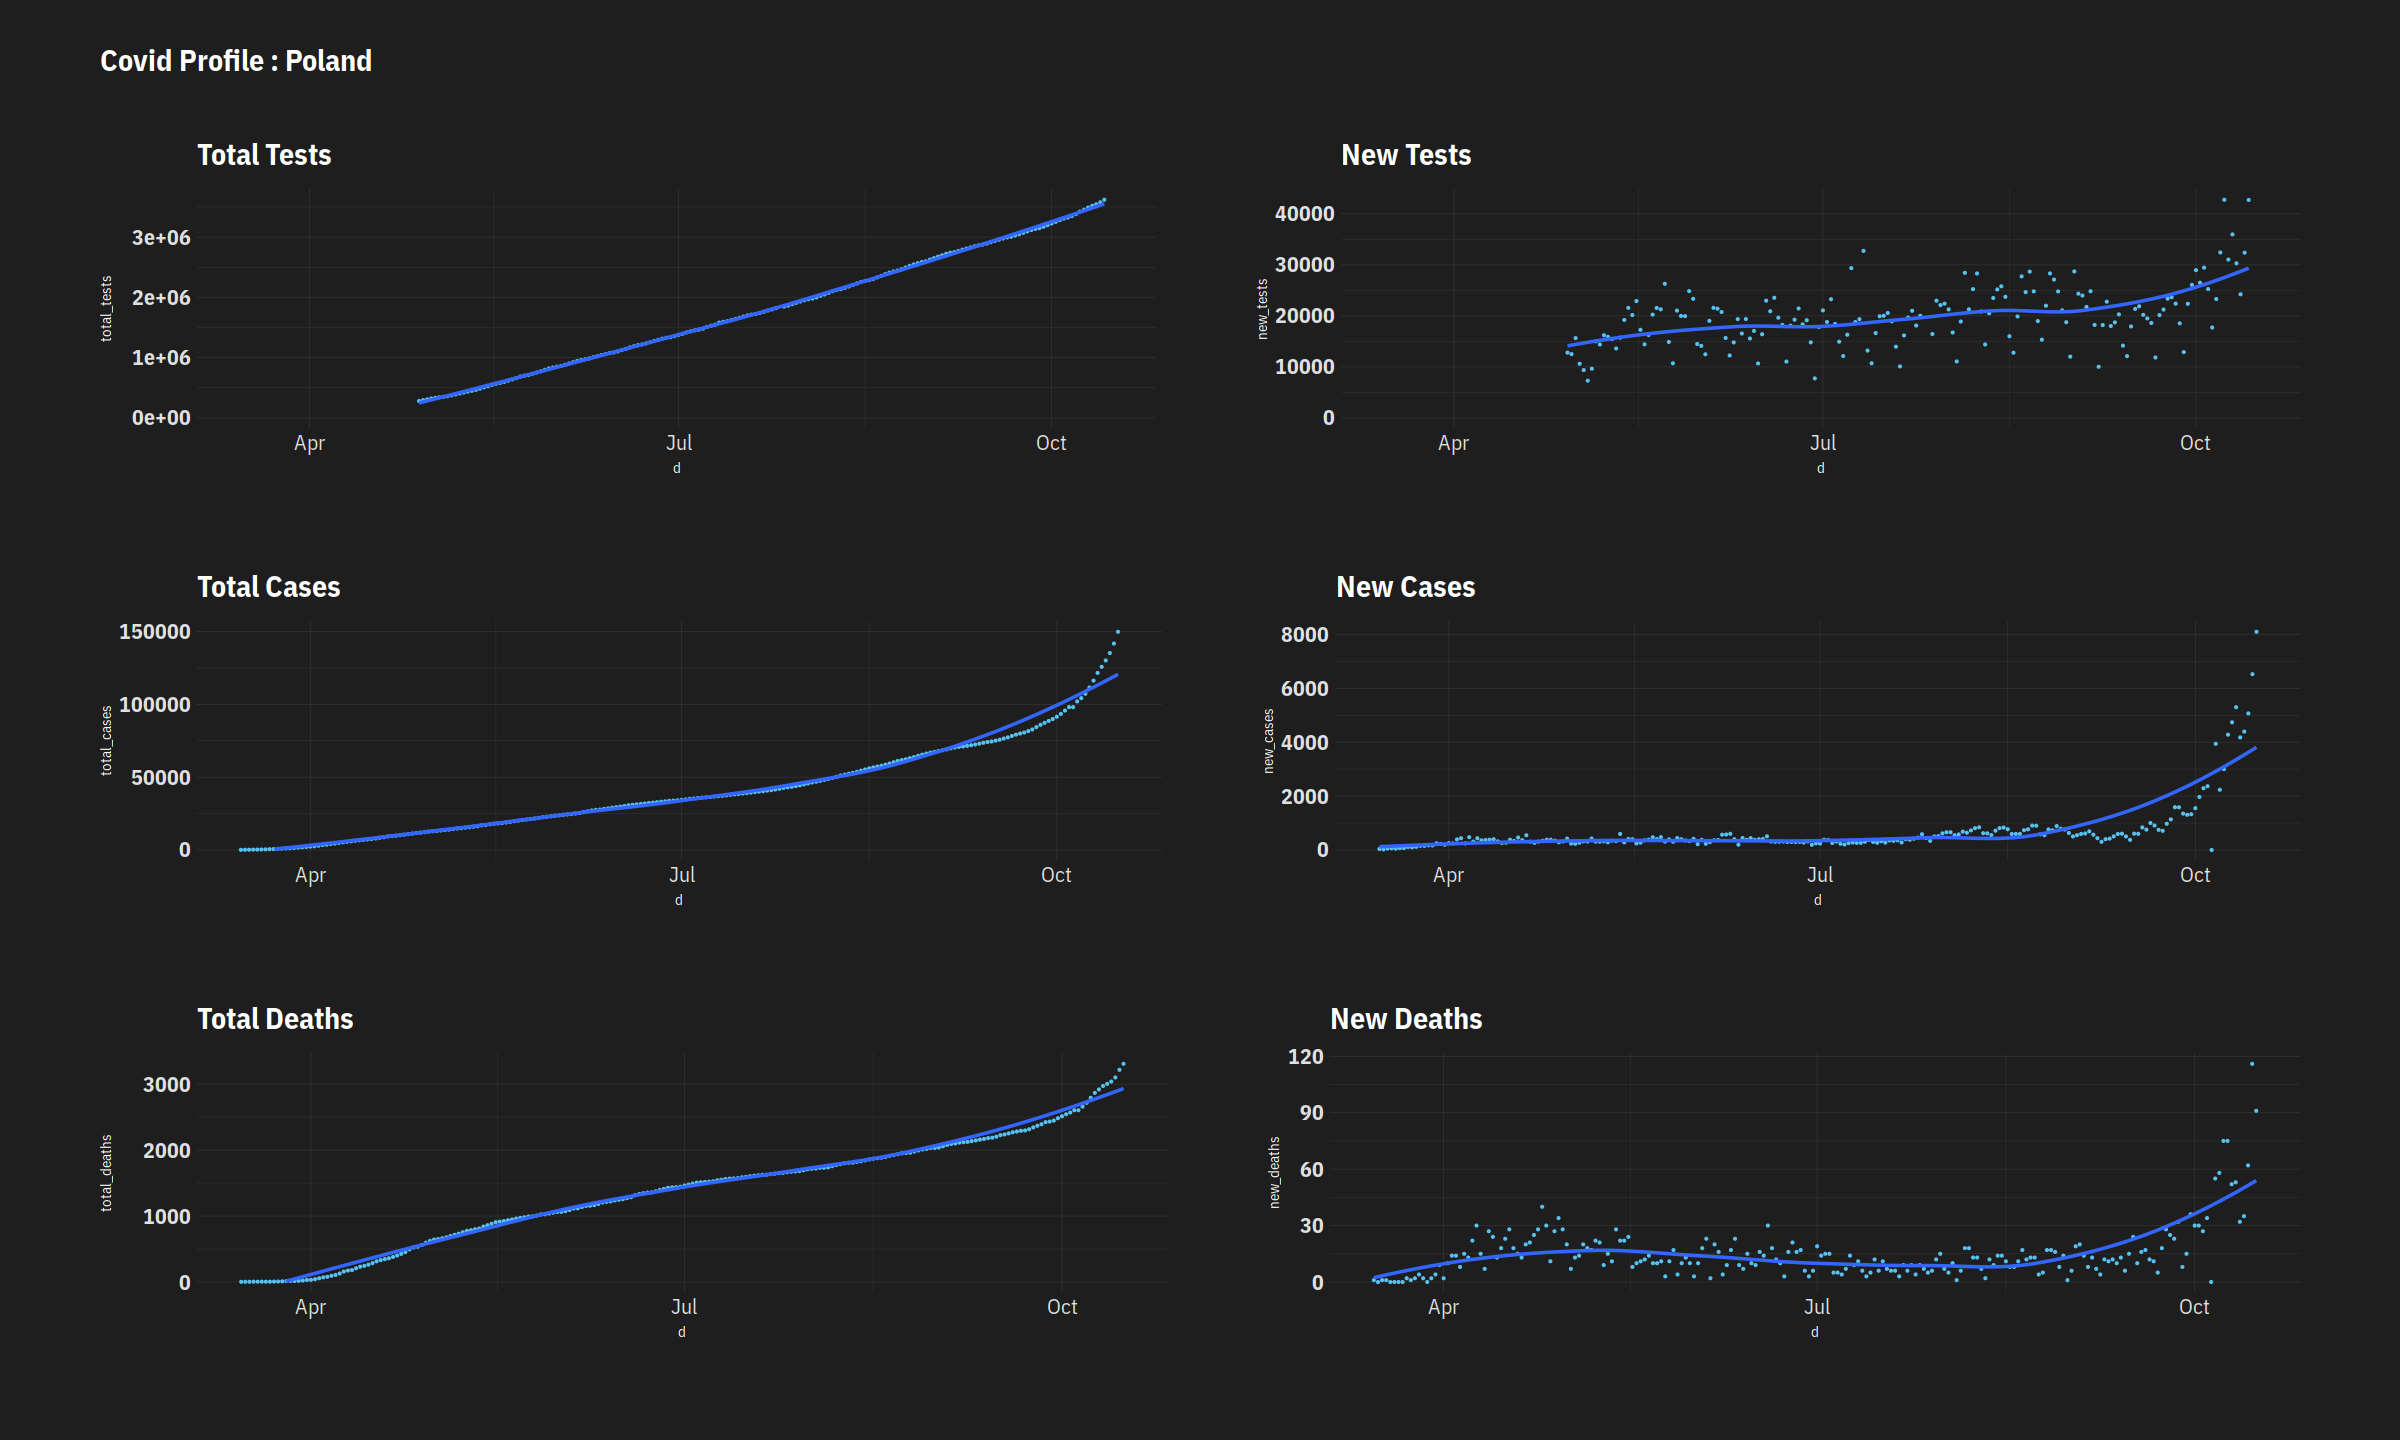

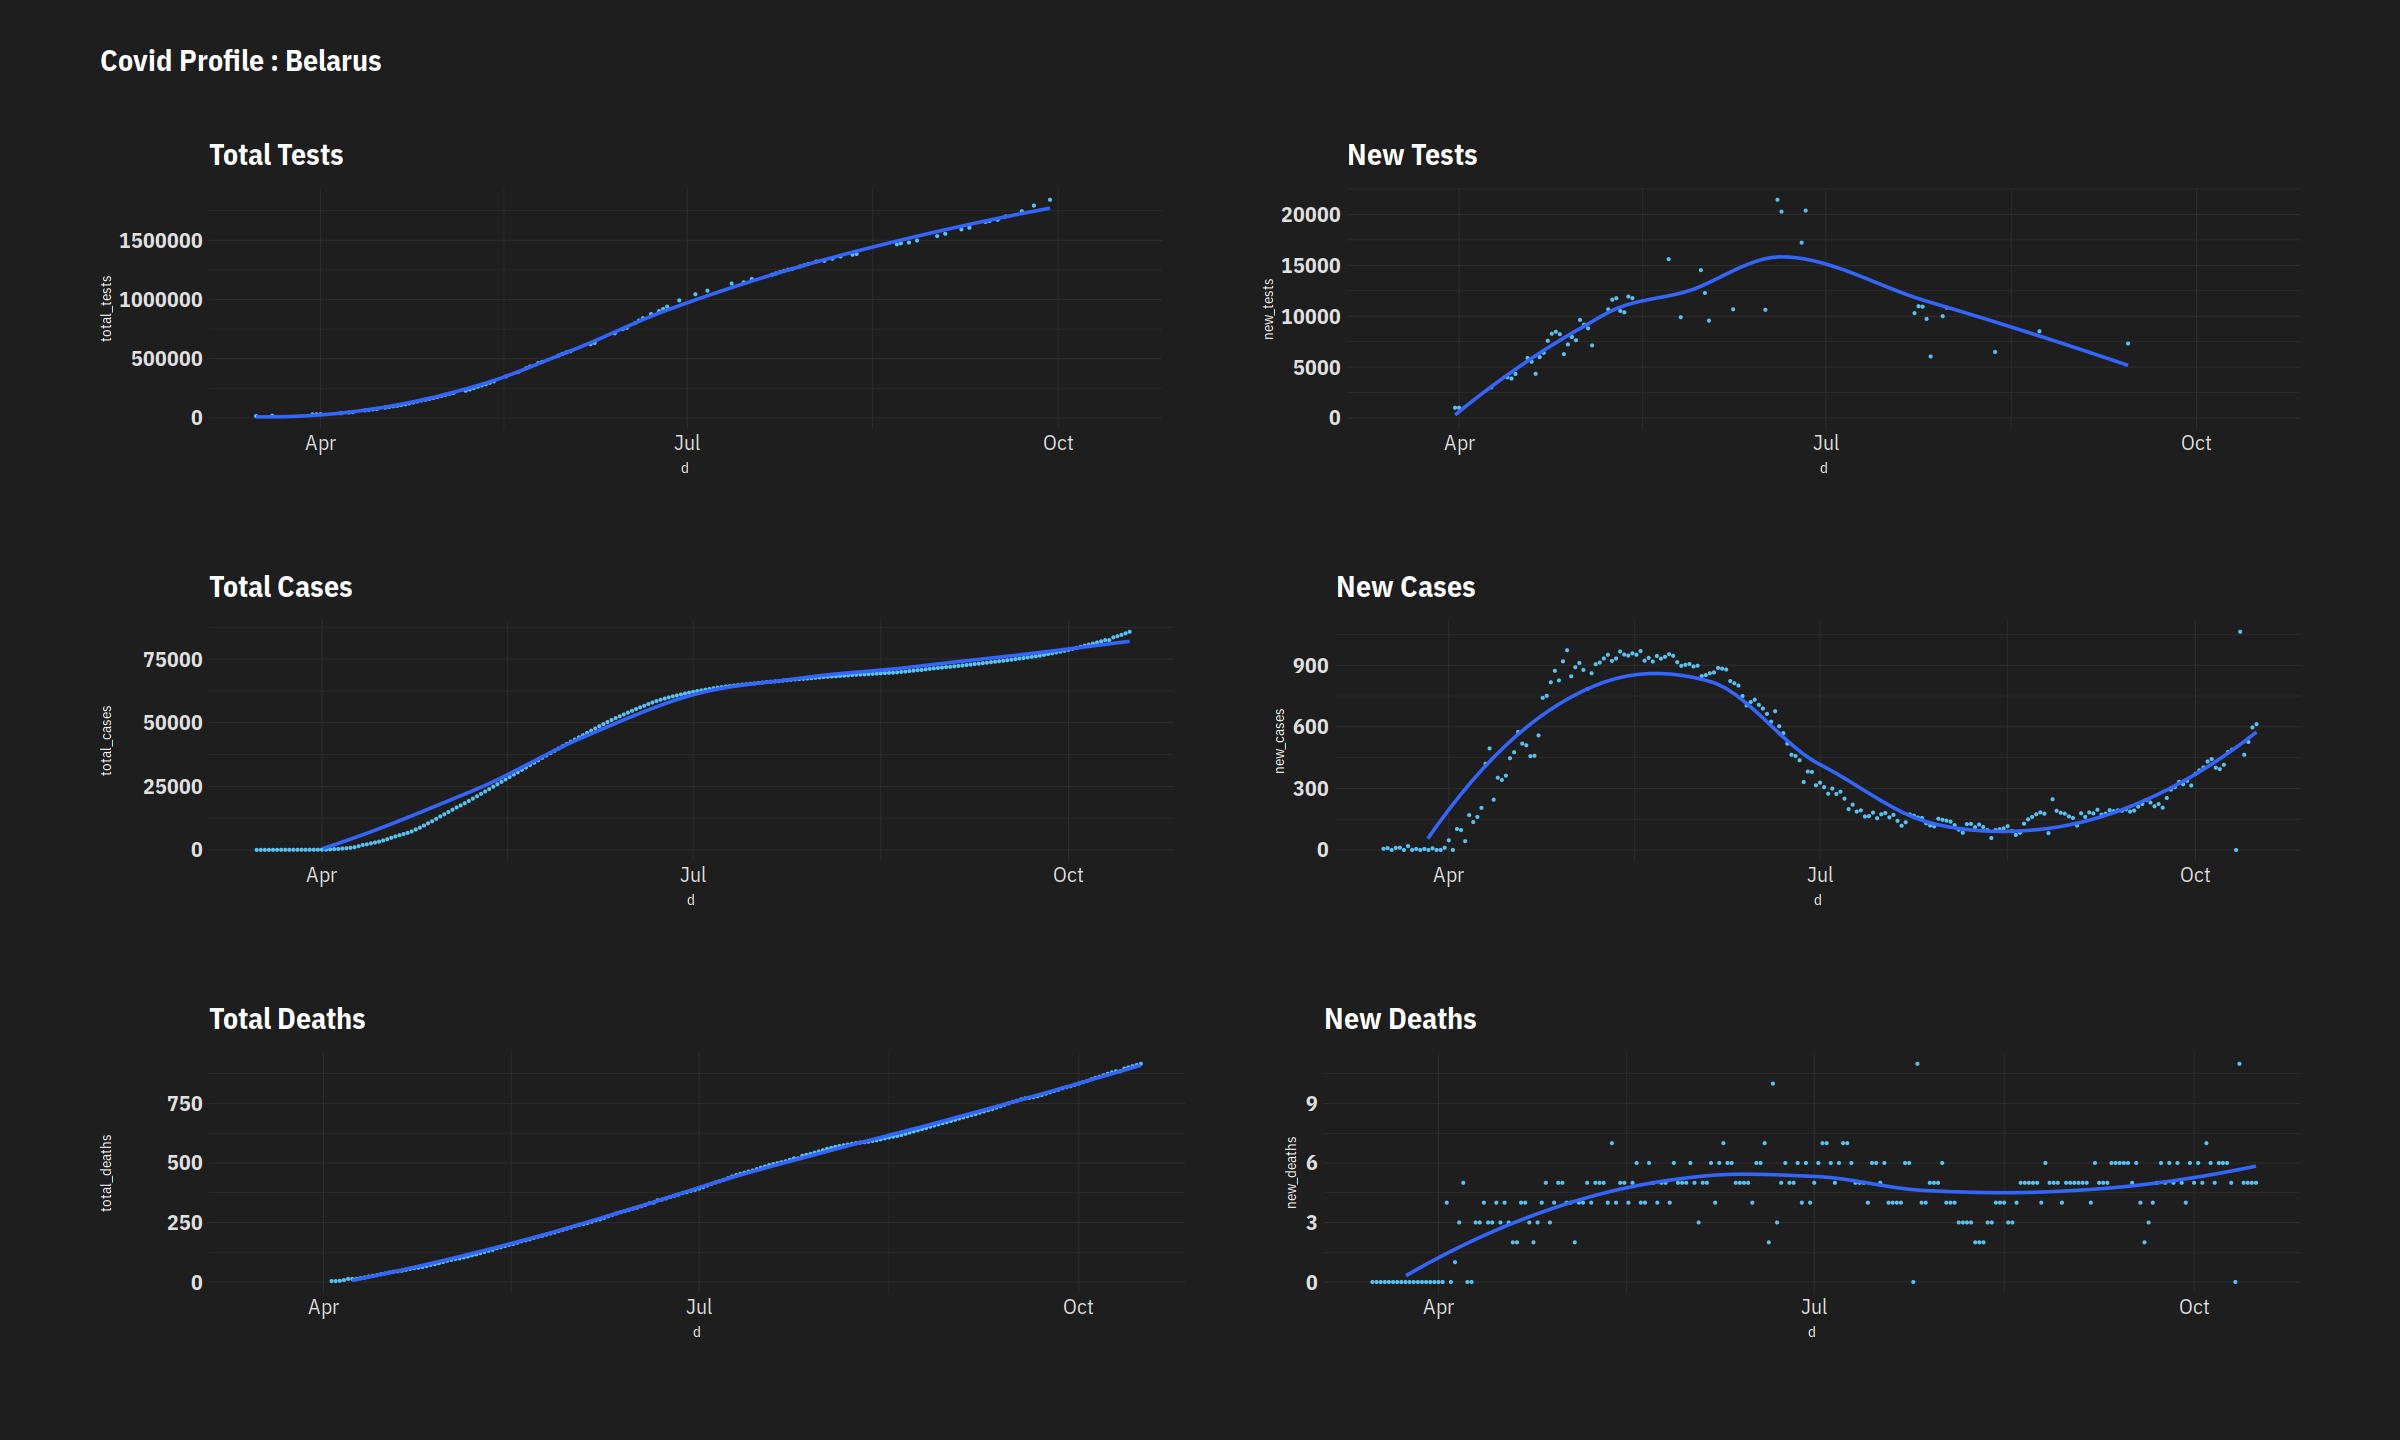

In [25]:
country_plot("Russia")
country_plot("Poland")
country_plot("Belarus")

## North America

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



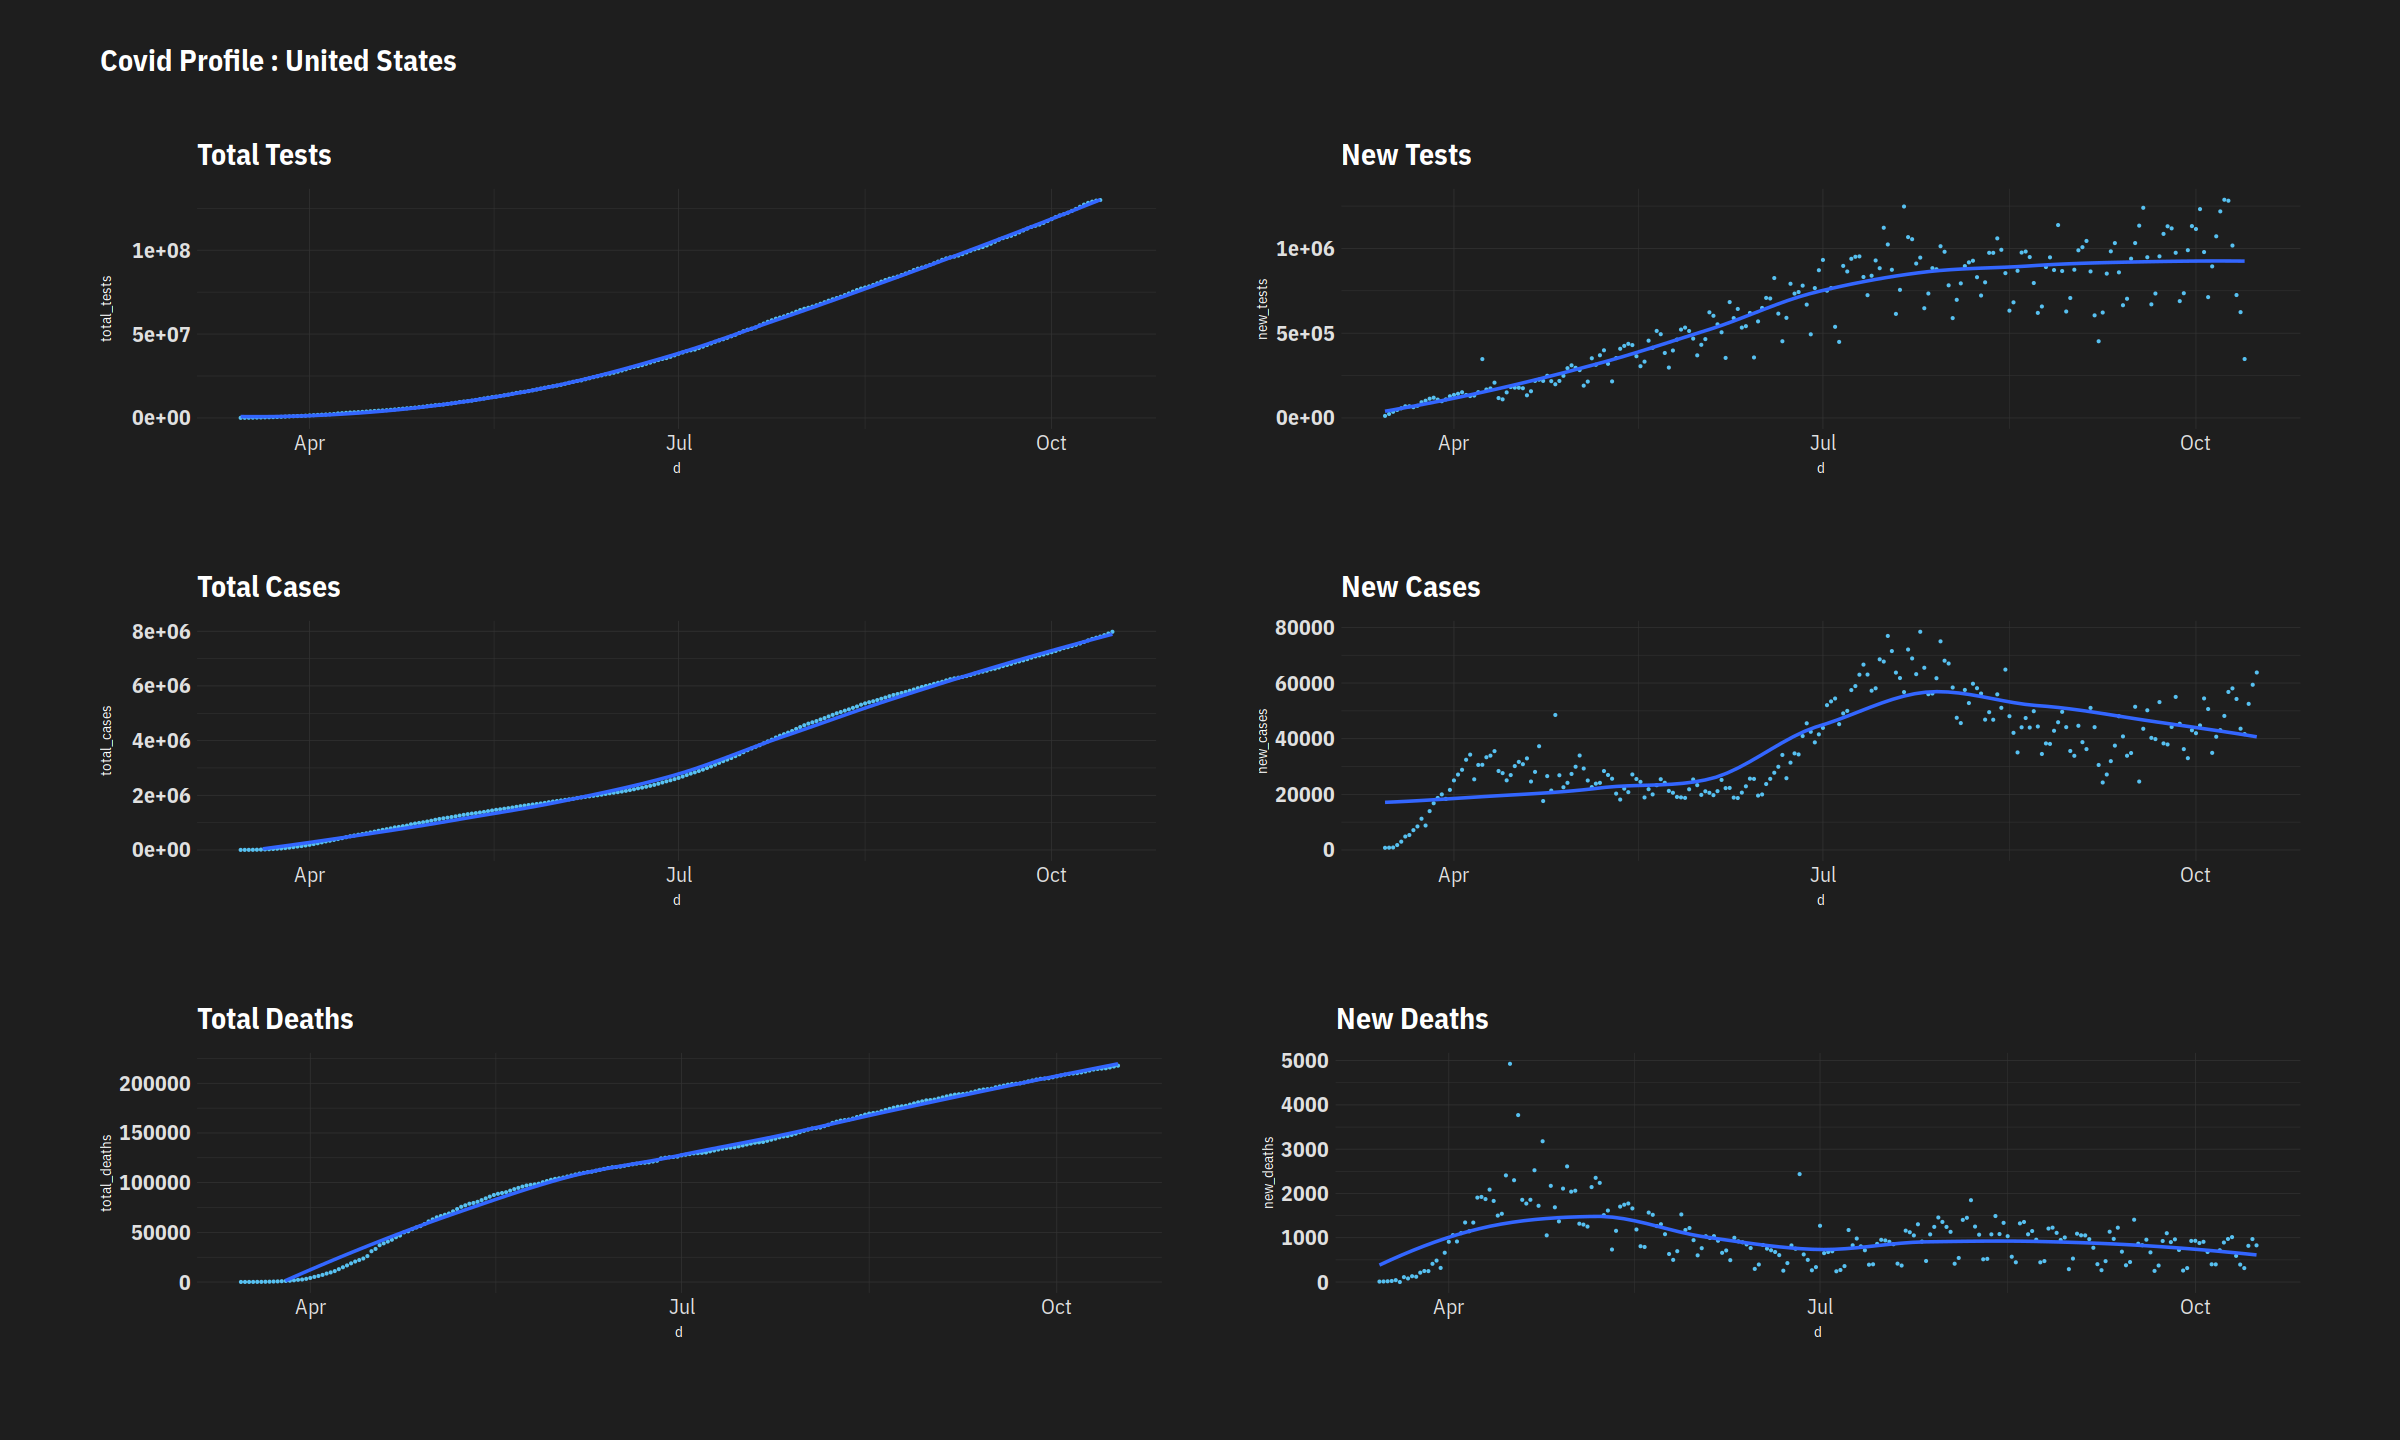

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



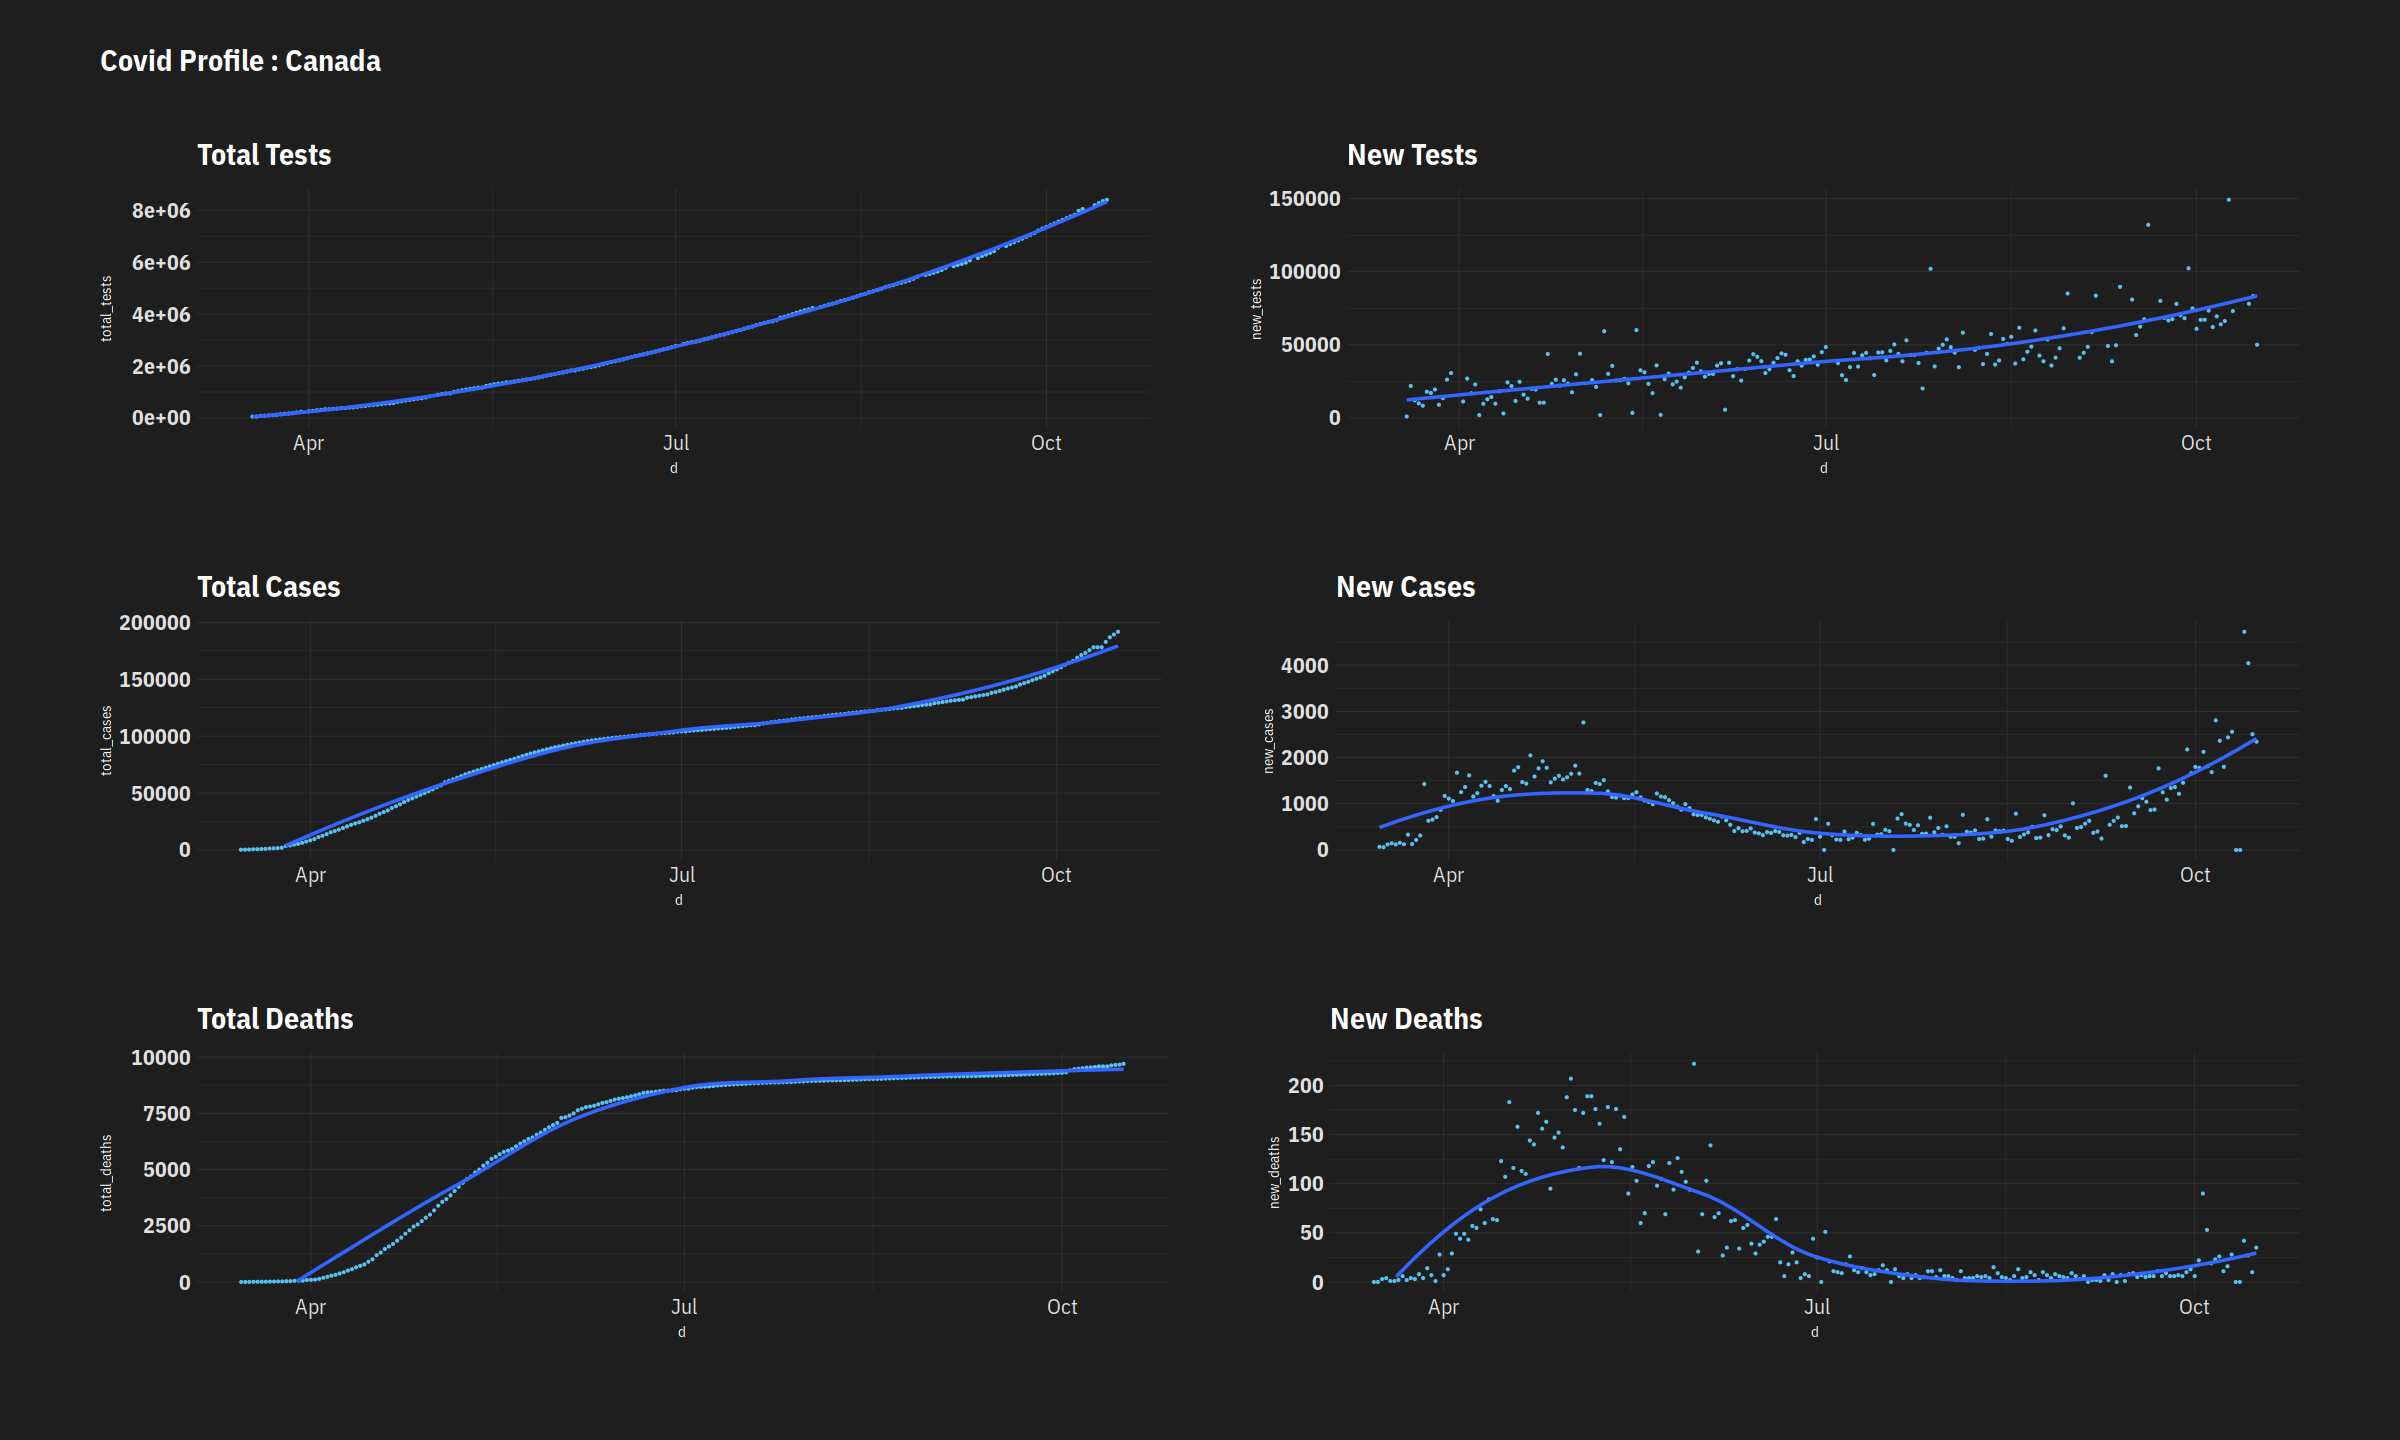

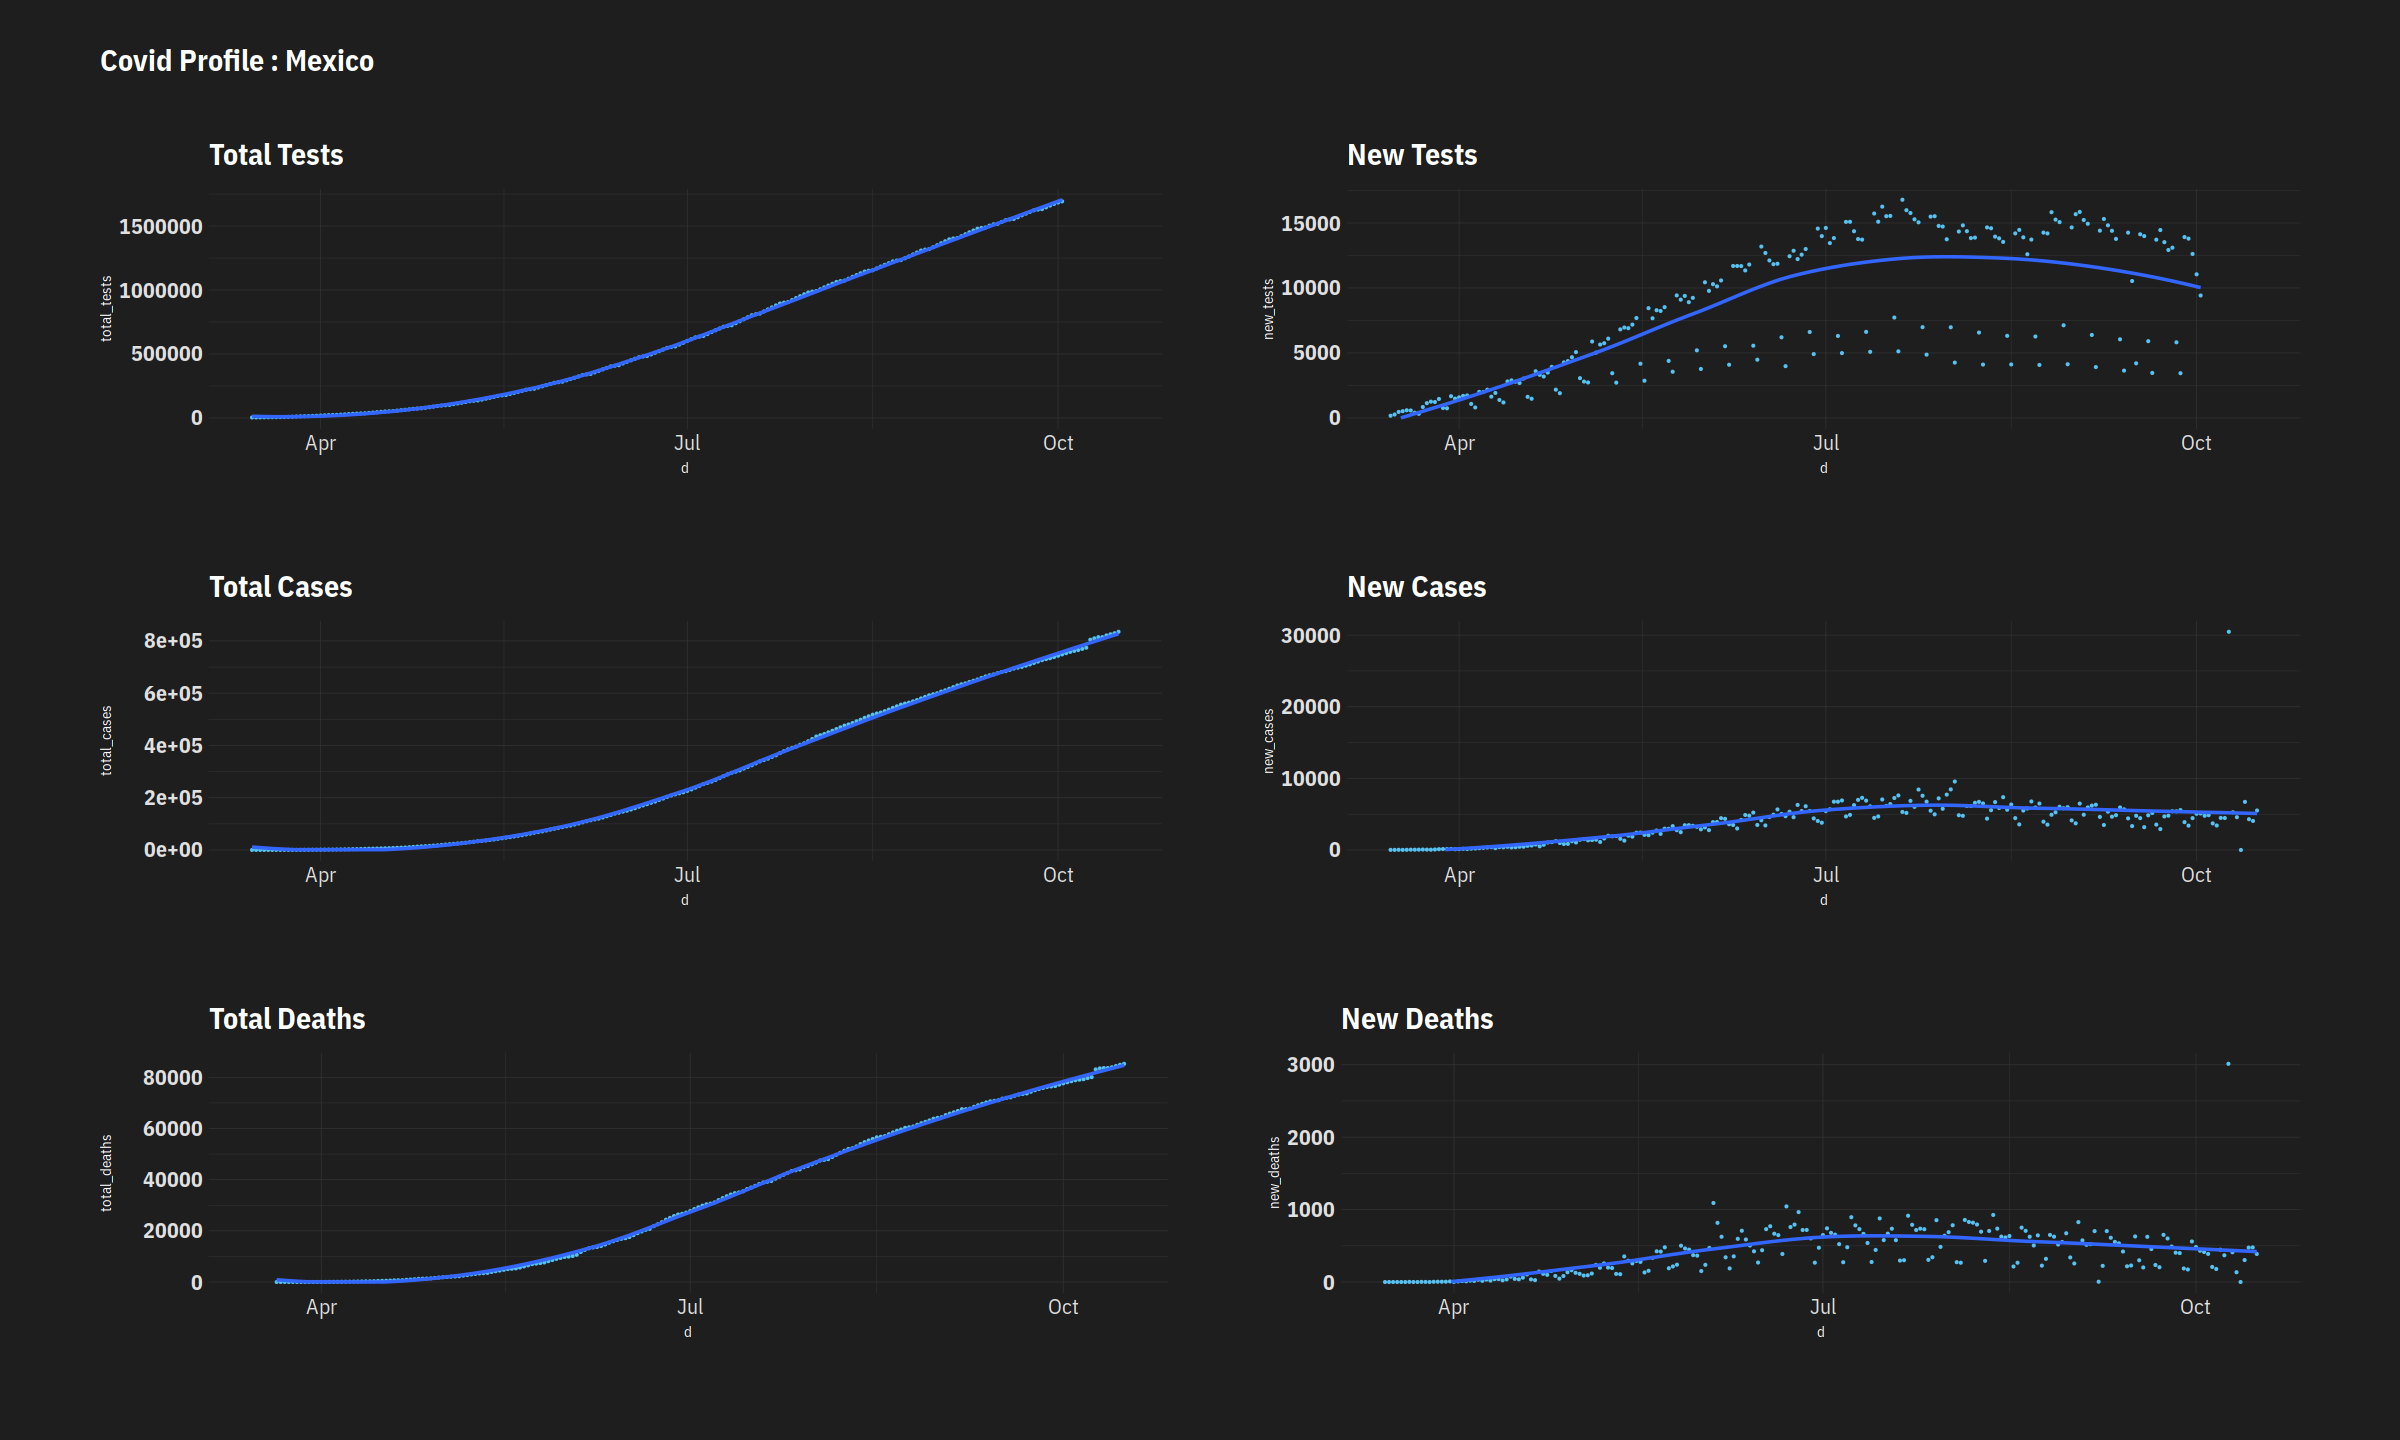

In [26]:
country_plot("United States")
country_plot("Canada")
country_plot("Mexico")

## Europe

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



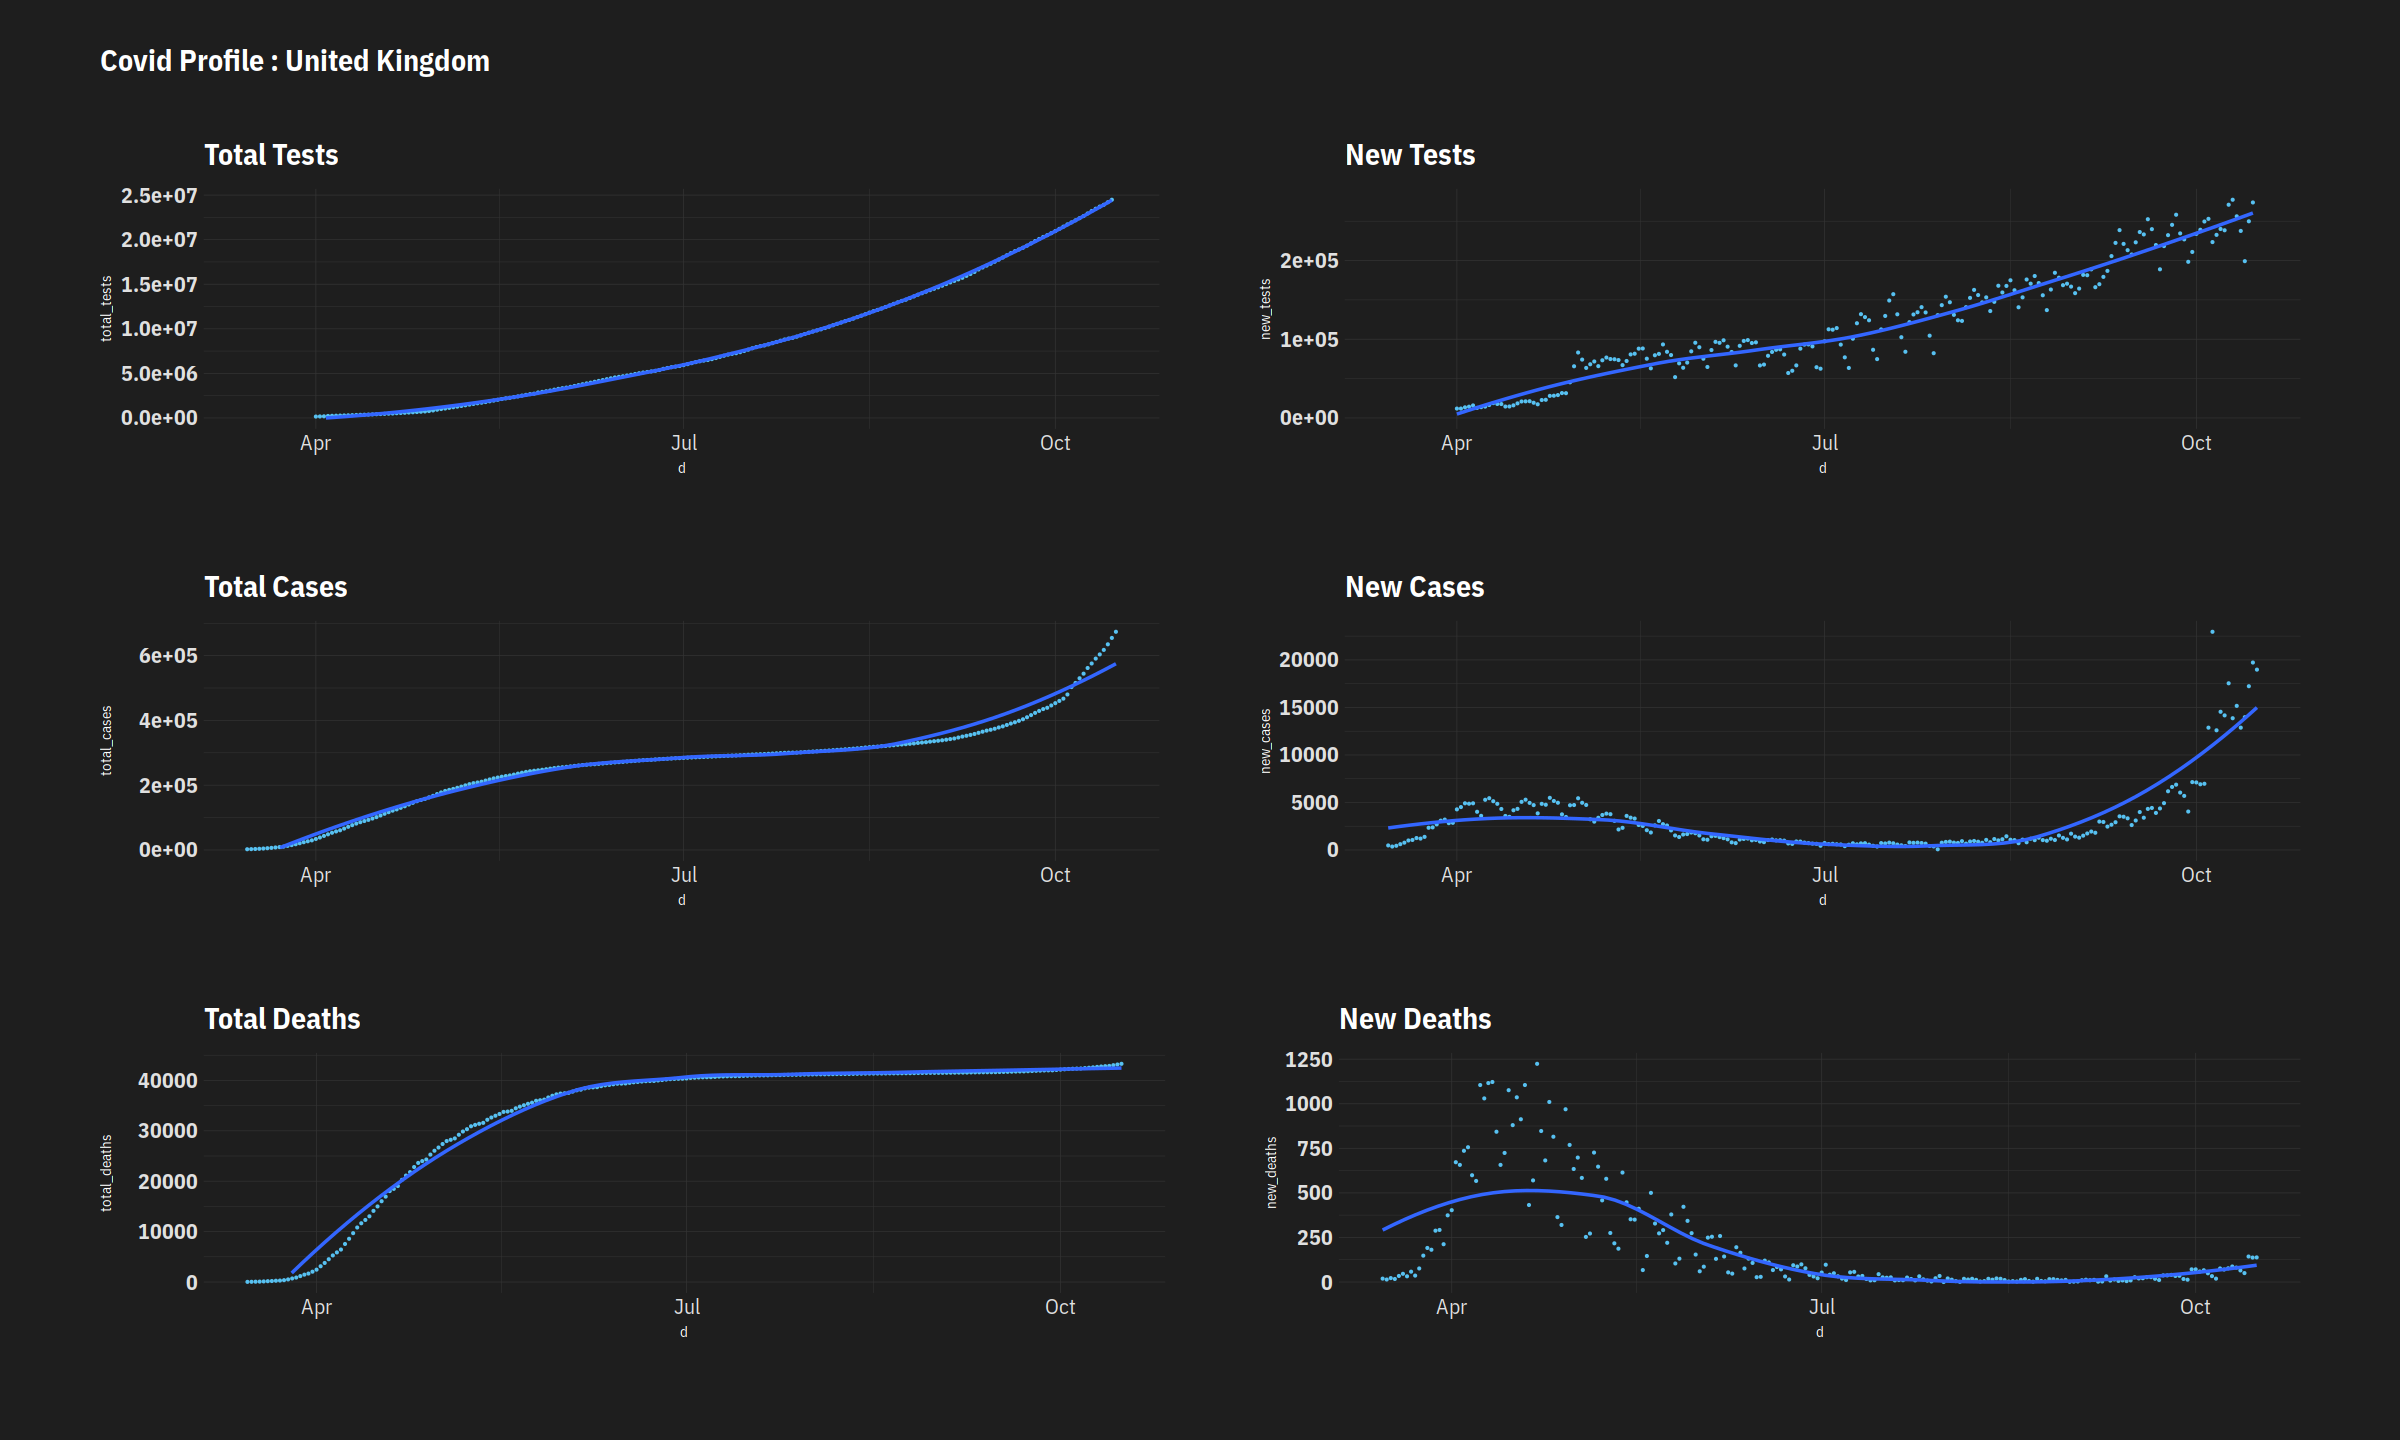

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



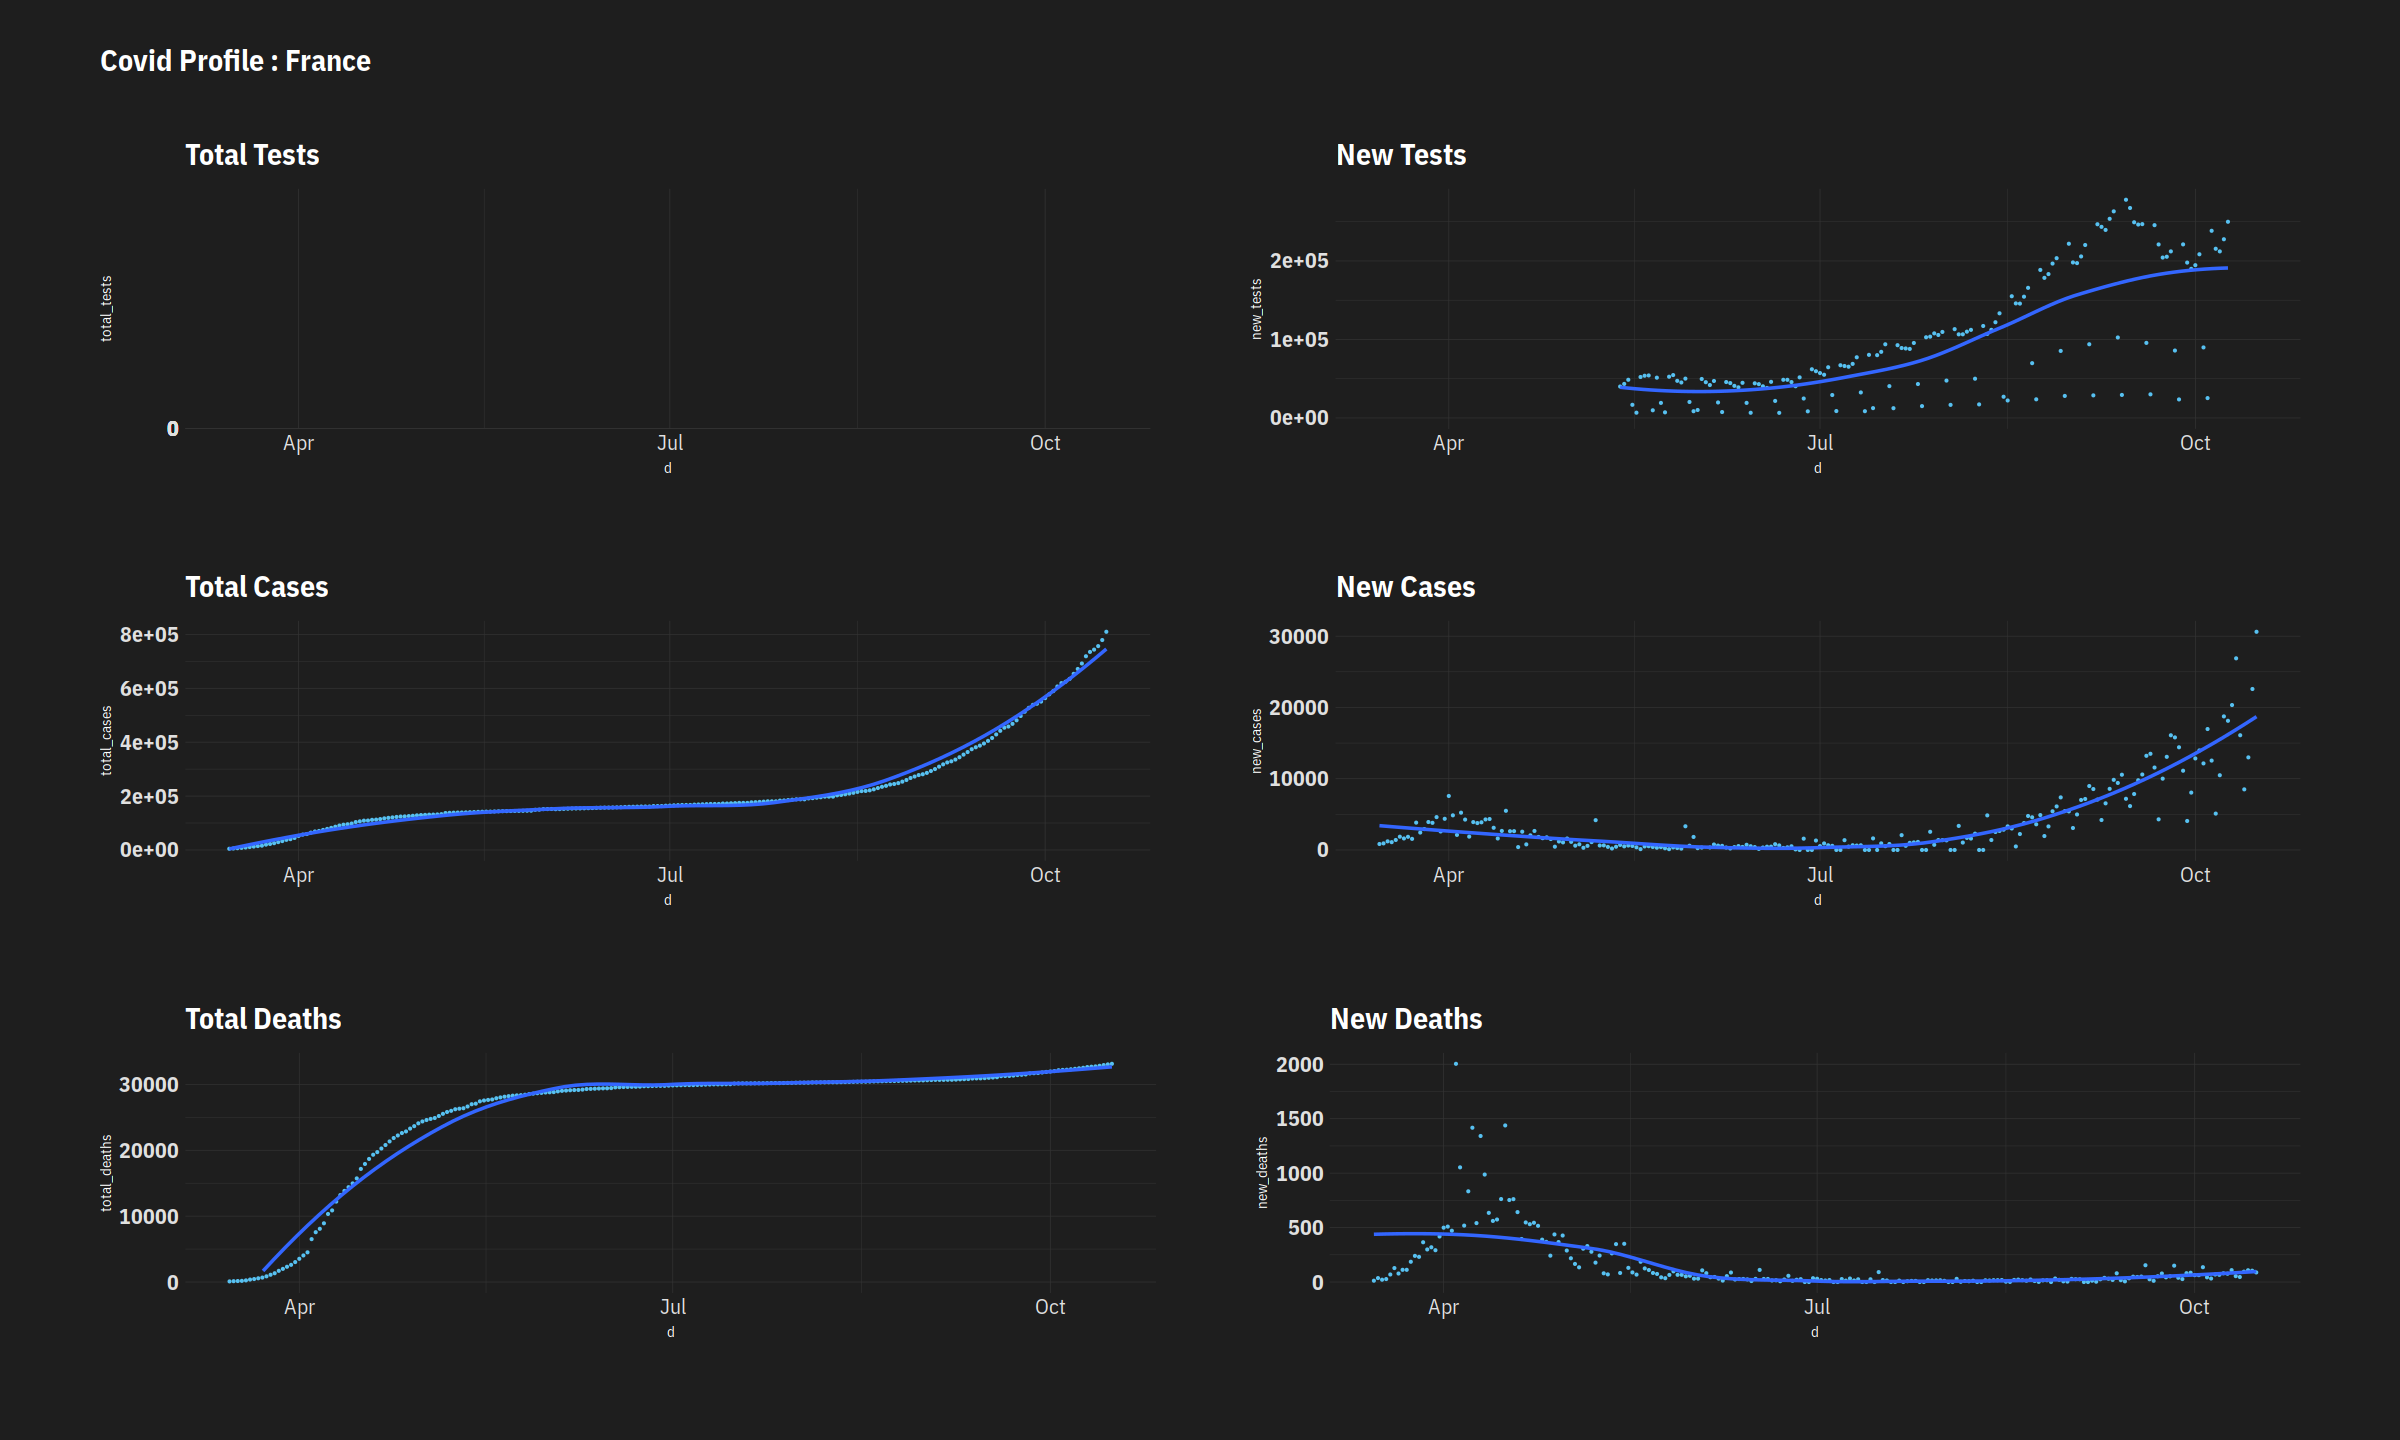

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



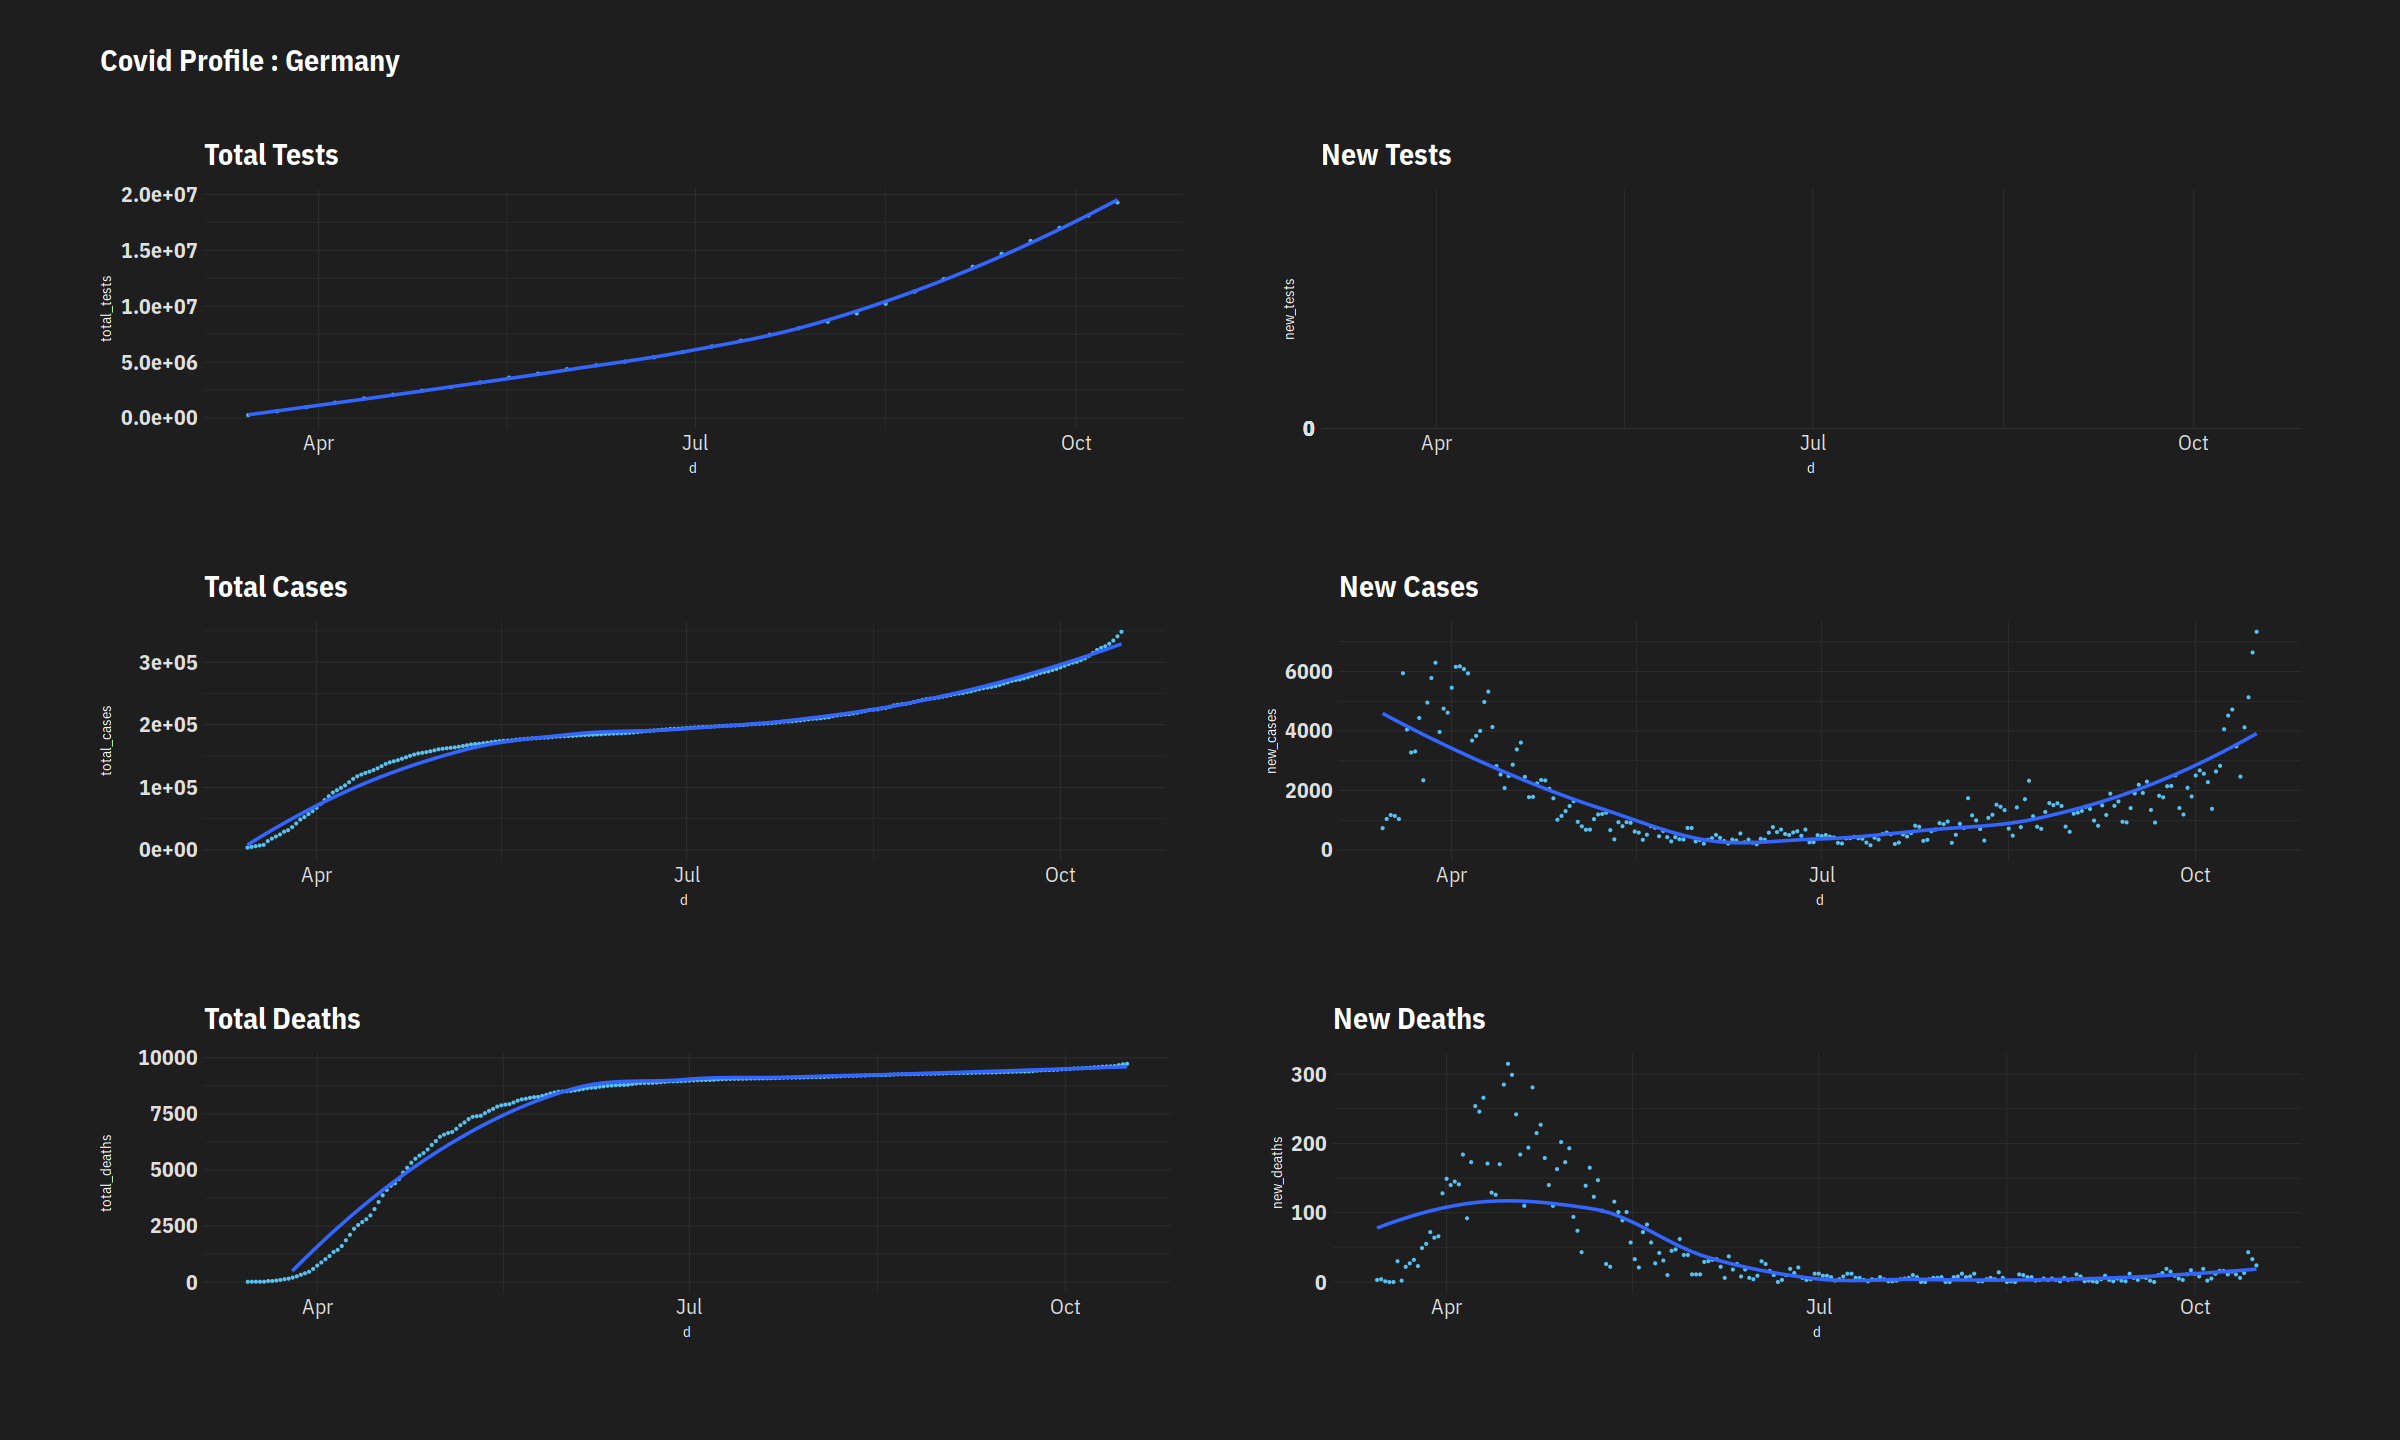

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



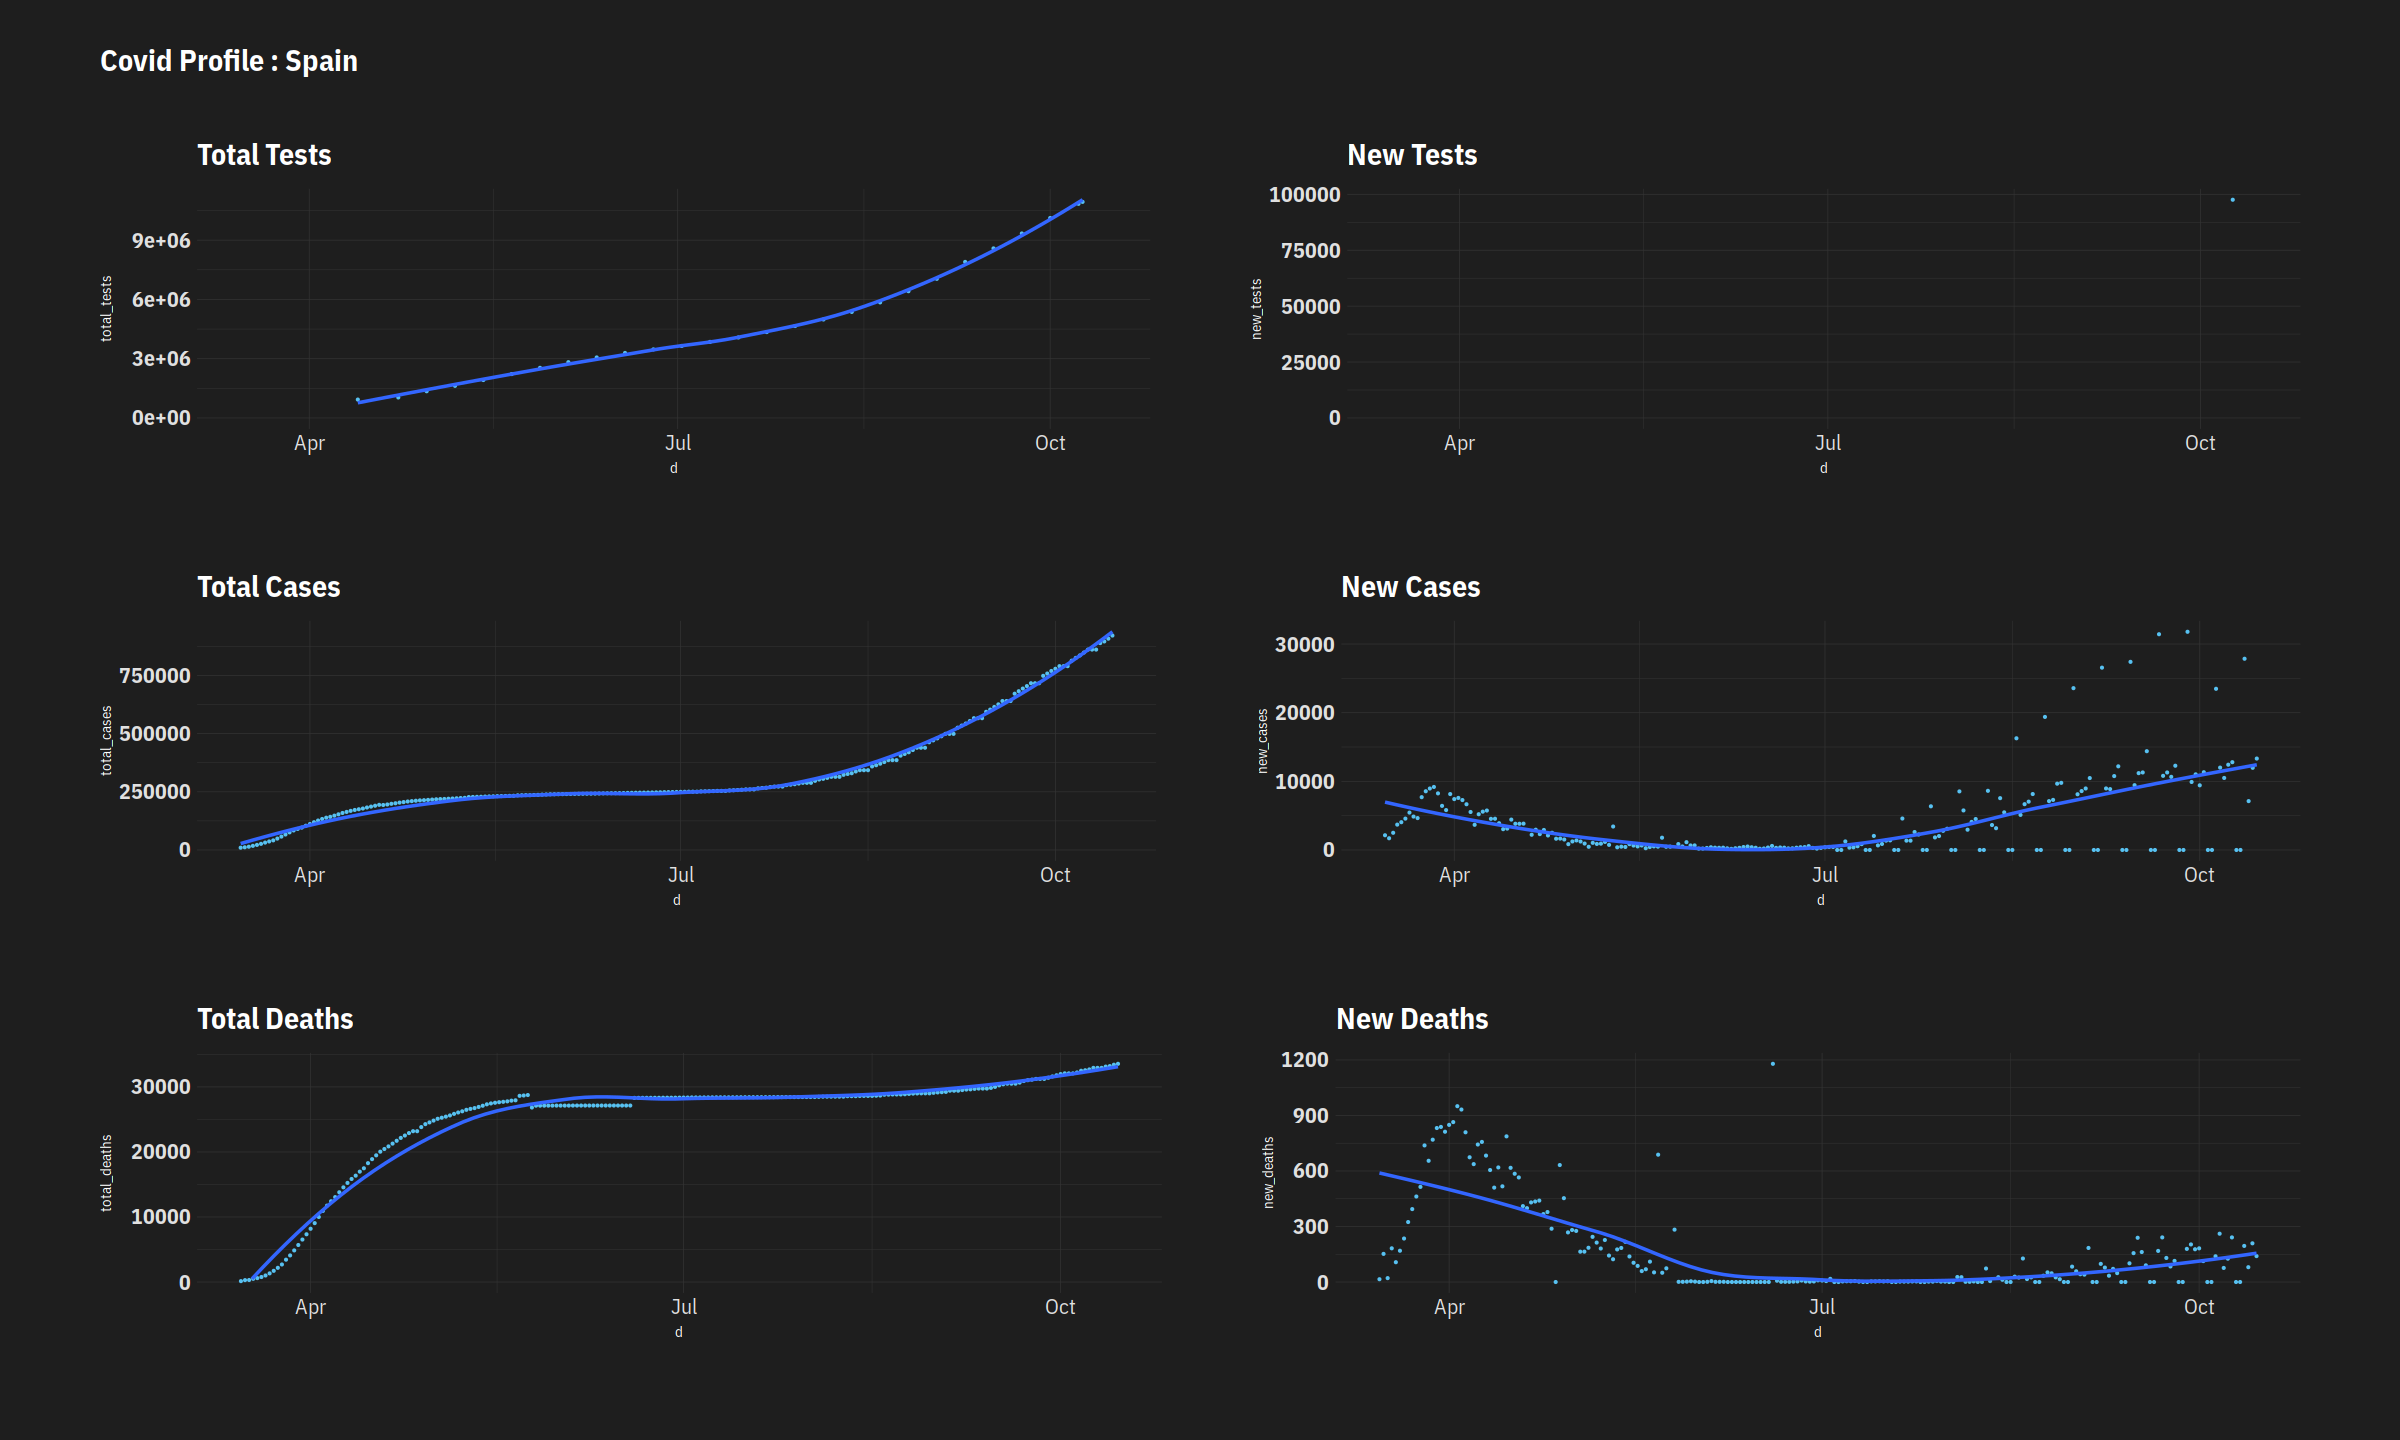

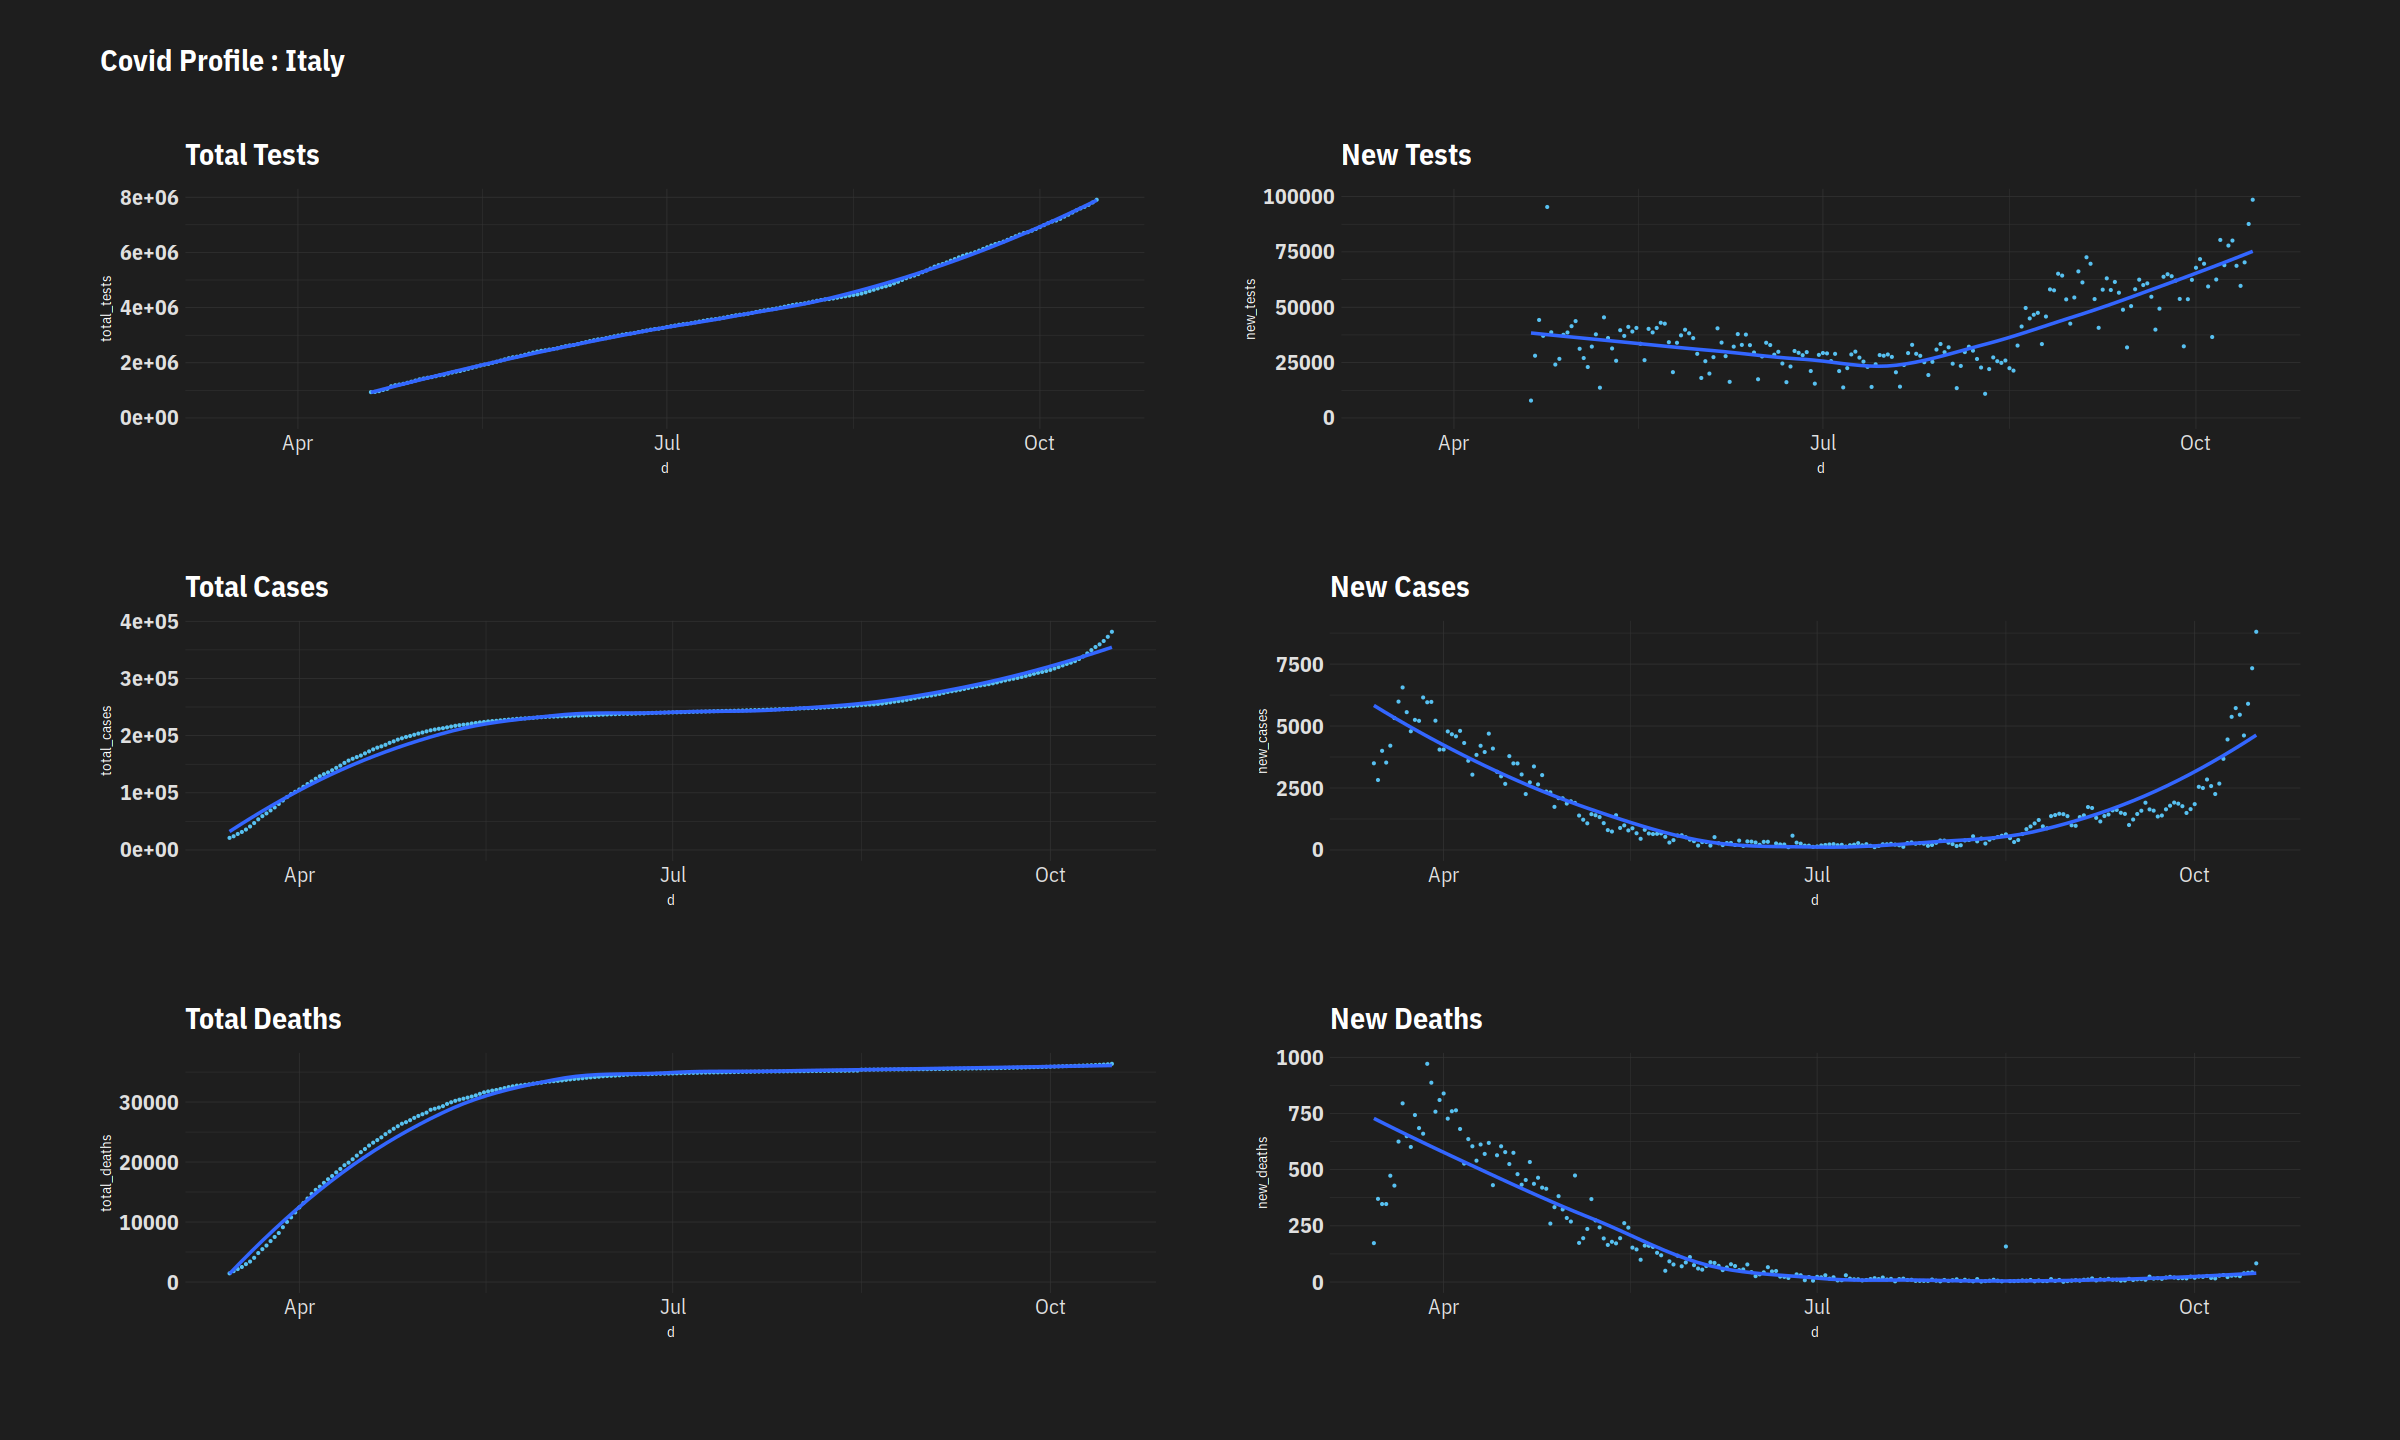

In [27]:
country_plot("United Kingdom")
country_plot("France")
country_plot("Germany")
country_plot("Spain")
country_plot("Italy")

# Excess Mortality

In [28]:
exmort_nyt = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/excess-deaths/deaths.csv")
exmort_nyt[, `:=`(
             start_date = ymd(start_date),
             end_date   = ymd(start_date),
             year = as.numeric(year)
           )
           ]
exmort_nyt %>% glimpse

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


Rows: 5,749
Columns: 12
$ country         <chr> "Israel", "Israel", "Israel", "Israel", "Israel", "Is…
$ placename       <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ frequency       <chr> "weekly", "weekly", "weekly", "weekly", "weekly", "we…
$ start_date      <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ end_date        <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ year            <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020,…
$ month           <int> 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,…
$ week            <int> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ deaths          <int> 1010, 1099, 1000, 991, 944, 965, 988, 903, 929, 963, …
$ expected_deaths <int> 1071, 1069, 1066, 1059, 1048, 1032, 1011, 987, 961, 9…
$ excess_deaths   <int> -61, 30, -66, -68, -104, -67, -23, -84, -32, 27, -22,…
$ baseline        <chr> "2015-2019 historical data", "2015-2019 historical da…


In [29]:
exmort_nyt[, .N, by = .(country, placename, frequency)]

country        placename frequency N  
1  Israel                   weekly    282
2  Ecuador                  monthly    39
3  Indonesia      Jakarta   monthly   129
4  Portugal                 weekly    286
5  Belgium                  weekly    236
6  Austria                  weekly    287
7  Turkey         Istanbul  weekly    114
8  Brazil                   weekly     29
9  Peru                     monthly    57
10 United States            weekly     87
11 Japan          Tokyo     monthly    60
12 Mexico                   weekly     38
13 South Korea              monthly    67
14 Bolivia                  monthly    55
15 Ireland                  weekly    273
16 Colombia                 weekly    283
17 India          Mumbai    monthly    19
18 Spain                    weekly    127
19 Chile                    weekly    288
20 Germany                  weekly    234
21 France                   weekly    519
22 Sweden                   weekly    287
23 Switzerland              weekly    237
24 Norway                   weekly    287
25 United Kingdom           weekly    536
26 Denmark                  weekly    288
27 Finland                  weekly    186
28 South Africa             weekly     37
29 Netherlands              weekly    238
30 Italy                    monthly    12
31 Thailand                 monthly    64
32 Russia         Moscow    monthly    68

In [30]:
wksamp = exmort_nyt[frequency == "weekly" & year == 2020]

In [31]:
eur = exmort_nyt[country %in% c(
    'Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Netherlands', 
    'Norway', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', "Switzerland"
    ) & year == 2020 & placename == ""]
eur[, .SD[1], by = country]

country        placename frequency start_date end_date   year month week
1  Portugal                 weekly    2020-01-06 2020-01-06 2020 1      2  
2  Belgium                  weekly    2020-01-06 2020-01-06 2020 1      2  
3  Austria                  weekly    2020-01-06 2020-01-06 2020 1      2  
4  Spain                    weekly    2020-01-06 2020-01-06 2020 1      2  
5  Germany                  weekly    2020-01-06 2020-01-06 2020 1      2  
6  France                   weekly    2020-01-06 2020-01-06 2020 1      2  
7  Sweden                   weekly    2020-01-06 2020-01-06 2020 1      2  
8  Switzerland              weekly    2020-01-06 2020-01-06 2020 1      2  
9  Norway                   weekly    2020-01-06 2020-01-06 2020 1      2  
10 United Kingdom           weekly    2020-01-04 2020-01-04 2020 1      2  
11 Denmark                  weekly    2020-01-06 2020-01-06 2020 1      2  
12 Finland                  weekly    2020-01-06 2020-01-06 2020 1      2  
13 Netherlands              weekly    2020-01-06 2020-01-06 2020 1      2  
14 Italy                    monthly   <NA>       <NA>       2020 1     NA  
   deaths expected_deaths excess_deaths baseline                 
1   2654   2903            -249         2015-2019 historical data
2   2380   2395             -15         2016-2019 historical data
3   1702   1814            -112         2015-2019 historical data
4   8936   9211            -275         2018-2019 historical data
5  19440  19662            -222         2016-2019 historical data
6  13404  13654            -250         2010-2019 historical data
7   1890   1881               9         2015-2019 historical data
8   1350   1477            -127         2016-2019 historical data
9    948    911              37         2015-2019 historical data
10 16020  15469             551         2010-2019 historical data
11  1149   1121              28         2015-2019 historical data
12  1068   1155             -87         2017-2019 historical data
13  3364   3327              37         2016-2019 historical data
14 58650  61646           -2996         2015-2019 historical data

In [32]:
eur[is.na(start_date), start_date := ymd(paste0(year, '-', month, "-01"))]
eur[, excess := fifelse(excess_deaths > 0, 1, 0)]

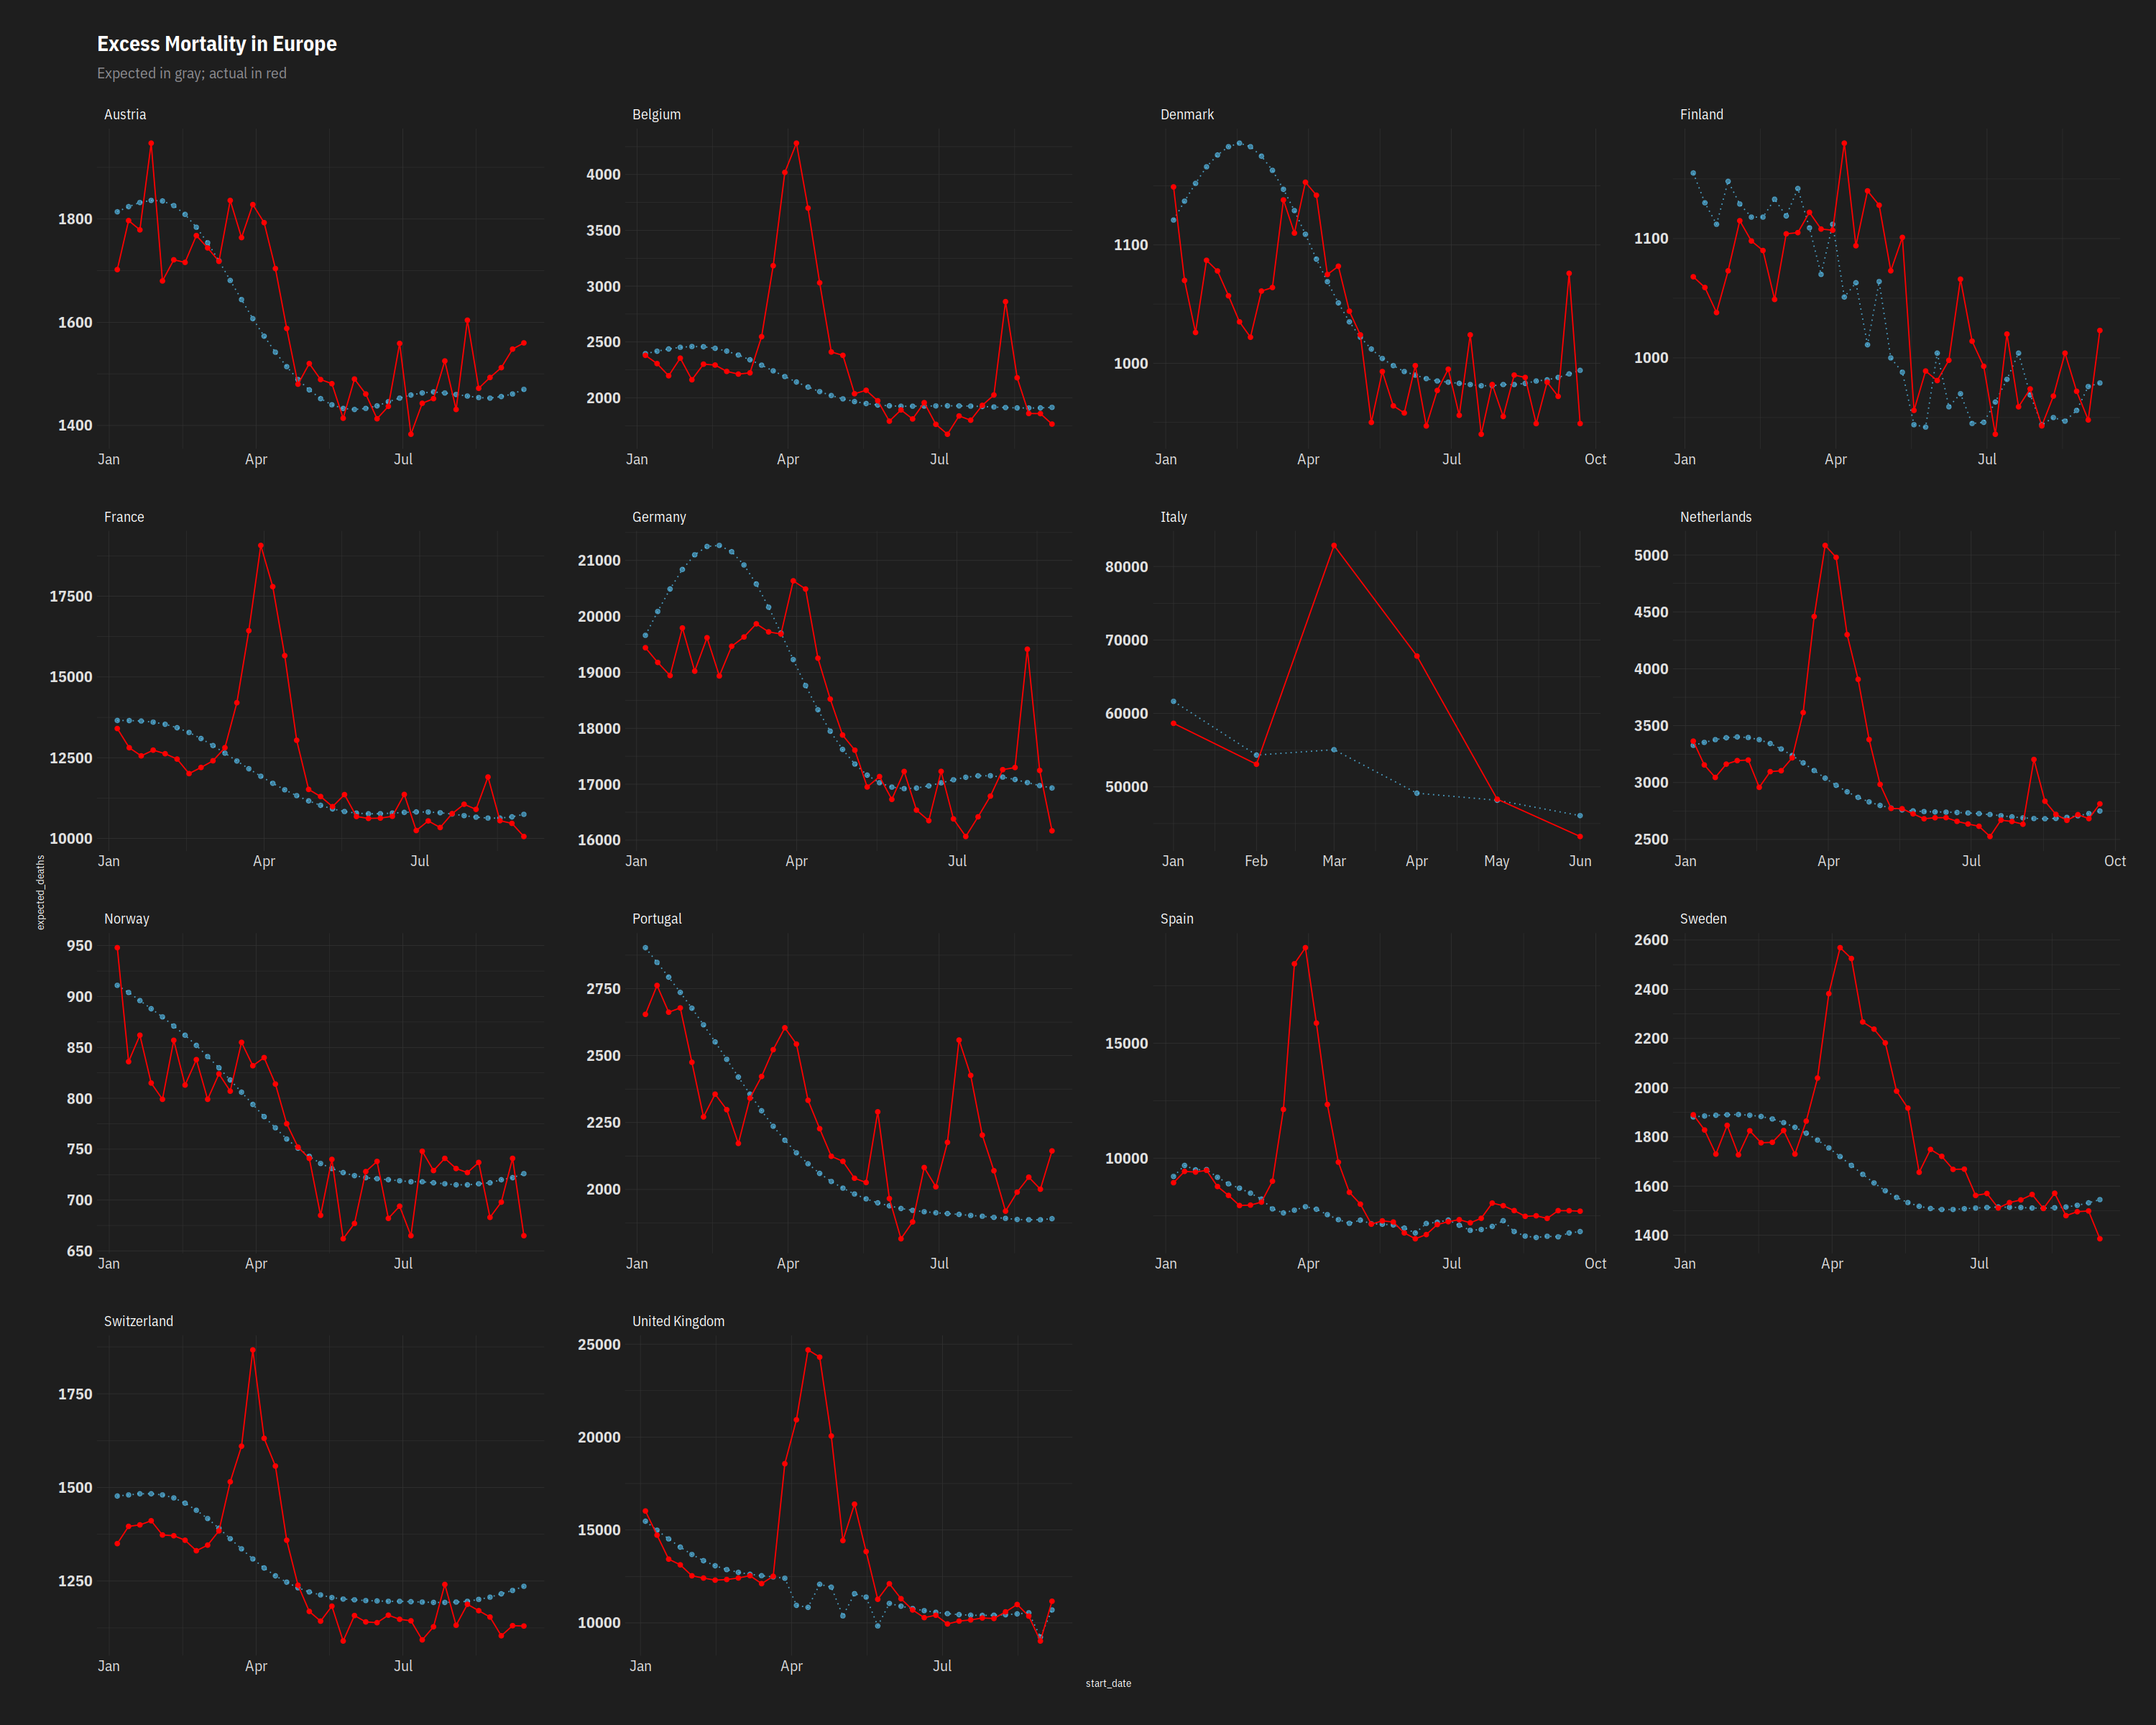

In [33]:
options(repr.plot.width = 25, repr.plot.height=20)
ggplot(eur, aes(x = start_date, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ country, scales = 'free') +
    labs(title = "Excess Mortality in Europe", subtitle = "Expected in gray; actual in red") 

In [34]:
us_samp = exmort_nyt[year == 2020 & country == "United States" & placename != ""]
us_samp[, dt := ifelse(is.na(start_date), year + month, year + month + week - 1)]
us_samp[, .SD[1:2], by = placename] 

placename country frequency start_date end_date year month week deaths
     expected_deaths excess_deaths baseline dt

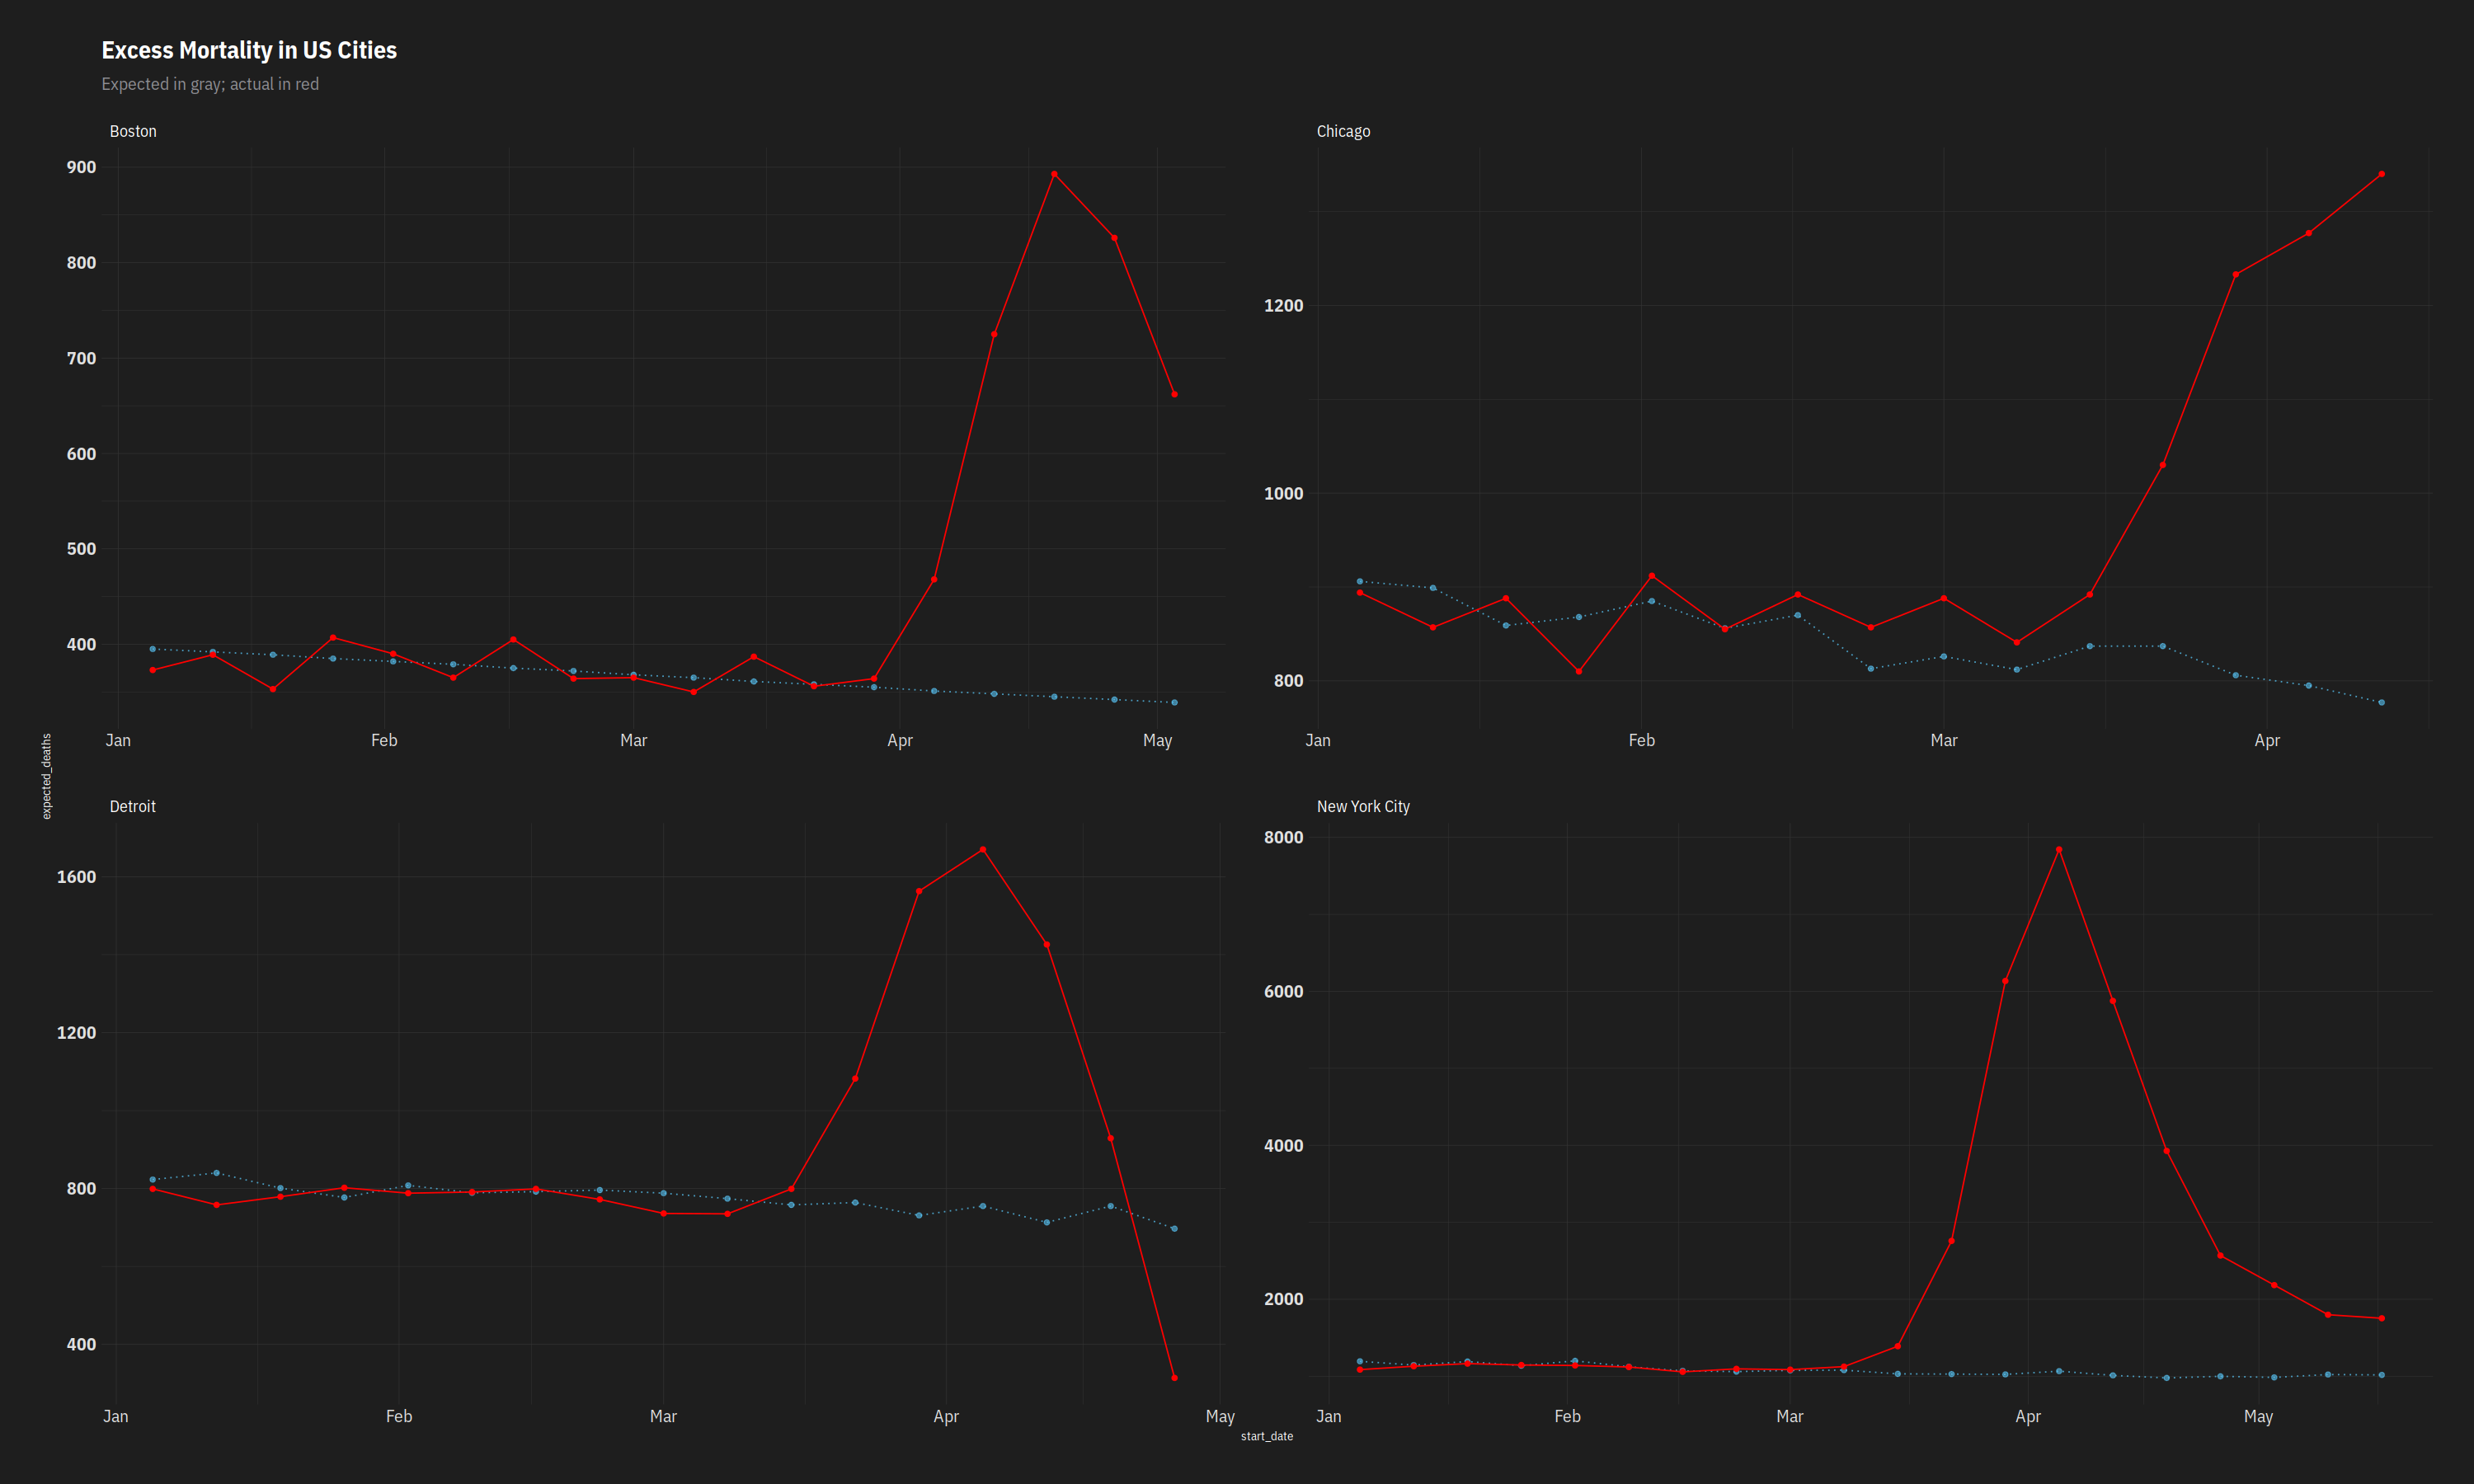

In [37]:
options(repr.plot.width = 25, repr.plot.height=15)
ggplot(us_samp[!is.na(start_date)], aes(x = start_date, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ placename, scales = 'free') +
    labs(title = "Excess Mortality in US Cities", subtitle = "Expected in gray; actual in red") 